Sources

1. https://reader.elsevier.com/reader/sd/pii/S1877050920317877?token=C99287995D164BC268CF265DCE3CDAF0D18A8E72A89C4A389F10A4A3C7E2E8EA2FA6F0B63574C0CF2AD6D1E40BE277B3&originRegion=eu-west-1&originCreation=20230430181801 <br>

2. https://www.datacamp.com/tutorial/lstm-python-stock-market <br>

3. http://colah.github.io/posts/2015-08-Understanding-LSTMs/

**Прогнозирование цены криптовалюты**<br>

> **Задача** <br>
Спрогнозировать цену биткоина для таймфреймов одна минута и один день




Main metric for a prediction valuation is **RMSE**

In [1]:
!pip install scalecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 40.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 20.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 35.2 MB/s eta 0:00:00
  Created wheel for scalecast: filename=SCALECAST-0.18.6-py3-none-any.whl size=111501 sha256=98abeafdbde79141b110ce5c4c63532d0ee8b9e791755f27ab428b1f0b0716ab
  Stored in directory: /root/.cache/pip/wheels/98/3e/ce/7dc7b94864270b53b482d4ed19d35b547dfa6d4369659516e5
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=1

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Specify a path variable (project path)
proj_path = '/content/gdrive/MyDrive/Colab Notebooks/save_data/'

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import load_model

# Data cleaning

In [56]:
# Load the data into a DataFrame
candles = pd.read_csv(proj_path + 'binance_data.csv')
candles

,open_time,open_price,high_price,low_price,close_price,volume,close_time,quote_asset_volume,trades_number,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,1678414380000,20106.82,20118.00,20101.90,20116.59,165.194330,1678414439999,3.322095e+06,4672,81.958640,1.648224e+06
1,1678414440000,20116.18,20127.96,20108.71,20125.44,191.487240,1678414499999,3.852397e+06,5402,104.695990,2.106379e+06
2,1678414500000,20125.44,20125.84,20084.04,20084.81,431.434380,1678414559999,8.672093e+06,9675,182.413620,3.666413e+06
3,1678414560000,20084.81,20094.19,20078.59,20089.34,230.222210,1678414619999,4.624388e+06,6257,123.726580,2.485277e+06
4,1678414620000,20088.85,20089.73,20067.96,20075.98,387.942880,1678414679999,7.789311e+06,7693,190.734990,3.829753e+06
...,...,...,...,...,...,...,...,...,...,...,...
1203995,1606212180000,19069.04,19094.99,19040.99,19048.09,166.041829,1606212239999,3.166864e+06,3210,69.709684,1.329408e+06
1203996,1606212240000,19048.10,19100.00,19045.98,19092.32,224.591430,1606212299999,4.286742e+06,3214,170.770636,3.259867e+06
1203997,1606212300000,19092.32,19099.94,19047.17,19062.58,162.456095,1606212359999,3.099339e+06,2967,80.073361,1.527817e+06
1203998,1606212360000,19066.65,19096.60,19062.58,19069.19,128.091541,1606212419999,2.444322e+06,3051,58.514268,1.116667e+06


In [57]:
candles.dropna(inplace=True)
candles.sort_values(by=['open_time'], inplace=True)
candles = candles.reset_index().drop(axis=1, labels='index')

In [58]:
time_df = pd.DataFrame()
time_df['diff_times'] = candles.shift(-1).iloc[:-2, 0] - candles.iloc[:-2, 6]
time_df.dropna(inplace=True)
time_df[time_df.diff_times > 1] / 60000 # find for how many minutes there was a trade stop

,diff_times
9391,60.000017
40039,252.657983
44839,60.000017
114000,79.087117
146940,90.000017
211650,150.000017
218821,284.030900
376816,270.016667
444526,120.000017
568126,0.093967


In [59]:
#Create time dataframe with trade stop time and recover time
time = pd.DataFrame(candles.iloc[time_df[time_df.diff_times > 1].index, [0]])
time = time.append(candles.iloc[time_df[time_df.diff_times > 1].index + 1, [0]])
time.sort_index(inplace=True)

#Get the date of space
time["date"] = pd.to_datetime(time["open_time"], unit='ms')

<ipython-input-59-20a61e28a53e>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  time = time.append(candles.iloc[time_df[time_df.diff_times > 1].index + 1, [0]])


In [60]:
cont_candles = candles.iloc[time.index.max():, :]

# Get features

In [61]:
#Leave only necessary data columns

#WA = "WEIGHTED AVERAGE"
OPR = "OPEN PRICE"
HPR = "HIGH PRICE"
LPR = "LOW PRICE"
CPR = "CLOSE PRICE"
VOL = "VOLUME"
TN = "TRADES NUMBER"
TAKER = "TAKER"
OTIME = "OPEN TIME"

TSIN = 'Day Time sin'
TCOS = 'Day Time cos'
DSIN = 'Week Day sin'
DCOS = 'Week Day cos'
MSIN = 'Month sin'
MCOS = 'Month cos'

COLUMNS = [OPR, HPR, LPR, CPR, VOL, TN, TAKER, OTIME]

In [62]:
def reparse_candle(candle):

    return [
        float(candle[1]),
        float(candle[2]),
        float(candle[3]),
        float(candle[4]),
        float(candle[5]),
        float(candle[8]),
        float(candle[9]),
        int(candle[0])
    ]

parsed_klines = pd.DataFrame(
    list(map(reparse_candle, cont_candles.values.tolist())),
    columns=COLUMNS
)

In [51]:
#to use this remove comments in agg_to_freq_data

milliseconds_in_day = 24*60*60*1000
parsed_klines[TSIN] = np.sin(parsed_klines[OTIME] * (2 * np.pi / milliseconds_in_day))
#parsed_klines[TCOS] = np.cos(parsed_klines[OTIME] * (2 * np.pi / milliseconds_in_day))
parsed_klines[DSIN] = np.sin(parsed_klines[OTIME] * (2 * np.pi / (7 * milliseconds_in_day)))
#parsed_klines[DCOS] = np.cos(parsed_klines[OTIME] * (2 * np.pi / (7 * milliseconds_in_day)))
parsed_klines

,OPEN PRICE,HIGH PRICE,LOW PRICE,CLOSE PRICE,VOLUME,TRADES NUMBER,TAKER,OPEN TIME,Day Time sin,Week Day sin
0,50951.41,50951.47,50920.62,50931.91,7.22049,389.0,2.56967,1640322000000,0.965926,0.884115
1,50931.91,50931.97,50876.70,50880.00,25.65137,1185.0,9.06440,1640322060000,0.967046,0.884406
2,50876.73,50880.00,50837.71,50837.71,16.19787,1201.0,6.86989,1640322120000,0.968148,0.884697
3,50840.81,50919.27,50837.71,50909.47,22.53036,1215.0,13.97411,1640322180000,0.969231,0.884988
4,50909.47,50931.95,50869.08,50880.26,14.09173,788.0,4.37506,1640322240000,0.970296,0.885278
...,...,...,...,...,...,...,...,...,...,...
635868,19924.80,19931.91,19909.00,19911.25,262.09242,6421.0,120.41953,1678474080000,-0.978148,0.999552
635869,19912.20,19912.96,19886.76,19892.08,272.13501,6677.0,133.42091,1678474140000,-0.977231,0.999534
635870,19892.61,19904.63,19885.80,19895.61,279.22393,6247.0,136.15247,1678474200000,-0.976296,0.999514
635871,19896.19,19896.23,19871.03,19871.03,264.10529,6622.0,126.31206,1678474260000,-0.975342,0.999495


In [63]:
def find_direction(df):
  #0 if we going down, 1 if up
  df[DIR] = (df[DIF] > 0).astype(np.int32)
  return df

In [64]:
DIF = 'Difference'
DIR = 'Direction'
A_DIF = f'Absolute {DIF}'

parsed_klines[DIF] = parsed_klines[OPR].diff()
parsed_klines.dropna(inplace=True)

parsed_klines[A_DIF] = abs(parsed_klines[DIF])

#0 if we going down, 1 if up
parsed_klines = find_direction(parsed_klines)
parsed_klines

,OPEN PRICE,HIGH PRICE,LOW PRICE,CLOSE PRICE,VOLUME,TRADES NUMBER,TAKER,OPEN TIME,Difference,Absolute Difference,Direction
1,50931.91,50931.97,50876.70,50880.00,25.65137,1185.0,9.06440,1640322060000,-19.50,19.50,0
2,50876.73,50880.00,50837.71,50837.71,16.19787,1201.0,6.86989,1640322120000,-55.18,55.18,0
3,50840.81,50919.27,50837.71,50909.47,22.53036,1215.0,13.97411,1640322180000,-35.92,35.92,0
4,50909.47,50931.95,50869.08,50880.26,14.09173,788.0,4.37506,1640322240000,68.66,68.66,1
5,50885.58,50895.13,50850.00,50852.82,12.18793,945.0,3.02775,1640322300000,-23.89,23.89,0
...,...,...,...,...,...,...,...,...,...,...,...
635868,19924.80,19931.91,19909.00,19911.25,262.09242,6421.0,120.41953,1678474080000,-3.99,3.99,0
635869,19912.20,19912.96,19886.76,19892.08,272.13501,6677.0,133.42091,1678474140000,-12.60,12.60,0
635870,19892.61,19904.63,19885.80,19895.61,279.22393,6247.0,136.15247,1678474200000,-19.59,19.59,0
635871,19896.19,19896.23,19871.03,19871.03,264.10529,6622.0,126.31206,1678474260000,3.58,3.58,1


# Functions for a prediction process

In [65]:
import numpy as np

def agg_to_freq_data(df, mins: int):
    """
    Aggregate data from data for minute to data for hour
    :param df:
    :param mins: int frequency im minutes
    :return: df with new column day_hour. It contains hour of a day
    """
    df["date"] = pd.to_datetime(df[OTIME], unit='ms')

    # docs about freq https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects
    df = df.groupby(pd.Grouper(key='date', freq=f'{mins}min')).agg({OTIME: np.min, OPR: 'first',
                                                                    HPR: np.max, LPR: np.min,
                                                                    CPR: 'last', VOL: np.sum,
                                                                    TN: np.sum, TAKER: np.sum,
                                                                    DIF: np.sum, DIR: 'first',
                                                                    A_DIF:np.sum
                                                                    #TSIN: 'first', TCOS:'first',
                                                                    #DSIN: 'first', DCOS:'first'
                                                                    })
    df = find_direction(df)
    df[A_DIF] = abs(df[DIF])

    df = df.reset_index()
    return df

In [66]:
from sklearn.metrics import r2_score

def output_stats(y_pred, y_true):
  mape = np.mean(np.abs(y_pred - y_true) / np.abs(y_true))
  wape = 1 - np.sum(np.abs(y_true - y_pred)) / np.sum(y_true)

  mae = np.mean(np.abs(y_pred - y_true))
  mpe = np.mean((y_pred - y_true) / y_true)
  rmse = np.mean((y_pred - y_true)**2)**.5
  corr = np.corrcoef(y_pred, y_true)[0, 1]
  r2_sc = r2_score(y_true, y_pred)

  #mins = np.amin(np.hstack([y_pred[:, None], y_true[:, None]]), axis=1)
  #maxs = np.amax(np.hstack([y_pred[:, None], y_true[:, None]]), axis=1)
  #minmax = 1 - np.mean(mins/maxs)

  print(f' mape: {mape},\nwape: {wape},\nmae: {mae},\n mpe: {mpe},\n rmse: {rmse},\n corr: {corr},\nr2_score:{r2_sc} minmax: ')

  return mape, wape, mae, mpe, rmse, corr, r2_sc

In [67]:
parsed_klines = agg_to_freq_data(parsed_klines, 1)
scaler = MinMaxScaler()

In [17]:
train_data = parsed_klines.loc[600000:629999, OPR].values.copy()
test_data = parsed_klines.loc[630000:, OPR].values.copy()

In [18]:
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [68]:
# Train the Scaler with training data and smooth data
def smooth_data(arr, smoothing_window_size=700000):
  for di in range(0,arr.size,smoothing_window_size):
    scaler.fit(arr[di:di+smoothing_window_size,:])
    arr[di:di+smoothing_window_size,:] = scaler.transform(arr[di:di+smoothing_window_size,:])

  # You normalize the last bit of remaining data
  if di+smoothing_window_size < arr.size:
    scaler.fit(arr[di+smoothing_window_size:,:])
    arr[di+smoothing_window_size:,:] = scaler.transform(arr[di+smoothing_window_size:,:])

  return arr


def unsmooth_data(arr, smoothing_window_size=700000):
  for di in range(0,arr.size,smoothing_window_size):
    arr[di:di+smoothing_window_size,:] = scaler.inverse_transform(arr[di:di+smoothing_window_size,:])

  # You normalize the last bit of remaining data
  if di+smoothing_window_size < arr.size:
    arr[di+smoothing_window_size:,:] = scaler.inverse_transform(arr[di+smoothing_window_size:,:])

  return arr

def get_and_smooth(df, smoothing_window_size=700000):
  for col in df.columns:
    if col in [TSIN, TCOS, DSIN, DCOS]:
      continue
    smooth_data(df[col].values.reshape(-1, 1), smoothing_window_size).reshape(-1)

  return df

In [20]:
def df_to_X_y(df, window_size=5):
  #Uses only one parameter for prediction
  df_as_np = df.to_numpy()
  X, y = [], []
  for i in range(len(df_as_np) - window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)

  return np.array(X), np.array(y)


def df_to_X_y_n_feat(df, window_size=5):
  #Uses more than one parameter for prediction
  df_as_np = df.to_numpy()
  X, y = [], []
  for i in range(len(df_as_np) - window_size):
    row = [a for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)

  return np.array(X), np.array(y)

In [21]:
def build_compile_fit_model(lstm_neurons,
                            lr, checkpoint, n_epochs,
                            X_train, y_train, X_val, y_val):
  model = Sequential()
  model.add(InputLayer((X_train.shape[1], X_train.shape[2])))
  model.add(LSTM(lstm_neurons))
  model.add(Dense(1, 'linear'))

  print(model.summary())

  cp = ModelCheckpoint(checkpoint, save_best_only=True)
  model.compile(loss='mse', optimizer=Adam(learning_rate=lr), metrics=[RootMeanSquaredError()])

  modelfit = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=n_epochs, callbacks=[cp])
  return modelfit

In [32]:
def build_continuous_samples(X, y):
  train_size = int(X.shape[0] * 0.6)
  val_size = int(X.shape[0] * 0.2)

  X_train, y_train = X[:train_size], y[:train_size]
  X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
  X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

  return X_train, y_train, X_val, y_val, X_test, y_test


def build_batch_samples(X, y):
  # data -> [0, 1, 2, 3, 4], [5, 6, 7, 8, 9] ...
  # train -> [0, 2, 4], [5, 7, 9] ...
  # val -> [1], [6] ...
  # test -> [3], [8] ...
  train_index = [i for i in range(X.shape[0]) if (i % 5) % 2 == 0]
  val_index = [i for i in range(X.shape[0]) if i % 5 == 1]
  test_index = [i for i in range(X.shape[0]) if i % 5 == 3]

  X_train, y_train = X[train_index], y[train_index]
  X_val, y_val = X[val_index], y[val_index]
  X_test, y_test = X[test_index], y[test_index]

  return X_train, y_train, X_val, y_val, X_test, y_test


def build_data(parsed_klines, mins,
               df_start=0, df_size=200000,
               columns=[CPR, HPR, LPR, VOL, TN, TAKER],
               smoothing_window_size=700000,
               window_size=150, batch=False):
  df_n_mins = parsed_klines[df_start:df_start+df_size].copy()
  df_n_mins = agg_to_freq_data(df_n_mins, mins)
  df_n_mins.index = pd.to_datetime(df_n_mins['date'], format='%d.%m.%Y %H:%M:%S')

  print("WRONG DATA", df_n_mins[df_n_mins[OPR] < 1])
  if df_n_mins[df_n_mins[OPR] < 1].shape[0] > 0:
    return

  df_n_mins = df_n_mins[columns]
  df_n_mins = get_and_smooth(df_n_mins, smoothing_window_size)
  X_n, y_n = df_to_X_y_n_feat(df_n_mins, window_size)
  y_n = y_n[:, 0]

  if batch:
    return build_batch_samples(X_n, y_n)
  else:
    return build_continuous_samples(X_n, y_n)

In [23]:
def build_loss_plot(modelfit):
  plt.plot(range(3, 30), modelfit.history['loss'][3:], 'r',linewidth=2, label='Training loss')
  plt.plot(range(3, 30), modelfit.history['val_loss'][3:], 'g',linewidth=2, label='Validation loss')
  #plt.title('LSTM - Bitcoin price prediction')
  plt.xlabel('Epochs numbers')
  plt.ylabel('MSE numbers')
  plt.legend()
  plt.show()

In [24]:
def get_predictions(model, X, y, name, drop_nulls=False, unsmooth=False):
  predictions = model.predict(X).flatten()

  if unsmooth:
    predictions = unsmooth_data(predictions.reshape(-1, 1)).reshape(-1)
    y = unsmooth_data(y.copy().reshape(-1, 1)).reshape(-1)

  results = pd.DataFrame(data={f'{name} Predictions': predictions, 'Actuals':y})
  print(results)

  plt.plot(results[f'{name} Predictions'][:150], label='Prediction')
  plt.plot(results['Actuals'][:150], label='Actual')
  plt.legend()
  plt.show()

  if drop_nulls:
    results.loc[results['Actuals'] == 0, 'Actuals'] = results[results['Actuals'] == 0][f'{name} Predictions']
    return output_stats(results[f'{name} Predictions'], results['Actuals'])
  else:
    return output_stats(results[f'{name} Predictions'], results['Actuals'])

In [25]:
# Reshape both train and test data
train_data = smooth_data(train_data).reshape(-1)

# Normalize test data
test_data = smooth_data(test_data).reshape(-1)

# **LSTM START**

Firstly, let's divide dataset with a window and normalize the data of each part. This probably can help to avoid too small normalized values. <br>
Then train the model on this dataset.<br>
Instead of using whole dataset for dividing on training, validation and test parts I use only 200000 because of reaching the google colab limit. <br>

The image shows X dataset. One row of this dataset contains k rows of previous consistent data.

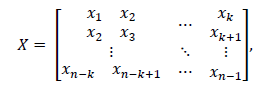

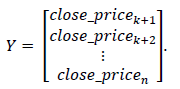

## **Check different amount of features**

### One feat - close_price

In [ ]:
lstm_neurons, lr, mins = 24, 0.001, 1
X_n_train, y_n_train, X_n_val, y_n_val, X_n_test, y_n_test = build_data(parsed_klines, mins,
                                                                        df_start=430000,
                                                                        columns=[OPR],
                                                                        smoothing_window_size=200000)
build_compile_fit_model(lstm_neurons, lr,
                        f'model_{mins}_mins_11/', 10,
                        X_n_train, y_n_train, X_n_val, y_n_val)
model_1_min_11 = load_model(f'model_{mins}_mins_11/')

WRONG DATA Empty DataFrame
Columns: [date, OPEN TIME, OPEN PRICE, HIGH PRICE, LOW PRICE, CLOSE PRICE, VOLUME, TRADES NUMBER, TAKER, Day Time sin, Week Day sin]
Index: []
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 24)                2496      
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 2,521
Trainable params: 2,521
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
3748/3748 [==============================] - ETA: 0s - loss: 1.5297e-04 - root_mean_squared_error: 0.0124

3748/3748 [==============================] - 279s 72ms/step - loss: 1.5297e-04 - root_mean_squared_error: 0.0124 - val_loss: 1.3923e-05 - val_root_mean_squared_error: 0.0037
Epoch 2/10
3748/3748 [==============================] - 264s 70ms/step - loss: 7.2256e-06 - root_mean_squared_error: 0.0027 - val_loss: 1.9772e-05 - val_root_mean_squared_error: 0.0044
Epoch 3/10
3748/3748 [==============================] - ETA: 0s - loss: 5.3047e-06 - root_mean_squared_error: 0.0023

3748/3748 [==============================] - 271s 72ms/step - loss: 5.3047e-06 - root_mean_squared_error: 0.0023 - val_loss: 6.0134e-06 - val_root_mean_squared_error: 0.0025
Epoch 4/10
3748/3748 [==============================] - 265s 71ms/step - loss: 3.6855e-06 - root_mean_squared_error: 0.0019 - val_loss: 1.7294e-05 - val_root_mean_squared_error: 0.0042
Epoch 5/10
3748/3748 [==============================] - ETA: 0s - loss: 2.8540e-06 - root_mean_squared_error: 0.0017

3748/3748 [==============================] - 269s 72ms/step - loss: 2.8540e-06 - root_mean_squared_error: 0.0017 - val_loss: 3.1903e-06 - val_root_mean_squared_error: 0.0018
Epoch 6/10
3748/3748 [==============================] - 262s 70ms/step - loss: 2.3738e-06 - root_mean_squared_error: 0.0015 - val_loss: 4.3014e-06 - val_root_mean_squared_error: 0.0021
Epoch 7/10
3594/3748 [===========================>..] - ETA: 10s - loss: 2.2038e-06 - root_mean_squared_error: 0.0015

1250/1250 [==============================] - 22s 17ms/step
       Test Predictions   Actuals
0              0.760615  0.759664
1              0.760316  0.760115
2              0.760670  0.759803
3              0.760361  0.758197
4              0.758649  0.758191
...                 ...       ...
39965          0.723053  0.723299
39966          0.724055  0.722779
39967          0.723482  0.721894
39968          0.722494  0.721556
39969          0.722188  0.720575

[39970 rows x 2 columns]


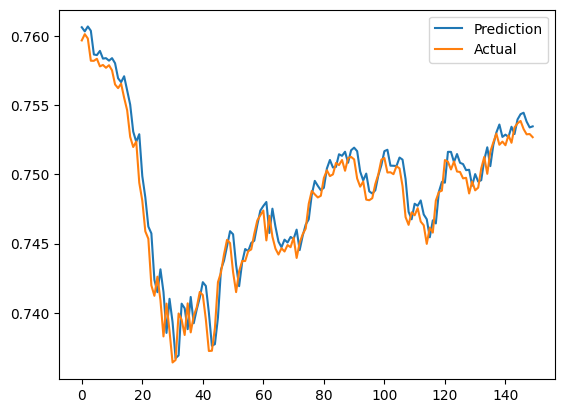

 mape: 0.0014096879373791632,
 mae: 0.0011042264615145087,
 mpe: 0.00044065486564952554,
 rmse: 0.0015858179486671555,
 corr: 0.9998974946119421,
r2_score: 0.9997629013199567,
 minmax: 
(0.0014096879373791632, 0.0011042264615145087, 0.00044065486564952554, 0.0015858179486671555, 0.9998974946119421, 0.9997629013199567)


In [ ]:
model_1_min_11 = load_model(f'model_{mins}_mins_11/')
get_predictions(model_1_min_11, X_n_test, y_n_test, 'Test')
#one_features_preds = model_1_min_11.predict(X_n_test).flatten()

### Four features - close_price, volume, trade_number, taker_volume

In [ ]:
lstm_neurons, lr, mins = 24, 0.001, 1
X_n_train, y_n_train, X_n_val, y_n_val, X_n_test, y_n_test = build_data(parsed_klines, mins,
                                                                        df_start=430000,
                                                                        columns=[OPR, VOL, TN, TAKER],
                                                                        smoothing_window_size=200000)
build_compile_fit_model(lstm_neurons, lr,
                        f'model_{mins}_mins_8/', 10,
                        X_n_train, y_n_train, X_n_val, y_n_val)

WRONG DATA Empty DataFrame
Columns: [date, OPEN TIME, OPEN PRICE, HIGH PRICE, LOW PRICE, CLOSE PRICE, VOLUME, TRADES NUMBER, TAKER, Day Time sin, Week Day sin]
Index: []


Exception ignored in: <function _xla_gc_callback at 0x7f7f04dda830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


KeyboardInterrupt: ignored

1250/1250 [==============================] - 20s 16ms/step
       Test Predictions   Actuals
0              0.759417  0.759664
1              0.759214  0.760115
2              0.759618  0.759803
3              0.759082  0.758197
4              0.758239  0.758191
...                 ...       ...
39965          0.722194  0.723299
39966          0.721801  0.722779
39967          0.721827  0.721894
39968          0.721480  0.721556
39969          0.720811  0.720575

[39970 rows x 2 columns]


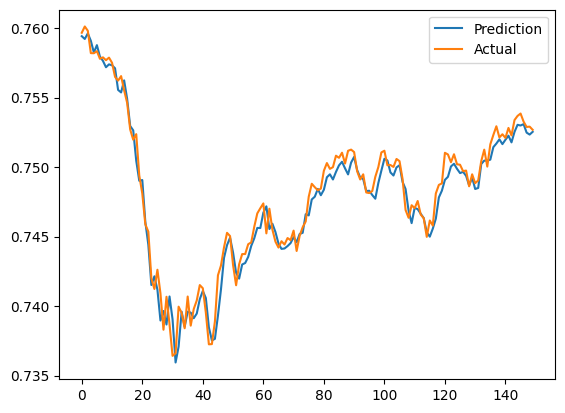

 mape: 0.0017716362913390317,
 mae: 0.0014786051960446146,
 mpe: -0.0012351249763799784,
 rmse: 0.0019730041251385063,
 corr: 0.9999351839530011,
r2_score: 0.9996329895208039,
 minmax: 
(0.0017716362913390317, 0.0014786051960446146, -0.0012351249763799784, 0.0019730041251385063, 0.9999351839530011, 0.9996329895208039)


In [ ]:
model_1_min_8 = load_model(f'model_{mins}_mins_8/')
get_predictions(model_1_min_8, X_n_test, y_n_test, 'Test')
#four_features_preds = model_1_min_8.predict(X_n_test).flatten()

### Six feat - close_price, high_price, low_price, volume, trade_number, taker_volume

In [ ]:
lstm_neurons, lr, mins = 24, 0.001, 1
X_n_train, y_n_train, X_n_val, y_n_val, X_n_test, y_n_test = build_data(parsed_klines, mins,
                                                                        df_start=430000,
                                                                        columns=[OPR, HPR, LPR, VOL, TN, TAKER],
                                                                        smoothing_window_size=200000)
build_compile_fit_model(lstm_neurons, lr,
                        f'model_{mins}_mins_10/', 10,
                        X_n_train, y_n_train, X_n_val, y_n_val)

WRONG DATA Empty DataFrame
Columns: [date, OPEN TIME, OPEN PRICE, HIGH PRICE, LOW PRICE, CLOSE PRICE, VOLUME, TRADES NUMBER, TAKER, Day Time sin, Week Day sin]
Index: []
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 24)                2976      
                                                                 
 dense_2 (Dense)             (None, 1)                 25        
                                                                 
Total params: 3,001
Trainable params: 3,001
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
3748/3748 [==============================] - ETA: 0s - loss: 9.3587e-05 - root_mean_squared_error: 0.0097

3748/3748 [==============================] - 279s 72ms/step - loss: 9.3587e-05 - root_mean_squared_error: 0.0097 - val_loss: 4.1836e-05 - val_root_mean_squared_error: 0.0065
Epoch 2/10
3748/3748 [==============================] - 263s 70ms/step - loss: 3.7547e-06 - root_mean_squared_error: 0.0019 - val_loss: 4.6206e-05 - val_root_mean_squared_error: 0.0068
Epoch 3/10
3747/3748 [============================>.] - ETA: 0s - loss: 2.4950e-06 - root_mean_squared_error: 0.0016

3748/3748 [==============================] - 275s 73ms/step - loss: 2.4949e-06 - root_mean_squared_error: 0.0016 - val_loss: 1.8436e-05 - val_root_mean_squared_error: 0.0043
Epoch 4/10
3748/3748 [==============================] - 266s 71ms/step - loss: 1.8887e-06 - root_mean_squared_error: 0.0014 - val_loss: 2.8733e-05 - val_root_mean_squared_error: 0.0054
Epoch 5/10
3748/3748 [==============================] - ETA: 0s - loss: 1.4165e-06 - root_mean_squared_error: 0.0012

3748/3748 [==============================] - 270s 72ms/step - loss: 1.4165e-06 - root_mean_squared_error: 0.0012 - val_loss: 9.5499e-06 - val_root_mean_squared_error: 0.0031
Epoch 6/10
3747/3748 [============================>.] - ETA: 0s - loss: 1.1111e-06 - root_mean_squared_error: 0.0011

3748/3748 [==============================] - 272s 73ms/step - loss: 1.1111e-06 - root_mean_squared_error: 0.0011 - val_loss: 8.9424e-07 - val_root_mean_squared_error: 9.4564e-04
Epoch 7/10
3748/3748 [==============================] - 270s 72ms/step - loss: 8.6480e-07 - root_mean_squared_error: 9.2995e-04 - val_loss: 1.8248e-06 - val_root_mean_squared_error: 0.0014
Epoch 8/10
3748/3748 [==============================] - 285s 76ms/step - loss: 8.0046e-07 - root_mean_squared_error: 8.9469e-04 - val_loss: 3.2244e-06 - val_root_mean_squared_error: 0.0018
Epoch 9/10
3748/3748 [==============================] - ETA: 0s - loss: 6.9911e-07 - root_mean_squared_error: 8.3613e-04

3748/3748 [==============================] - 271s 72ms/step - loss: 6.9911e-07 - root_mean_squared_error: 8.3613e-04 - val_loss: 8.5105e-07 - val_root_mean_squared_error: 9.2253e-04
Epoch 10/10
3748/3748 [==============================] - 279s 74ms/step - loss: 6.8236e-07 - root_mean_squared_error: 8.2605e-04 - val_loss: 3.0949e-06 - val_root_mean_squared_error: 0.0018


1250/1250 [==============================] - 22s 17ms/step
       Test Predictions   Actuals
0              0.760091  0.759664
1              0.760489  0.760115
2              0.760255  0.759803
3              0.758924  0.758197
4              0.757721  0.758191
...                 ...       ...
39965          0.722085  0.723299
39966          0.721993  0.722779
39967          0.722082  0.721894
39968          0.720982  0.721556
39969          0.720207  0.720575

[39970 rows x 2 columns]


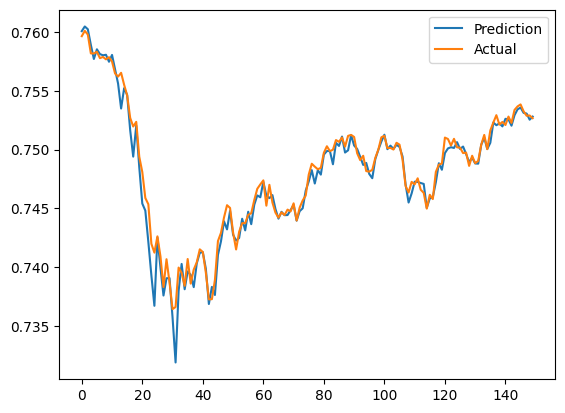

 mape: 0.000729238611544925,
 mae: 0.0005841286228267956,
 mpe: -0.000299701584299254,
 rmse: 0.0010354548468180002,
 corr: 0.9999520079824944,
r2_score: 0.999898915443763,
 minmax: 
(0.000729238611544925, 0.0005841286228267956, -0.000299701584299254, 0.0010354548468180002, 0.9999520079824944, 0.999898915443763)


In [ ]:
model_1_min_10 = load_model(f'model_{mins}_mins_10/')
get_predictions(model_1_min_10, X_n_test, y_n_test, 'Test')
#six_features_preds = model_1_min_10.predict(X_n_test).flatten()

### Eight features - close_price, high_price, low_price, volume, trade_number, taker_volume, day_sin, week_sin

In [ ]:
lstm_neurons, lr, mins = 24, 0.001, 1
X_n_train, y_n_train, X_n_val, y_n_val, X_n_test, y_n_test = build_data(parsed_klines, mins,
                                                                        df_start=430000,
                                                                        columns=[OPR, HPR, LPR, VOL, TN, TAKER, TSIN, DSIN],
                                                                        smoothing_window_size=200000)
build_compile_fit_model(lstm_neurons, lr,
                        f'model_{mins}_mins_9/', 10,
                        X_n_train, y_n_train, X_n_val, y_n_val)

WRONG DATA Empty DataFrame
Columns: [date, OPEN TIME, OPEN PRICE, HIGH PRICE, LOW PRICE, CLOSE PRICE, VOLUME, TRADES NUMBER, TAKER, Day Time sin, Week Day sin]
Index: []
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 24)                3168      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 3,193
Trainable params: 3,193
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
3747/3748 [============================>.] - ETA: 0s - loss: 2.7458e-04 - root_mean_squared_error: 0.0166

3748/3748 [==============================] - 280s 73ms/step - loss: 2.7457e-04 - root_mean_squared_error: 0.0166 - val_loss: 3.9361e-04 - val_root_mean_squared_error: 0.0198
Epoch 2/10
3747/3748 [============================>.] - ETA: 0s - loss: 5.9352e-06 - root_mean_squared_error: 0.0024

3748/3748 [==============================] - 270s 72ms/step - loss: 5.9349e-06 - root_mean_squared_error: 0.0024 - val_loss: 4.3354e-05 - val_root_mean_squared_error: 0.0066
Epoch 3/10
3747/3748 [============================>.] - ETA: 0s - loss: 3.9692e-06 - root_mean_squared_error: 0.0020

3748/3748 [==============================] - 269s 72ms/step - loss: 3.9708e-06 - root_mean_squared_error: 0.0020 - val_loss: 9.3183e-06 - val_root_mean_squared_error: 0.0031
Epoch 4/10
3748/3748 [==============================] - ETA: 0s - loss: 3.0536e-06 - root_mean_squared_error: 0.0017

3748/3748 [==============================] - 272s 73ms/step - loss: 3.0536e-06 - root_mean_squared_error: 0.0017 - val_loss: 8.2801e-06 - val_root_mean_squared_error: 0.0029
Epoch 5/10
3748/3748 [==============================] - 266s 71ms/step - loss: 2.2641e-06 - root_mean_squared_error: 0.0015 - val_loss: 1.1628e-05 - val_root_mean_squared_error: 0.0034
Epoch 6/10
3748/3748 [==============================] - 267s 71ms/step - loss: 1.9226e-06 - root_mean_squared_error: 0.0014 - val_loss: 1.0336e-05 - val_root_mean_squared_error: 0.0032
Epoch 7/10
3748/3748 [==============================] - 268s 71ms/step - loss: 1.4860e-06 - root_mean_squared_error: 0.0012 - val_loss: 1.4377e-05 - val_root_mean_squared_error: 0.0038
Epoch 8/10
3748/3748 [==============================] - 275s 73ms/step - loss: 1.3027e-06 - root_mean_squared_error: 0.0011 - val_loss: 9.8860e-06 - val_root_mean_squared_error: 0.0031
Epoch 9/10
3747/3748 [============================>.] - ETA: 0s - loss: 1.1424e-06 - r

3748/3748 [==============================] - 277s 74ms/step - loss: 1.1424e-06 - root_mean_squared_error: 0.0011 - val_loss: 3.9110e-06 - val_root_mean_squared_error: 0.0020
Epoch 10/10
3748/3748 [==============================] - ETA: 0s - loss: 9.5850e-07 - root_mean_squared_error: 9.7903e-04

3748/3748 [==============================] - 277s 74ms/step - loss: 9.5850e-07 - root_mean_squared_error: 9.7903e-04 - val_loss: 1.7725e-06 - val_root_mean_squared_error: 0.0013


1250/1250 [==============================] - 20s 16ms/step
       Test Predictions   Actuals
0              0.757963  0.759664
1              0.758533  0.760115
2              0.758201  0.759803
3              0.756970  0.758197
4              0.756098  0.758191
...                 ...       ...
39965          0.723038  0.723299
39966          0.720812  0.722779
39967          0.720988  0.721894
39968          0.720448  0.721556
39969          0.719333  0.720575

[39970 rows x 2 columns]


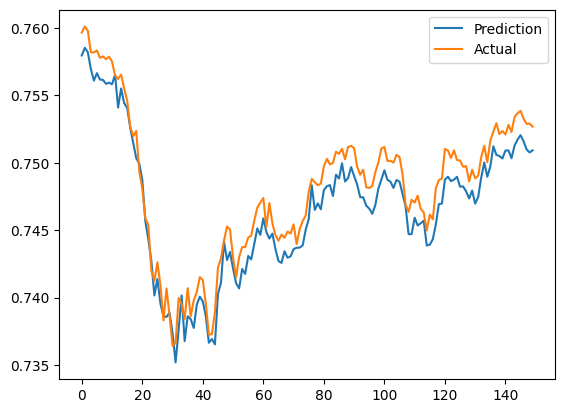

 mape: 0.0018773508460325963,
 mae: 0.001572474376047561,
 mpe: -0.001471698242847773,
 rmse: 0.0020694171229018203,
 corr: 0.9999382468180656,
r2_score: 0.9995962444039524,
 minmax: 
(0.0018773508460325963, 0.001572474376047561, -0.001471698242847773, 0.0020694171229018203, 0.9999382468180656, 0.9995962444039524)


In [ ]:
model_1_min_9 = load_model(f'model_{mins}_mins_9/')
get_predictions(model_1_min_9, X_n_test, y_n_test, 'Test')
#eight_features_preds = model_1_min_9.predict(X_n_test).flatten()

In [ ]:
eight_features_preds

array([0.7588434 , 0.75953245, 0.759055  , ..., 0.72188807, 0.7210201 ,
       0.72018135], dtype=float32)

### PLOT

<function matplotlib.pyplot.show(close=None, block=None)>

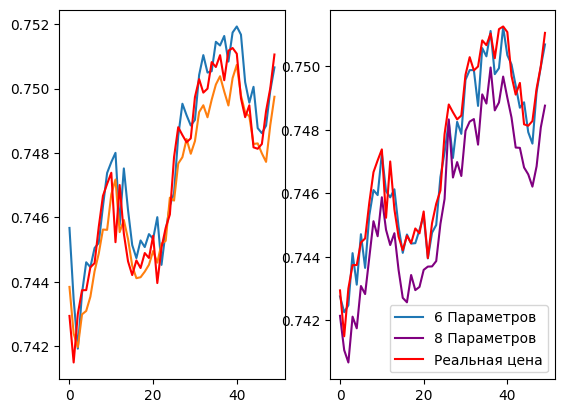

In [ ]:
fig, (ax, ax2) = plt.subplots(1, 2)
ax.plot(one_features_preds[50:100], label='1 Параметра')
ax.plot(four_features_preds[50:100], label='4 Параметра')
ax.plot(y_n_test[50:100], label='Реальная цена', color='red')

ax2.plot(six_features_preds[50:100], label='6 Параметров')
ax2.plot(eight_features_preds[50:100], label='8 Параметров', color='purple')
ax2.plot(y_n_test[50:100], label='Реальная цена', color='red')
plt.legend()
plt.show

### From test results best by rmse is model with six features

1 feature - 0.001585<br>
4 features - 0.001973<br>
6 features - 0.001035<br>
8 features - 0.002069

## **Find better hyperparameters**

### Find amount of epochs

In [ ]:
lstm_neurons, lr, mins = 24, 0.001, 1
X_n_train, y_n_train, X_n_val, y_n_val, X_n_test, y_n_test = build_data(parsed_klines, mins,
                                                                        df_start=430000,
                                                                        columns=[OPR, HPR, LPR, VOL, TN, TAKER],
                                                                        smoothing_window_size=200000,
                                                                        window_size=10)

WRONG DATA Empty DataFrame
Columns: [date, OPEN TIME, OPEN PRICE, HIGH PRICE, LOW PRICE, CLOSE PRICE, VOLUME, TRADES NUMBER, TAKER]
Index: []


In [ ]:
modelfit = build_compile_fit_model(lstm_neurons, lr,
                                   f'model_{mins}_mins/', 30,
                                   X_n_train, y_n_train, X_n_val, y_n_val)
model_one_min = load_model(f'model_{mins}_mins/')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 24)                2976      
                                                                 
 dense_2 (Dense)             (None, 1)                 25        
                                                                 
Total params: 3,001
Trainable params: 3,001
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
3748/3750 [============================>.] - ETA: 0s - loss: 1.4892e-04 - root_mean_squared_error: 0.0122

3750/3750 [==============================] - 51s 12ms/step - loss: 1.4885e-04 - root_mean_squared_error: 0.0122 - val_loss: 2.2104e-04 - val_root_mean_squared_error: 0.0149
Epoch 2/30
3748/3750 [============================>.] - ETA: 0s - loss: 3.8543e-06 - root_mean_squared_error: 0.0020

3750/3750 [==============================] - 41s 11ms/step - loss: 3.8552e-06 - root_mean_squared_error: 0.0020 - val_loss: 1.5628e-05 - val_root_mean_squared_error: 0.0040
Epoch 3/30
3750/3750 [==============================] - ETA: 0s - loss: 2.5338e-06 - root_mean_squared_error: 0.0016

3750/3750 [==============================] - 43s 12ms/step - loss: 2.5338e-06 - root_mean_squared_error: 0.0016 - val_loss: 7.7992e-06 - val_root_mean_squared_error: 0.0028
Epoch 4/30
3750/3750 [==============================] - 33s 9ms/step - loss: 1.9278e-06 - root_mean_squared_error: 0.0014 - val_loss: 1.1871e-05 - val_root_mean_squared_error: 0.0034
Epoch 5/30
3748/3750 [============================>.] - ETA: 0s - loss: 1.4801e-06 - root_mean_squared_error: 0.0012

3750/3750 [==============================] - 41s 11ms/step - loss: 1.4795e-06 - root_mean_squared_error: 0.0012 - val_loss: 1.5511e-06 - val_root_mean_squared_error: 0.0012
Epoch 6/30
3750/3750 [==============================] - 36s 10ms/step - loss: 1.2212e-06 - root_mean_squared_error: 0.0011 - val_loss: 5.3539e-06 - val_root_mean_squared_error: 0.0023
Epoch 7/30
3743/3750 [============================>.] - ETA: 0s - loss: 9.1638e-07 - root_mean_squared_error: 9.5728e-04

3750/3750 [==============================] - 40s 11ms/step - loss: 9.1561e-07 - root_mean_squared_error: 9.5688e-04 - val_loss: 6.2652e-07 - val_root_mean_squared_error: 7.9153e-04
Epoch 8/30
3750/3750 [==============================] - 33s 9ms/step - loss: 8.6655e-07 - root_mean_squared_error: 9.3089e-04 - val_loss: 6.4912e-07 - val_root_mean_squared_error: 8.0568e-04
Epoch 9/30
3750/3750 [==============================] - 36s 10ms/step - loss: 7.6216e-07 - root_mean_squared_error: 8.7302e-04 - val_loss: 8.3263e-07 - val_root_mean_squared_error: 9.1248e-04
Epoch 10/30
3750/3750 [==============================] - 35s 9ms/step - loss: 6.8826e-07 - root_mean_squared_error: 8.2962e-04 - val_loss: 2.3304e-06 - val_root_mean_squared_error: 0.0015
Epoch 11/30
3743/3750 [============================>.] - ETA: 0s - loss: 6.8999e-07 - root_mean_squared_error: 8.3066e-04

3750/3750 [==============================] - 39s 10ms/step - loss: 6.8960e-07 - root_mean_squared_error: 8.3042e-04 - val_loss: 5.9946e-07 - val_root_mean_squared_error: 7.7425e-04
Epoch 12/30
3750/3750 [==============================] - 33s 9ms/step - loss: 6.4128e-07 - root_mean_squared_error: 8.0080e-04 - val_loss: 6.5308e-07 - val_root_mean_squared_error: 8.0814e-04
Epoch 13/30
3750/3750 [==============================] - 33s 9ms/step - loss: 6.3628e-07 - root_mean_squared_error: 7.9767e-04 - val_loss: 1.0100e-06 - val_root_mean_squared_error: 0.0010
Epoch 14/30
3750/3750 [==============================] - 33s 9ms/step - loss: 5.9029e-07 - root_mean_squared_error: 7.6830e-04 - val_loss: 8.4645e-07 - val_root_mean_squared_error: 9.2003e-04
Epoch 15/30
3750/3750 [==============================] - 32s 9ms/step - loss: 6.2543e-07 - root_mean_squared_error: 7.9084e-04 - val_loss: 3.0494e-06 - val_root_mean_squared_error: 0.0017
Epoch 16/30
3750/3750 [==============================] - 35

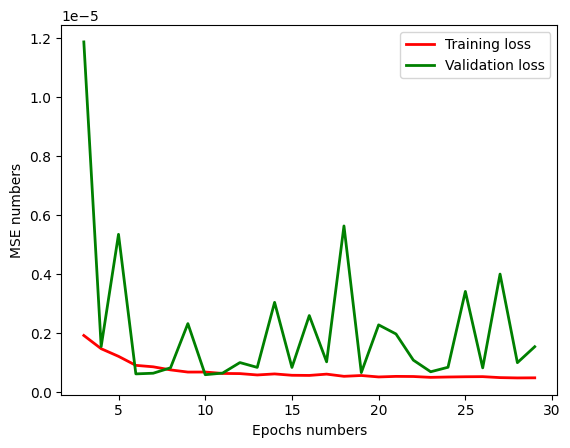

In [ ]:
build_loss_plot(modelfit)

20 epochs is maximum for this model

1250/1250 [==============================] - 4s 3ms/step
       Test Predictions   Actuals
0              0.757336  0.757524
1              0.758223  0.757470
2              0.757497  0.758025
3              0.757383  0.756777
4              0.756599  0.757000
...                 ...       ...
39993          0.723068  0.723299
39994          0.722953  0.722779
39995          0.722248  0.721894
39996          0.721264  0.721556
39997          0.720635  0.720575

[39998 rows x 2 columns]


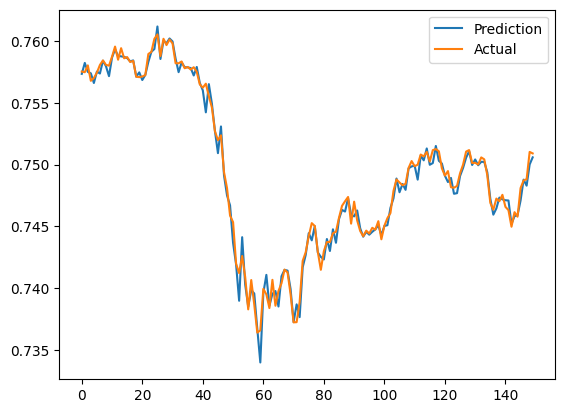

 mape: 0.0007027453810690189,
 mae: 0.000572371200001488,
 mpe: -0.0002496844519048588,
 rmse: 0.0008675897812939669,
 corr: 0.9999717095848716,
r2_score: 0.9999289884704653,
 minmax: 
(0.0007027453810690189, 0.000572371200001488, -0.0002496844519048588, 0.0008675897812939669, 0.9999717095848716, 0.9999289884704653)


In [ ]:
#Check on 1min model for 1 min pred
model_one_min = load_model(f'model_{mins}_mins/')
get_predictions(model_one_min, X_n_test, y_n_test, 'Test')

### Find amount of neurons and learning rate

So, model with 6 parameters has the best result. Continue with it

In [ ]:
build_compile_fit_model(lstm_neurons, lr,
                        f'model_{mins}_mins_3/', 10,
                        X_n_train, y_n_train, X_n_val, y_n_val)
model_1_min_3 = load_model('model_1_mins_3/')

In [ ]:
mins = 1

X_n_train, y_n_train, X_n_val, y_n_val, X_n_test, y_n_test = build_data(
    parsed_klines, mins,
    df_start=430000, df_size=200000,
    columns=[OPR, HPR, LPR, VOL, TN, TAKER],
    smoothing_window_size=200000
)
smooth_data(parsed_klines[CPR][430000:630000].copy().values.reshape(-1, 1), smoothing_window_size=200000)

WRONG DATA Empty DataFrame
Columns: [date, OPEN TIME, OPEN PRICE, HIGH PRICE, LOW PRICE, CLOSE PRICE, VOLUME, TRADES NUMBER, TAKER, Difference, Direction, Absolute Difference]
Index: []


array([[0.37757914],
       [0.37837099],
       [0.37954641],
       ...,
       [0.72155641],
       [0.72057535],
       [0.72094865]])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 4)                 176       
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
3748/3748 [==============================] - ETA: 0s - loss: 9.1908e-05 - root_mean_squared_error: 0.0096

3748/3748 [==============================] - 252s 66ms/step - loss: 9.1908e-05 - root_mean_squared_error: 0.0096 - val_loss: 5.7740e-04 - val_root_mean_squared_error: 0.0240
Epoch 2/10
3748/3748 [==============================] - ETA: 0s - loss: 3.6055e-06 - root_mean_squared_error: 0.0019

3748/3748 [==============================] - 244s 65ms/step - loss: 3.6055e-06 - root_mean_squared_error: 0.0019 - val_loss: 1.2141e-04 - val_root_mean_squared_error: 0.0110
Epoch 3/10
3748/3748 [==============================] - ETA: 0s - loss: 2.3855e-06 - root_mean_squared_error: 0.0015

3748/3748 [==============================] - 239s 64ms/step - loss: 2.3855e-06 - root_mean_squared_error: 0.0015 - val_loss: 4.9027e-05 - val_root_mean_squared_error: 0.0070
Epoch 4/10
3747/3748 [============================>.] - ETA: 0s - loss: 1.9099e-06 - root_mean_squared_error: 0.0014

3748/3748 [==============================] - 250s 67ms/step - loss: 1.9098e-06 - root_mean_squared_error: 0.0014 - val_loss: 3.7023e-05 - val_root_mean_squared_error: 0.0061
Epoch 5/10
3748/3748 [==============================] - ETA: 0s - loss: 1.7479e-06 - root_mean_squared_error: 0.0013

3748/3748 [==============================] - 243s 65ms/step - loss: 1.7479e-06 - root_mean_squared_error: 0.0013 - val_loss: 3.2348e-05 - val_root_mean_squared_error: 0.0057
Epoch 6/10
3748/3748 [==============================] - 236s 63ms/step - loss: 1.6363e-06 - root_mean_squared_error: 0.0013 - val_loss: 3.7260e-05 - val_root_mean_squared_error: 0.0061
Epoch 7/10
3747/3748 [============================>.] - ETA: 0s - loss: 1.4693e-06 - root_mean_squared_error: 0.0012

3748/3748 [==============================] - 242s 65ms/step - loss: 1.4692e-06 - root_mean_squared_error: 0.0012 - val_loss: 2.6733e-05 - val_root_mean_squared_error: 0.0052
Epoch 8/10
3748/3748 [==============================] - 236s 63ms/step - loss: 1.4162e-06 - root_mean_squared_error: 0.0012 - val_loss: 4.9308e-05 - val_root_mean_squared_error: 0.0070
Epoch 9/10
3748/3748 [==============================] - 245s 65ms/step - loss: 1.3346e-06 - root_mean_squared_error: 0.0012 - val_loss: 3.2316e-05 - val_root_mean_squared_error: 0.0057
Epoch 10/10
1250/1250 [==============================] - 16s 13ms/step
       Test Predictions   Actuals
0          22864.869141  22905.32
1          22866.181641  22902.29
2          22860.216797  22886.67
3          22852.662109  22886.61
4          22859.167969  22888.05
...                 ...       ...
39965      22515.632812  22542.26
39966      22517.791016  22533.65
39967      22514.212891  22530.37
39968      22504.011719  22520.83
39969      

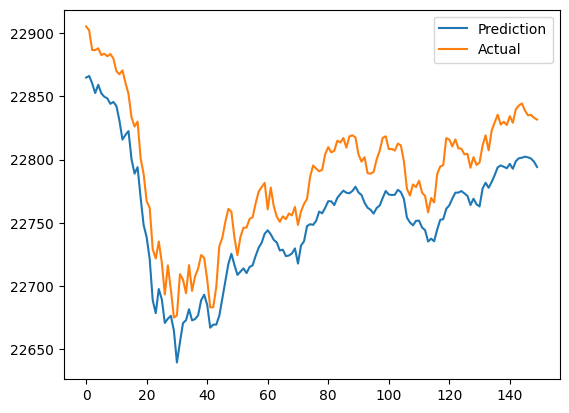

 mape: 0.003781368238890691,
wape: 0.9960726532536494,
mae: 91.05150536535214,
 mpe: -0.0036997425567344266,
 rmse: 127.21071002274196,
 corr: 0.9995033851080466,
r2_score:0.9838652665496816 minmax: 
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 4)                 176       
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
3748/3748 [==============================] - ETA: 0s - loss: 2.7967e-05 - root_mean_squared_error: 0.0053

3748/3748 [==============================] - 256s 68ms/step - loss: 2.7967e-05 - root_mean_squared_error: 0.0053 - val_loss: 6.4449e-04 - val_root_mean_squared_error: 0.0254
Epoch 2/10
3747/3748 [============================>.] - ETA: 0s - loss: 3.6284e-06 - root_mean_squared_error: 0.0019

3748/3748 [==============================] - 244s 65ms/step - loss: 3.6283e-06 - root_mean_squared_error: 0.0019 - val_loss: 3.1035e-04 - val_root_mean_squared_error: 0.0176
Epoch 3/10
3747/3748 [============================>.] - ETA: 0s - loss: 2.1782e-06 - root_mean_squared_error: 0.0015

3748/3748 [==============================] - 252s 67ms/step - loss: 2.1781e-06 - root_mean_squared_error: 0.0015 - val_loss: 2.2689e-04 - val_root_mean_squared_error: 0.0151
Epoch 4/10
3748/3748 [==============================] - ETA: 0s - loss: 1.8266e-06 - root_mean_squared_error: 0.0014

3748/3748 [==============================] - 246s 66ms/step - loss: 1.8266e-06 - root_mean_squared_error: 0.0014 - val_loss: 1.7306e-04 - val_root_mean_squared_error: 0.0132
Epoch 5/10
3748/3748 [==============================] - ETA: 0s - loss: 1.6665e-06 - root_mean_squared_error: 0.0013

3748/3748 [==============================] - 246s 66ms/step - loss: 1.6665e-06 - root_mean_squared_error: 0.0013 - val_loss: 1.5102e-04 - val_root_mean_squared_error: 0.0123
Epoch 6/10
3748/3748 [==============================] - ETA: 0s - loss: 1.5457e-06 - root_mean_squared_error: 0.0012

3748/3748 [==============================] - 247s 66ms/step - loss: 1.5457e-06 - root_mean_squared_error: 0.0012 - val_loss: 1.0751e-04 - val_root_mean_squared_error: 0.0104
Epoch 7/10
3748/3748 [==============================] - 246s 66ms/step - loss: 1.4600e-06 - root_mean_squared_error: 0.0012 - val_loss: 1.1990e-04 - val_root_mean_squared_error: 0.0110
Epoch 8/10
3747/3748 [============================>.] - ETA: 0s - loss: 1.3834e-06 - root_mean_squared_error: 0.0012

3748/3748 [==============================] - 249s 67ms/step - loss: 1.3835e-06 - root_mean_squared_error: 0.0012 - val_loss: 9.5779e-05 - val_root_mean_squared_error: 0.0098
Epoch 9/10
3747/3748 [============================>.] - ETA: 0s - loss: 1.3343e-06 - root_mean_squared_error: 0.0012

3748/3748 [==============================] - 251s 67ms/step - loss: 1.3343e-06 - root_mean_squared_error: 0.0012 - val_loss: 9.2995e-05 - val_root_mean_squared_error: 0.0096
Epoch 10/10
3747/3748 [============================>.] - ETA: 0s - loss: 1.2829e-06 - root_mean_squared_error: 0.0011

1250/1250 [==============================] - 17s 13ms/step
       Test Predictions   Actuals
0          22826.378906  22905.32
1          22825.716797  22902.29
2          22820.416016  22886.67
3          22818.064453  22886.61
4          22817.826172  22888.05
...                 ...       ...
39965      22484.125000  22542.26
39966      22483.382812  22533.65
39967      22480.585938  22530.37
39968      22474.619141  22520.83
39969      22477.466797  22524.46

[39970 rows x 2 columns]


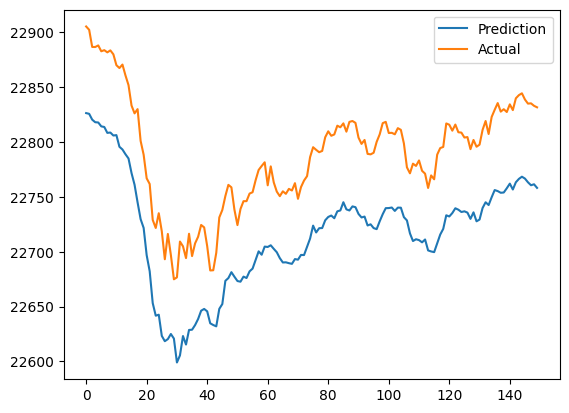

 mape: 0.005889713540327851,
wape: 0.9939095176887582,
mae: 141.2015843405992,
 mpe: -0.005884798350513028,
 rmse: 184.8182165358569,
 corr: 0.9993717891203695,
r2_score:0.9659431879957672 minmax: 
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 4)                 176       
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
3748/3748 [==============================] - ETA: 0s - loss: 0.0743 - root_mean_squared_error: 0.2726

3748/3748 [==============================] - 258s 68ms/step - loss: 0.0743 - root_mean_squared_error: 0.2726 - val_loss: 0.4001 - val_root_mean_squared_error: 0.6325
Epoch 2/10
3748/3748 [==============================] - ETA: 0s - loss: 0.0316 - root_mean_squared_error: 0.1778

3748/3748 [==============================] - 263s 70ms/step - loss: 0.0316 - root_mean_squared_error: 0.1778 - val_loss: 0.1777 - val_root_mean_squared_error: 0.4216
Epoch 3/10
3748/3748 [==============================] - ETA: 0s - loss: 0.0112 - root_mean_squared_error: 0.1060

3748/3748 [==============================] - 253s 68ms/step - loss: 0.0112 - root_mean_squared_error: 0.1060 - val_loss: 0.0843 - val_root_mean_squared_error: 0.2904
Epoch 4/10
3747/3748 [============================>.] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0520

3748/3748 [==============================] - 252s 67ms/step - loss: 0.0027 - root_mean_squared_error: 0.0520 - val_loss: 0.0407 - val_root_mean_squared_error: 0.2017
Epoch 5/10
3748/3748 [==============================] - ETA: 0s - loss: 3.5819e-04 - root_mean_squared_error: 0.0189

3748/3748 [==============================] - 250s 67ms/step - loss: 3.5819e-04 - root_mean_squared_error: 0.0189 - val_loss: 0.0232 - val_root_mean_squared_error: 0.1525
Epoch 6/10
3748/3748 [==============================] - ETA: 0s - loss: 1.4515e-04 - root_mean_squared_error: 0.0120

3748/3748 [==============================] - 252s 67ms/step - loss: 1.4515e-04 - root_mean_squared_error: 0.0120 - val_loss: 0.0157 - val_root_mean_squared_error: 0.1255
Epoch 7/10
3748/3748 [==============================] - ETA: 0s - loss: 7.7594e-05 - root_mean_squared_error: 0.0088

3748/3748 [==============================] - 253s 67ms/step - loss: 7.7594e-05 - root_mean_squared_error: 0.0088 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1064
Epoch 8/10
3748/3748 [==============================] - ETA: 0s - loss: 5.2712e-05 - root_mean_squared_error: 0.0073

3748/3748 [==============================] - 258s 69ms/step - loss: 5.2712e-05 - root_mean_squared_error: 0.0073 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0941
Epoch 9/10
3748/3748 [==============================] - ETA: 0s - loss: 3.8866e-05 - root_mean_squared_error: 0.0062

3748/3748 [==============================] - 261s 70ms/step - loss: 3.8866e-05 - root_mean_squared_error: 0.0062 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0836
Epoch 10/10
3748/3748 [==============================] - ETA: 0s - loss: 2.9621e-05 - root_mean_squared_error: 0.0054

1250/1250 [==============================] - 17s 13ms/step
       Test Predictions   Actuals
0          22113.505859  22905.32
1          22110.394531  22902.29
2          22098.699219  22886.67
3          22111.677734  22886.61
4          22119.888672  22888.05
...                 ...       ...
39965      21965.113281  22542.26
39966      21965.222656  22533.65
39967      21986.464844  22530.37
39968      21966.033203  22520.83
39969      21968.259766  22524.46

[39970 rows x 2 columns]


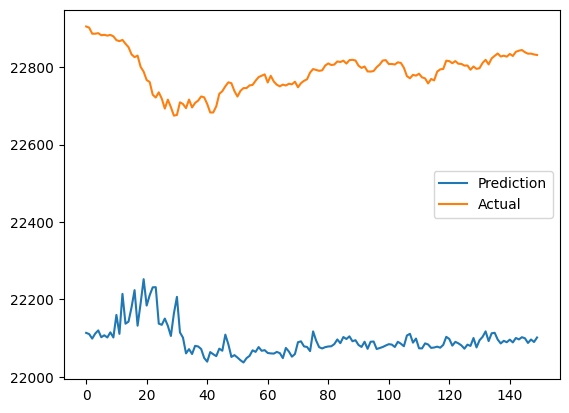

 mape: 0.04317835531957446,
wape: 0.9557337832982697,
mae: 1026.2668228280586,
 mpe: -0.04317493948143802,
 rmse: 1208.6256389464097,
 corr: 0.9694163800239665,
r2_score:-0.45645827567618813 minmax: 
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 8)                 480       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 489
Trainable params: 489
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
3748/3748 [==============================] - ETA: 0s - loss: 2.8096e-04 - root_mean_squared_error: 0.0168

3748/3748 [==============================] - 270s 71ms/step - loss: 2.8096e-04 - root_mean_squared_error: 0.0168 - val_loss: 3.3517e-04 - val_root_mean_squared_error: 0.0183
Epoch 2/10
3748/3748 [==============================] - ETA: 0s - loss: 3.6955e-06 - root_mean_squared_error: 0.0019

3748/3748 [==============================] - 266s 71ms/step - loss: 3.6955e-06 - root_mean_squared_error: 0.0019 - val_loss: 7.5336e-06 - val_root_mean_squared_error: 0.0027
Epoch 3/10
3748/3748 [==============================] - 259s 69ms/step - loss: 2.6864e-06 - root_mean_squared_error: 0.0016 - val_loss: 2.6608e-05 - val_root_mean_squared_error: 0.0052
Epoch 4/10
3748/3748 [==============================] - 261s 70ms/step - loss: 2.1577e-06 - root_mean_squared_error: 0.0015 - val_loss: 1.2230e-05 - val_root_mean_squared_error: 0.0035
Epoch 5/10
3748/3748 [==============================] - ETA: 0s - loss: 1.8912e-06 - root_mean_squared_error: 0.0014

3748/3748 [==============================] - 271s 72ms/step - loss: 1.8912e-06 - root_mean_squared_error: 0.0014 - val_loss: 5.6767e-06 - val_root_mean_squared_error: 0.0024
Epoch 6/10
3748/3748 [==============================] - 262s 70ms/step - loss: 1.6482e-06 - root_mean_squared_error: 0.0013 - val_loss: 1.0402e-05 - val_root_mean_squared_error: 0.0032
Epoch 7/10
3748/3748 [==============================] - ETA: 0s - loss: 1.5033e-06 - root_mean_squared_error: 0.0012

3748/3748 [==============================] - 273s 73ms/step - loss: 1.5033e-06 - root_mean_squared_error: 0.0012 - val_loss: 4.1509e-06 - val_root_mean_squared_error: 0.0020
Epoch 8/10
3748/3748 [==============================] - 267s 71ms/step - loss: 1.3692e-06 - root_mean_squared_error: 0.0012 - val_loss: 1.7996e-05 - val_root_mean_squared_error: 0.0042
Epoch 9/10
3748/3748 [==============================] - 265s 71ms/step - loss: 1.2901e-06 - root_mean_squared_error: 0.0011 - val_loss: 1.9018e-05 - val_root_mean_squared_error: 0.0044
Epoch 10/10
1250/1250 [==============================] - 21s 16ms/step
       Test Predictions   Actuals
0          22905.406250  22905.32
1          22905.285156  22902.29
2          22899.683594  22886.67
3          22894.593750  22886.61
4          22894.841797  22888.05
...                 ...       ...
39965      22544.822266  22542.26
39966      22548.199219  22533.65
39967      22543.441406  22530.37
39968      22535.193359  22520.83
39969      

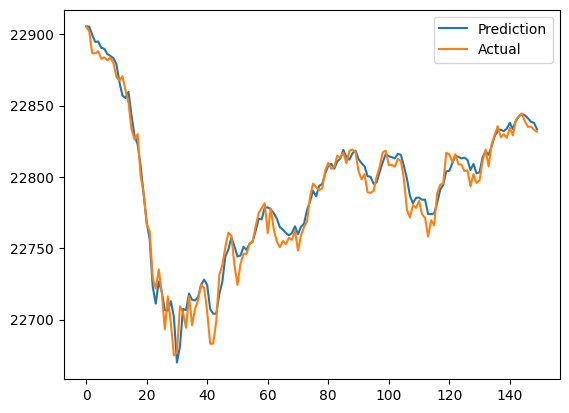

 mape: 0.0016301895845109895,
wape: 0.9983138326418902,
mae: 39.09206040858768,
 mpe: -0.0010906576644348729,
 rmse: 57.53557584097874,
 corr: 0.9997482698225458,
r2_score:0.9966994419916725 minmax: 
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 8)                 480       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 489
Trainable params: 489
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
3748/3748 [==============================] - ETA: 0s - loss: 0.0115 - root_mean_squared_error: 0.1073

3748/3748 [==============================] - 269s 71ms/step - loss: 0.0115 - root_mean_squared_error: 0.1073 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1107
Epoch 2/10
3748/3748 [==============================] - ETA: 0s - loss: 6.0047e-05 - root_mean_squared_error: 0.0077

3748/3748 [==============================] - 274s 73ms/step - loss: 6.0047e-05 - root_mean_squared_error: 0.0077 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0807
Epoch 3/10
3748/3748 [==============================] - ETA: 0s - loss: 2.0982e-05 - root_mean_squared_error: 0.0046

3748/3748 [==============================] - 275s 73ms/step - loss: 2.0982e-05 - root_mean_squared_error: 0.0046 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0455
Epoch 4/10
3748/3748 [==============================] - ETA: 0s - loss: 1.0152e-05 - root_mean_squared_error: 0.0032

3748/3748 [==============================] - 273s 73ms/step - loss: 1.0152e-05 - root_mean_squared_error: 0.0032 - val_loss: 6.3537e-04 - val_root_mean_squared_error: 0.0252
Epoch 5/10
3748/3748 [==============================] - ETA: 0s - loss: 6.6148e-06 - root_mean_squared_error: 0.0026

3748/3748 [==============================] - 267s 71ms/step - loss: 6.6148e-06 - root_mean_squared_error: 0.0026 - val_loss: 3.2875e-04 - val_root_mean_squared_error: 0.0181
Epoch 6/10
3748/3748 [==============================] - ETA: 0s - loss: 5.1204e-06 - root_mean_squared_error: 0.0023

3748/3748 [==============================] - 262s 70ms/step - loss: 5.1204e-06 - root_mean_squared_error: 0.0023 - val_loss: 1.8233e-04 - val_root_mean_squared_error: 0.0135
Epoch 7/10
3748/3748 [==============================] - ETA: 0s - loss: 4.2640e-06 - root_mean_squared_error: 0.0021

3748/3748 [==============================] - 267s 71ms/step - loss: 4.2640e-06 - root_mean_squared_error: 0.0021 - val_loss: 1.2019e-04 - val_root_mean_squared_error: 0.0110
Epoch 8/10
3748/3748 [==============================] - ETA: 0s - loss: 3.6373e-06 - root_mean_squared_error: 0.0019

3748/3748 [==============================] - 269s 72ms/step - loss: 3.6373e-06 - root_mean_squared_error: 0.0019 - val_loss: 7.0976e-05 - val_root_mean_squared_error: 0.0084
Epoch 9/10
3748/3748 [==============================] - ETA: 0s - loss: 3.1665e-06 - root_mean_squared_error: 0.0018

3748/3748 [==============================] - 265s 71ms/step - loss: 3.1665e-06 - root_mean_squared_error: 0.0018 - val_loss: 6.1249e-05 - val_root_mean_squared_error: 0.0078
Epoch 10/10
1250/1250 [==============================] - 18s 14ms/step
       Test Predictions   Actuals
0          22828.824219  22905.32
1          22829.871094  22902.29
2          22828.042969  22886.67
3          22827.345703  22886.61
4          22826.847656  22888.05
...                 ...       ...
39965      22488.875000  22542.26
39966      22489.871094  22533.65
39967      22494.962891  22530.37
39968      22493.019531  22520.83
39969      22489.605469  22524.46

[39970 rows x 2 columns]


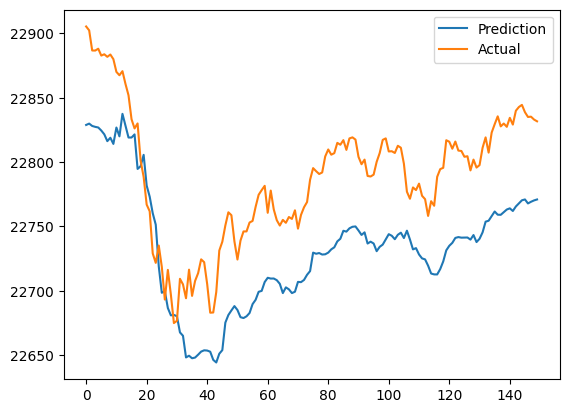

 mape: 0.005372529438247394,
wape: 0.9944390986261176,
mae: 128.92379358933263,
 mpe: -0.005318751075679744,
 rmse: 172.13380589279063,
 corr: 0.999131844082588,
r2_score:0.9704575312918777 minmax: 
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 8)                 480       
                                                                 
 dense_6 (Dense)             (None, 1)                 9         
                                                                 
Total params: 489
Trainable params: 489
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
3748/3748 [==============================] - ETA: 0s - loss: 0.0424 - root_mean_squared_error: 0.2060

3748/3748 [==============================] - 274s 73ms/step - loss: 0.0424 - root_mean_squared_error: 0.2060 - val_loss: 0.0500 - val_root_mean_squared_error: 0.2237
Epoch 2/10
3748/3748 [==============================] - ETA: 0s - loss: 0.0025 - root_mean_squared_error: 0.0502

3748/3748 [==============================] - 273s 73ms/step - loss: 0.0025 - root_mean_squared_error: 0.0502 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0786
Epoch 3/10
3748/3748 [==============================] - ETA: 0s - loss: 5.6624e-04 - root_mean_squared_error: 0.0238

3748/3748 [==============================] - 270s 72ms/step - loss: 5.6624e-04 - root_mean_squared_error: 0.0238 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0574
Epoch 4/10
3748/3748 [==============================] - ETA: 0s - loss: 1.1997e-04 - root_mean_squared_error: 0.0110

3748/3748 [==============================] - 280s 75ms/step - loss: 1.1997e-04 - root_mean_squared_error: 0.0110 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0520
Epoch 5/10
3748/3748 [==============================] - ETA: 0s - loss: 5.1689e-05 - root_mean_squared_error: 0.0072

3748/3748 [==============================] - 279s 75ms/step - loss: 5.1689e-05 - root_mean_squared_error: 0.0072 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0489
Epoch 6/10
3748/3748 [==============================] - ETA: 0s - loss: 3.3580e-05 - root_mean_squared_error: 0.0058

3748/3748 [==============================] - 277s 74ms/step - loss: 3.3580e-05 - root_mean_squared_error: 0.0058 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0442
Epoch 7/10
3748/3748 [==============================] - ETA: 0s - loss: 2.2622e-05 - root_mean_squared_error: 0.0048

3748/3748 [==============================] - 273s 73ms/step - loss: 2.2622e-05 - root_mean_squared_error: 0.0048 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0395
Epoch 8/10
3748/3748 [==============================] - ETA: 0s - loss: 1.6112e-05 - root_mean_squared_error: 0.0040

3748/3748 [==============================] - 278s 74ms/step - loss: 1.6112e-05 - root_mean_squared_error: 0.0040 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0359
Epoch 9/10
3748/3748 [==============================] - ETA: 0s - loss: 1.2378e-05 - root_mean_squared_error: 0.0035

3748/3748 [==============================] - 273s 73ms/step - loss: 1.2378e-05 - root_mean_squared_error: 0.0035 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0328
Epoch 10/10
3748/3748 [==============================] - ETA: 0s - loss: 1.0257e-05 - root_mean_squared_error: 0.0032

1250/1250 [==============================] - 19s 14ms/step
       Test Predictions   Actuals
0          22578.843750  22905.32
1          22576.041016  22902.29
2          22568.355469  22886.67
3          22574.023438  22886.61
4          22575.412109  22888.05
...                 ...       ...
39965      22335.792969  22542.26
39966      22330.003906  22533.65
39967      22343.306641  22530.37
39968      22333.085938  22520.83
39969      22325.083984  22524.46

[39970 rows x 2 columns]


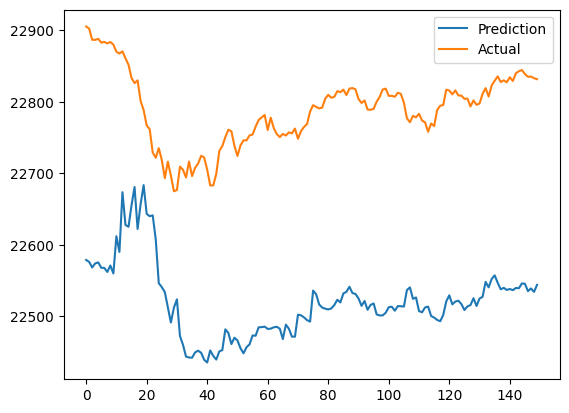

 mape: 0.017914925028609058,
wape: 0.9816122094917803,
mae: 426.3020594430198,
 mpe: -0.01790349137224583,
 rmse: 511.06780470063507,
 corr: 0.9959710176304988,
r2_score:0.7395817070404178 minmax: 
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 12)                912       
                                                                 
 dense_7 (Dense)             (None, 1)                 13        
                                                                 
Total params: 925
Trainable params: 925
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
3748/3748 [==============================] - ETA: 0s - loss: 1.2988e-04 - root_mean_squared_error: 0.0114

3748/3748 [==============================] - 284s 75ms/step - loss: 1.2988e-04 - root_mean_squared_error: 0.0114 - val_loss: 1.9926e-04 - val_root_mean_squared_error: 0.0141
Epoch 2/10
3748/3748 [==============================] - ETA: 0s - loss: 3.3528e-06 - root_mean_squared_error: 0.0018

3748/3748 [==============================] - 276s 74ms/step - loss: 3.3528e-06 - root_mean_squared_error: 0.0018 - val_loss: 6.6892e-05 - val_root_mean_squared_error: 0.0082
Epoch 3/10
3748/3748 [==============================] - ETA: 0s - loss: 2.4924e-06 - root_mean_squared_error: 0.0016

3748/3748 [==============================] - 275s 73ms/step - loss: 2.4924e-06 - root_mean_squared_error: 0.0016 - val_loss: 2.1372e-05 - val_root_mean_squared_error: 0.0046
Epoch 4/10
3748/3748 [==============================] - 275s 73ms/step - loss: 1.9567e-06 - root_mean_squared_error: 0.0014 - val_loss: 2.8297e-05 - val_root_mean_squared_error: 0.0053
Epoch 5/10
3748/3748 [==============================] - ETA: 0s - loss: 1.7320e-06 - root_mean_squared_error: 0.0013

3748/3748 [==============================] - 280s 75ms/step - loss: 1.7320e-06 - root_mean_squared_error: 0.0013 - val_loss: 1.2416e-05 - val_root_mean_squared_error: 0.0035
Epoch 6/10
3748/3748 [==============================] - 275s 73ms/step - loss: 1.4243e-06 - root_mean_squared_error: 0.0012 - val_loss: 4.4545e-05 - val_root_mean_squared_error: 0.0067
Epoch 7/10
3748/3748 [==============================] - 276s 74ms/step - loss: 1.2921e-06 - root_mean_squared_error: 0.0011 - val_loss: 3.2526e-05 - val_root_mean_squared_error: 0.0057
Epoch 8/10
3748/3748 [==============================] - ETA: 0s - loss: 1.1364e-06 - root_mean_squared_error: 0.0011

3748/3748 [==============================] - 276s 74ms/step - loss: 1.1364e-06 - root_mean_squared_error: 0.0011 - val_loss: 1.1976e-05 - val_root_mean_squared_error: 0.0035
Epoch 9/10
3748/3748 [==============================] - ETA: 0s - loss: 1.0562e-06 - root_mean_squared_error: 0.0010

3748/3748 [==============================] - 275s 73ms/step - loss: 1.0562e-06 - root_mean_squared_error: 0.0010 - val_loss: 1.1726e-05 - val_root_mean_squared_error: 0.0034
Epoch 10/10
3748/3748 [==============================] - ETA: 0s - loss: 9.9055e-07 - root_mean_squared_error: 9.9526e-04

1250/1250 [==============================] - 19s 15ms/step
       Test Predictions   Actuals
0          22892.806641  22905.32
1          22892.734375  22902.29
2          22883.638672  22886.67
3          22875.789062  22886.61
4          22877.630859  22888.05
...                 ...       ...
39965      22533.730469  22542.26
39966      22530.808594  22533.65
39967      22526.048828  22530.37
39968      22517.697266  22520.83
39969      22521.595703  22524.46

[39970 rows x 2 columns]


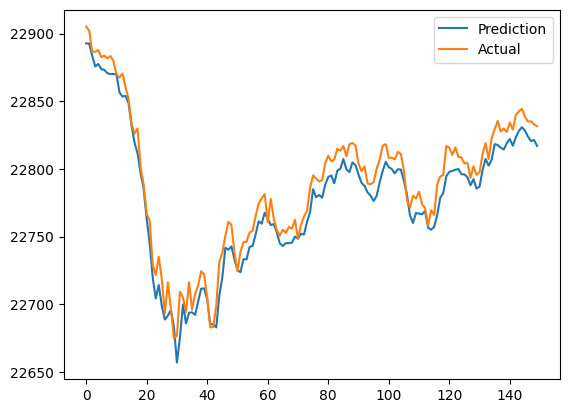

 mape: 0.0014037802271194449,
wape: 0.9985452659112118,
mae: 33.726517479906796,
 mpe: -0.0012874092927988466,
 rmse: 46.55399987545274,
 corr: 0.9999302759894064,
r2_score:0.9978391309753281 minmax: 
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 12)                912       
                                                                 
 dense_8 (Dense)             (None, 1)                 13        
                                                                 
Total params: 925
Trainable params: 925
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
3748/3748 [==============================] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0524

3748/3748 [==============================] - 290s 77ms/step - loss: 0.0027 - root_mean_squared_error: 0.0524 - val_loss: 3.1686e-04 - val_root_mean_squared_error: 0.0178
Epoch 2/10
3748/3748 [==============================] - ETA: 0s - loss: 1.0495e-05 - root_mean_squared_error: 0.0032

3748/3748 [==============================] - 281s 75ms/step - loss: 1.0495e-05 - root_mean_squared_error: 0.0032 - val_loss: 1.7218e-05 - val_root_mean_squared_error: 0.0041
Epoch 3/10
3748/3748 [==============================] - 276s 74ms/step - loss: 7.5099e-06 - root_mean_squared_error: 0.0027 - val_loss: 4.8659e-05 - val_root_mean_squared_error: 0.0070
Epoch 4/10
3748/3748 [==============================] - 279s 74ms/step - loss: 5.6209e-06 - root_mean_squared_error: 0.0024 - val_loss: 3.5789e-05 - val_root_mean_squared_error: 0.0060
Epoch 5/10
3748/3748 [==============================] - 283s 75ms/step - loss: 4.3237e-06 - root_mean_squared_error: 0.0021 - val_loss: 4.0961e-05 - val_root_mean_squared_error: 0.0064
Epoch 6/10
3748/3748 [==============================] - 279s 74ms/step - loss: 3.4853e-06 - root_mean_squared_error: 0.0019 - val_loss: 5.8881e-05 - val_root_mean_squared_error: 0.0077
Epoch 7/10
3748/3748 [==============================] - 282s 75ms/step - loss: 2.9168e

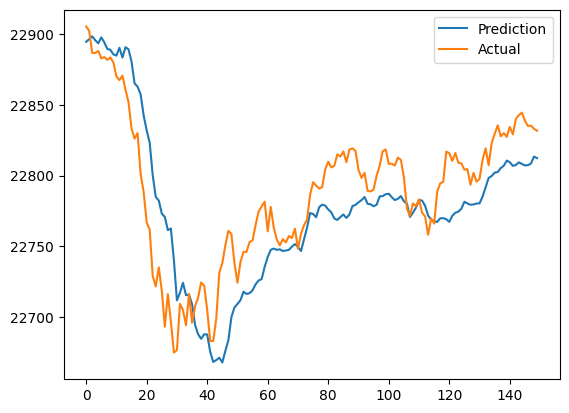

 mape: 0.003367815248429131,
wape: 0.9965304841130045,
mae: 80.43716656633099,
 mpe: -0.00289977357513012,
 rmse: 108.0034369743901,
 corr: 0.9990585329635322,
r2_score:0.9883697354322668 minmax: 
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 12)                912       
                                                                 
 dense_9 (Dense)             (None, 1)                 13        
                                                                 
Total params: 925
Trainable params: 925
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
3748/3748 [==============================] - ETA: 0s - loss: 0.0093 - root_mean_squared_error: 0.0966

3748/3748 [==============================] - 287s 76ms/step - loss: 0.0093 - root_mean_squared_error: 0.0966 - val_loss: 0.0164 - val_root_mean_squared_error: 0.1282
Epoch 2/10
3748/3748 [==============================] - ETA: 0s - loss: 1.1640e-04 - root_mean_squared_error: 0.0108

3748/3748 [==============================] - 285s 76ms/step - loss: 1.1640e-04 - root_mean_squared_error: 0.0108 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0706
Epoch 3/10
3748/3748 [==============================] - ETA: 0s - loss: 2.9397e-05 - root_mean_squared_error: 0.0054

3748/3748 [==============================] - 277s 74ms/step - loss: 2.9397e-05 - root_mean_squared_error: 0.0054 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0551
Epoch 4/10
3748/3748 [==============================] - ETA: 0s - loss: 1.7066e-05 - root_mean_squared_error: 0.0041

3748/3748 [==============================] - 281s 75ms/step - loss: 1.7066e-05 - root_mean_squared_error: 0.0041 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0435
Epoch 5/10
3748/3748 [==============================] - ETA: 0s - loss: 1.1547e-05 - root_mean_squared_error: 0.0034

3748/3748 [==============================] - 285s 76ms/step - loss: 1.1547e-05 - root_mean_squared_error: 0.0034 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0375
Epoch 6/10
3748/3748 [==============================] - ETA: 0s - loss: 8.8294e-06 - root_mean_squared_error: 0.0030

3748/3748 [==============================] - 280s 75ms/step - loss: 8.8294e-06 - root_mean_squared_error: 0.0030 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0333
Epoch 7/10
3748/3748 [==============================] - ETA: 0s - loss: 7.5779e-06 - root_mean_squared_error: 0.0028

3748/3748 [==============================] - 279s 75ms/step - loss: 7.5779e-06 - root_mean_squared_error: 0.0028 - val_loss: 9.1071e-04 - val_root_mean_squared_error: 0.0302
Epoch 8/10
3748/3748 [==============================] - ETA: 0s - loss: 6.9190e-06 - root_mean_squared_error: 0.0026

3748/3748 [==============================] - 284s 76ms/step - loss: 6.9190e-06 - root_mean_squared_error: 0.0026 - val_loss: 7.3363e-04 - val_root_mean_squared_error: 0.0271
Epoch 9/10
3389/3748 [==========================>...] - ETA: 24s - loss: 6.4826e-06 - root_mean_squared_error: 0.0025

In [ ]:
stats = []
for lstm_neurons in range(4, 33, 4):
  for lr in [0.001, 0.0001, 0.00001]:
    build_compile_fit_model(lstm_neurons, lr,
                        f'model_{mins}_mins_4/', 10,
                        X_n_train, y_n_train, X_n_val, y_n_val)
    model_1_min_4 = load_model(f'model_{mins}_mins_4/')
    mape, wape, mae, mpe, rmse, corr, r2_sc = get_predictions(model_1_min_4, X_n_test, y_n_test, 'Test', unsmooth=True)
    stats.append([lstm_neurons, lr, mape, wape, mae, mpe, rmse, corr, r2_sc])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                1472      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 1,489
Trainable params: 1,489
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
3748/3748 [==============================] - ETA: 0s - loss: 2.3665e-04 - root_mean_squared_error: 0.0154

3748/3748 [==============================] - 238s 63ms/step - loss: 2.3665e-04 - root_mean_squared_error: 0.0154 - val_loss: 3.4274e-05 - val_root_mean_squared_error: 0.0059
Epoch 2/10
3747/3748 [============================>.] - ETA: 0s - loss: 5.3737e-06 - root_mean_squared_error: 0.0023

3748/3748 [==============================] - 220s 59ms/step - loss: 5.3735e-06 - root_mean_squared_error: 0.0023 - val_loss: 8.9858e-06 - val_root_mean_squared_error: 0.0030
Epoch 3/10
3748/3748 [==============================] - 216s 58ms/step - loss: 3.6304e-06 - root_mean_squared_error: 0.0019 - val_loss: 2.6769e-05 - val_root_mean_squared_error: 0.0052
Epoch 4/10
3748/3748 [==============================] - ETA: 0s - loss: 2.5929e-06 - root_mean_squared_error: 0.0016

3748/3748 [==============================] - 220s 59ms/step - loss: 2.5929e-06 - root_mean_squared_error: 0.0016 - val_loss: 2.1725e-06 - val_root_mean_squared_error: 0.0015
Epoch 5/10
3748/3748 [==============================] - ETA: 0s - loss: 2.1582e-06 - root_mean_squared_error: 0.0015

3748/3748 [==============================] - 219s 58ms/step - loss: 2.1582e-06 - root_mean_squared_error: 0.0015 - val_loss: 1.9892e-06 - val_root_mean_squared_error: 0.0014
Epoch 6/10
3748/3748 [==============================] - ETA: 0s - loss: 1.7916e-06 - root_mean_squared_error: 0.0013

3748/3748 [==============================] - 225s 60ms/step - loss: 1.7916e-06 - root_mean_squared_error: 0.0013 - val_loss: 1.5086e-06 - val_root_mean_squared_error: 0.0012
Epoch 7/10
3748/3748 [==============================] - 220s 59ms/step - loss: 1.5121e-06 - root_mean_squared_error: 0.0012 - val_loss: 1.6920e-06 - val_root_mean_squared_error: 0.0013
Epoch 8/10
3747/3748 [============================>.] - ETA: 0s - loss: 1.2779e-06 - root_mean_squared_error: 0.0011

3748/3748 [==============================] - 216s 58ms/step - loss: 1.2778e-06 - root_mean_squared_error: 0.0011 - val_loss: 1.1658e-06 - val_root_mean_squared_error: 0.0011
Epoch 9/10
3748/3748 [==============================] - 215s 57ms/step - loss: 1.1291e-06 - root_mean_squared_error: 0.0011 - val_loss: 1.8590e-06 - val_root_mean_squared_error: 0.0014
Epoch 10/10
1250/1250 [==============================] - 19s 14ms/step
       Test Predictions   Actuals
0          22906.646484  22905.32
1          22906.638672  22902.29
2          22898.464844  22886.67
3          22891.990234  22886.61
4          22893.777344  22888.05
...                 ...       ...
39965      22539.529297  22542.26
39966      22537.677734  22533.65
39967      22534.111328  22530.37
39968      22525.658203  22520.83
39969      22530.099609  22524.46

[39970 rows x 2 columns]


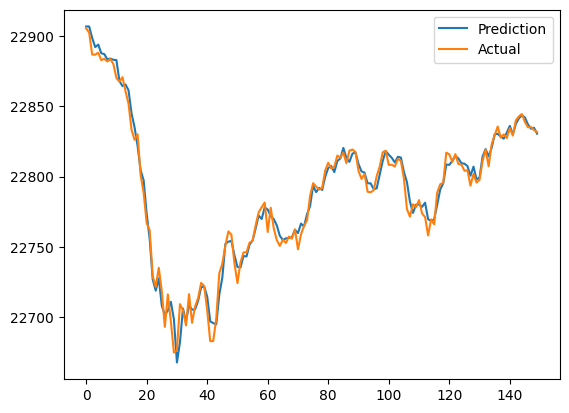

 mape: 0.00043315470550354224,
wape: 0.9995587124528075,
mae: 10.230799077823992,
 mpe: -0.0001698154149932968,
 rmse: 14.172171957305252,
 corr: 0.999957950760459,
r2_score:0.9997997432017626 minmax: 
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 16)                1472      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,489
Trainable params: 1,489
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
3748/3748 [==============================] - ETA: 0s - loss: 0.0034 - root_mean_squared_error: 0.0586

3748/3748 [==============================] - 233s 61ms/step - loss: 0.0034 - root_mean_squared_error: 0.0586 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0799
Epoch 2/10
3748/3748 [==============================] - ETA: 0s - loss: 2.8580e-05 - root_mean_squared_error: 0.0053

3748/3748 [==============================] - 232s 62ms/step - loss: 2.8580e-05 - root_mean_squared_error: 0.0053 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0331
Epoch 3/10
3748/3748 [==============================] - ETA: 0s - loss: 1.1395e-05 - root_mean_squared_error: 0.0034

3748/3748 [==============================] - 234s 63ms/step - loss: 1.1395e-05 - root_mean_squared_error: 0.0034 - val_loss: 1.6406e-04 - val_root_mean_squared_error: 0.0128
Epoch 4/10
3748/3748 [==============================] - ETA: 0s - loss: 7.7798e-06 - root_mean_squared_error: 0.0028

3748/3748 [==============================] - 233s 62ms/step - loss: 7.7798e-06 - root_mean_squared_error: 0.0028 - val_loss: 8.1460e-05 - val_root_mean_squared_error: 0.0090
Epoch 5/10
3748/3748 [==============================] - ETA: 0s - loss: 5.2774e-06 - root_mean_squared_error: 0.0023

3748/3748 [==============================] - 224s 60ms/step - loss: 5.2774e-06 - root_mean_squared_error: 0.0023 - val_loss: 7.0701e-05 - val_root_mean_squared_error: 0.0084
Epoch 6/10
3747/3748 [============================>.] - ETA: 0s - loss: 3.8446e-06 - root_mean_squared_error: 0.0020

3748/3748 [==============================] - 228s 61ms/step - loss: 3.8491e-06 - root_mean_squared_error: 0.0020 - val_loss: 3.7747e-05 - val_root_mean_squared_error: 0.0061
Epoch 7/10
3748/3748 [==============================] - ETA: 0s - loss: 3.0726e-06 - root_mean_squared_error: 0.0018

3748/3748 [==============================] - 225s 60ms/step - loss: 3.0726e-06 - root_mean_squared_error: 0.0018 - val_loss: 2.9911e-05 - val_root_mean_squared_error: 0.0055
Epoch 8/10
3748/3748 [==============================] - ETA: 0s - loss: 2.5730e-06 - root_mean_squared_error: 0.0016

3748/3748 [==============================] - 226s 60ms/step - loss: 2.5730e-06 - root_mean_squared_error: 0.0016 - val_loss: 1.8552e-05 - val_root_mean_squared_error: 0.0043
Epoch 9/10
3748/3748 [==============================] - 222s 59ms/step - loss: 2.2750e-06 - root_mean_squared_error: 0.0015 - val_loss: 2.8538e-05 - val_root_mean_squared_error: 0.0053
Epoch 10/10
1250/1250 [==============================] - 16s 13ms/step
       Test Predictions   Actuals
0          22868.503906  22905.32
1          22872.464844  22902.29
2          22868.804688  22886.67
3          22863.253906  22886.61
4          22869.306641  22888.05
...                 ...       ...
39965      22525.593750  22542.26
39966      22519.929688  22533.65
39967      22522.625000  22530.37
39968      22520.037109  22520.83
39969      22520.138672  22524.46

[39970 rows x 2 columns]


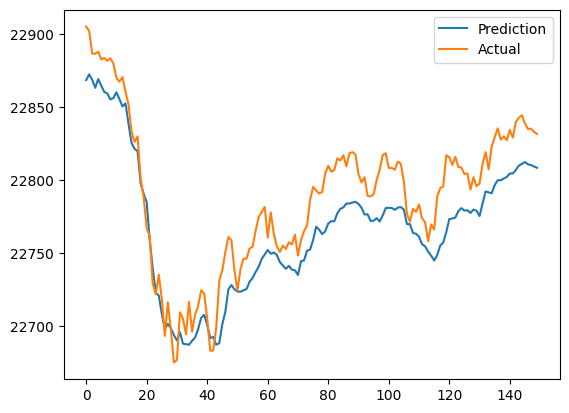

 mape: 0.0031370694724028683,
wape: 0.99674299666973,
mae: 75.510280948993,
 mpe: -0.002938771709203247,
 rmse: 106.3111386859124,
 corr: 0.9995814961652748,
r2_score:0.9887313476252663 minmax: 
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 16)                1472      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,489
Trainable params: 1,489
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
3747/3748 [============================>.] - ETA: 0s - loss: 0.0379 - root_mean_squared_error: 0.1946

3748/3748 [==============================] - 231s 61ms/step - loss: 0.0379 - root_mean_squared_error: 0.1946 - val_loss: 0.0439 - val_root_mean_squared_error: 0.2095
Epoch 2/10
3747/3748 [============================>.] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0334

3748/3748 [==============================] - 228s 61ms/step - loss: 0.0011 - root_mean_squared_error: 0.0334 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0738
Epoch 3/10
3748/3748 [==============================] - ETA: 0s - loss: 1.5946e-04 - root_mean_squared_error: 0.0126

3748/3748 [==============================] - 230s 61ms/step - loss: 1.5946e-04 - root_mean_squared_error: 0.0126 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0658
Epoch 4/10
3748/3748 [==============================] - ETA: 0s - loss: 6.9625e-05 - root_mean_squared_error: 0.0083

3748/3748 [==============================] - 229s 61ms/step - loss: 6.9625e-05 - root_mean_squared_error: 0.0083 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0494
Epoch 5/10
3748/3748 [==============================] - ETA: 0s - loss: 3.1871e-05 - root_mean_squared_error: 0.0056

3748/3748 [==============================] - 230s 61ms/step - loss: 3.1871e-05 - root_mean_squared_error: 0.0056 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0319
Epoch 6/10
3748/3748 [==============================] - ETA: 0s - loss: 1.8556e-05 - root_mean_squared_error: 0.0043

3748/3748 [==============================] - 236s 63ms/step - loss: 1.8556e-05 - root_mean_squared_error: 0.0043 - val_loss: 4.8197e-04 - val_root_mean_squared_error: 0.0220
Epoch 7/10
3747/3748 [============================>.] - ETA: 0s - loss: 1.4473e-05 - root_mean_squared_error: 0.0038

3748/3748 [==============================] - 231s 62ms/step - loss: 1.4473e-05 - root_mean_squared_error: 0.0038 - val_loss: 3.3740e-04 - val_root_mean_squared_error: 0.0184
Epoch 8/10
3748/3748 [==============================] - ETA: 0s - loss: 1.2501e-05 - root_mean_squared_error: 0.0035

3748/3748 [==============================] - 228s 61ms/step - loss: 1.2501e-05 - root_mean_squared_error: 0.0035 - val_loss: 3.1200e-04 - val_root_mean_squared_error: 0.0177
Epoch 9/10
3748/3748 [==============================] - ETA: 0s - loss: 1.1175e-05 - root_mean_squared_error: 0.0033

3748/3748 [==============================] - 232s 62ms/step - loss: 1.1175e-05 - root_mean_squared_error: 0.0033 - val_loss: 2.9600e-04 - val_root_mean_squared_error: 0.0172
Epoch 10/10
3748/3748 [==============================] - ETA: 0s - loss: 1.0180e-05 - root_mean_squared_error: 0.0032

1250/1250 [==============================] - 16s 13ms/step
       Test Predictions   Actuals
0          22761.332031  22905.32
1          22765.287109  22902.29
2          22766.992188  22886.67
3          22759.652344  22886.61
4          22762.447266  22888.05
...                 ...       ...
39965      22406.074219  22542.26
39966      22409.753906  22533.65
39967      22408.818359  22530.37
39968      22416.949219  22520.83
39969      22418.263672  22524.46

[39970 rows x 2 columns]


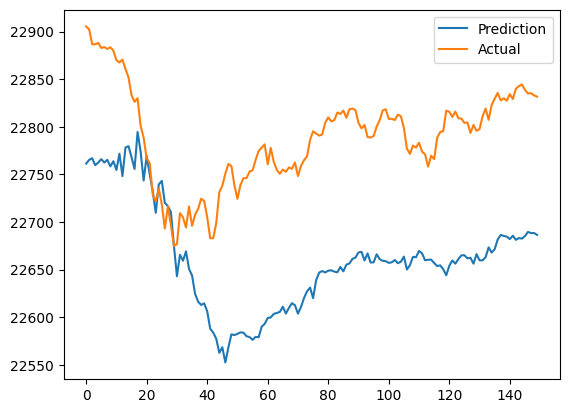

 mape: 0.011818069388460785,
wape: 0.9877922579385072,
mae: 283.0239761344445,
 mpe: -0.011742112877692374,
 rmse: 365.88431230798346,
 corr: 0.9967841998447061,
r2_score:0.866524357530318 minmax: 
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 20)                2160      
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,181
Trainable params: 2,181
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
3747/3748 [============================>.] - ETA: 0s - loss: 4.8742e-06 - root_mean_squared_error: 0.0022

3748/3748 [==============================] - 245s 65ms/step - loss: 4.8740e-06 - root_mean_squared_error: 0.0022 - val_loss: 4.5446e-06 - val_root_mean_squared_error: 0.0021
Epoch 2/10
3748/3748 [==============================] - 235s 63ms/step - loss: 2.4676e-06 - root_mean_squared_error: 0.0016 - val_loss: 9.9436e-06 - val_root_mean_squared_error: 0.0032
Epoch 3/10
3748/3748 [==============================] - 238s 63ms/step - loss: 1.8091e-06 - root_mean_squared_error: 0.0013 - val_loss: 1.1700e-05 - val_root_mean_squared_error: 0.0034
Epoch 4/10
3748/3748 [==============================] - 236s 63ms/step - loss: 1.5520e-06 - root_mean_squared_error: 0.0012 - val_loss: 7.2122e-06 - val_root_mean_squared_error: 0.0027
Epoch 5/10
3748/3748 [==============================] - 237s 63ms/step - loss: 1.2950e-06 - root_mean_squared_error: 0.0011 - val_loss: 5.5383e-06 - val_root_mean_squared_error: 0.0024
Epoch 6/10
3747/3748 [============================>.] - ETA: 0s - loss: 1.0516e-06 - r

3748/3748 [==============================] - 242s 65ms/step - loss: 1.0515e-06 - root_mean_squared_error: 0.0010 - val_loss: 1.2246e-06 - val_root_mean_squared_error: 0.0011
Epoch 7/10
3748/3748 [==============================] - 239s 64ms/step - loss: 9.6551e-07 - root_mean_squared_error: 9.8260e-04 - val_loss: 1.5144e-06 - val_root_mean_squared_error: 0.0012
Epoch 8/10
3748/3748 [==============================] - 238s 63ms/step - loss: 8.4706e-07 - root_mean_squared_error: 9.2036e-04 - val_loss: 5.2446e-06 - val_root_mean_squared_error: 0.0023
Epoch 9/10
3748/3748 [==============================] - ETA: 0s - loss: 7.2791e-07 - root_mean_squared_error: 8.5318e-04

3748/3748 [==============================] - 241s 64ms/step - loss: 7.2791e-07 - root_mean_squared_error: 8.5318e-04 - val_loss: 8.3092e-07 - val_root_mean_squared_error: 9.1155e-04
Epoch 10/10
1250/1250 [==============================] - 19s 15ms/step
       Test Predictions   Actuals
0          22907.882812  22905.32
1          22905.886719  22902.29
2          22894.042969  22886.67
3          22885.253906  22886.61
4          22889.271484  22888.05
...                 ...       ...
39965      22545.537109  22542.26
39966      22540.902344  22533.65
39967      22534.355469  22530.37
39968      22526.492188  22520.83
39969      22530.839844  22524.46

[39970 rows x 2 columns]


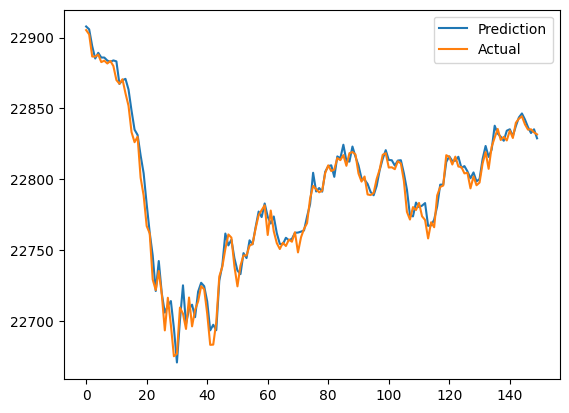

 mape: 0.0003404509722333134,
wape: 0.999655660010755,
mae: 7.983169402442459,
 mpe: -2.526614188188667e-05,
 rmse: 10.733480129316044,
 corr: 0.9999670761313821,
r2_score:0.9998851329268752 minmax: 
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 20)                2160      
                                                                 
 dense_4 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,181
Trainable params: 2,181
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
3748/3748 [==============================] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0512

3748/3748 [==============================] - 243s 64ms/step - loss: 0.0026 - root_mean_squared_error: 0.0512 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0654
Epoch 2/10
3747/3748 [============================>.] - ETA: 0s - loss: 1.2291e-05 - root_mean_squared_error: 0.0035

3748/3748 [==============================] - 241s 64ms/step - loss: 1.2291e-05 - root_mean_squared_error: 0.0035 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0387
Epoch 3/10
3748/3748 [==============================] - ETA: 0s - loss: 5.0481e-06 - root_mean_squared_error: 0.0022

3748/3748 [==============================] - 246s 66ms/step - loss: 5.0481e-06 - root_mean_squared_error: 0.0022 - val_loss: 3.0192e-04 - val_root_mean_squared_error: 0.0174
Epoch 4/10
3747/3748 [============================>.] - ETA: 0s - loss: 3.5396e-06 - root_mean_squared_error: 0.0019

3748/3748 [==============================] - 249s 66ms/step - loss: 3.5396e-06 - root_mean_squared_error: 0.0019 - val_loss: 9.5635e-05 - val_root_mean_squared_error: 0.0098
Epoch 5/10
3748/3748 [==============================] - ETA: 0s - loss: 2.8783e-06 - root_mean_squared_error: 0.0017

3748/3748 [==============================] - 249s 66ms/step - loss: 2.8783e-06 - root_mean_squared_error: 0.0017 - val_loss: 4.7512e-05 - val_root_mean_squared_error: 0.0069
Epoch 6/10
3748/3748 [==============================] - ETA: 0s - loss: 2.5372e-06 - root_mean_squared_error: 0.0016

3748/3748 [==============================] - 245s 65ms/step - loss: 2.5372e-06 - root_mean_squared_error: 0.0016 - val_loss: 3.4510e-05 - val_root_mean_squared_error: 0.0059
Epoch 7/10
3748/3748 [==============================] - ETA: 0s - loss: 2.2528e-06 - root_mean_squared_error: 0.0015

3748/3748 [==============================] - 243s 65ms/step - loss: 2.2528e-06 - root_mean_squared_error: 0.0015 - val_loss: 2.8853e-05 - val_root_mean_squared_error: 0.0054
Epoch 8/10
3747/3748 [============================>.] - ETA: 0s - loss: 2.0865e-06 - root_mean_squared_error: 0.0014

3748/3748 [==============================] - 241s 64ms/step - loss: 2.0864e-06 - root_mean_squared_error: 0.0014 - val_loss: 1.5123e-05 - val_root_mean_squared_error: 0.0039
Epoch 9/10
3747/3748 [============================>.] - ETA: 0s - loss: 1.9147e-06 - root_mean_squared_error: 0.0014

3748/3748 [==============================] - 247s 66ms/step - loss: 1.9147e-06 - root_mean_squared_error: 0.0014 - val_loss: 8.8816e-06 - val_root_mean_squared_error: 0.0030
Epoch 10/10
1250/1250 [==============================] - 19s 15ms/step
       Test Predictions   Actuals
0          22877.527344  22905.32
1          22879.656250  22902.29
2          22875.333984  22886.67
3          22872.115234  22886.61
4          22878.275391  22888.05
...                 ...       ...
39965      22530.541016  22542.26
39966      22527.525391  22533.65
39967      22528.619141  22530.37
39968      22523.574219  22520.83
39969      22526.351562  22524.46

[39970 rows x 2 columns]


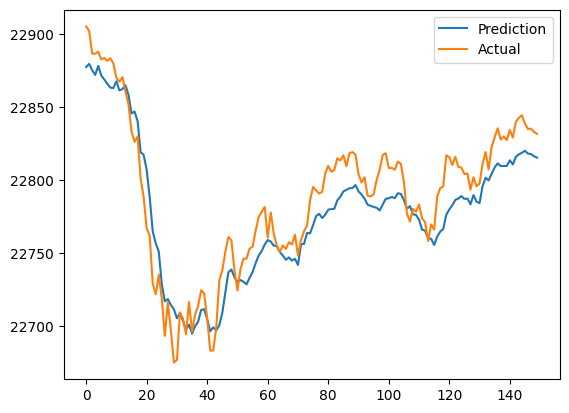

 mape: 0.002129309010034921,
wape: 0.9977889588013202,
mae: 51.26072194966535,
 mpe: -0.0019305183191298345,
 rmse: 74.5146366092222,
 corr: 0.9996040978827624,
r2_score:0.9944639804187927 minmax: 
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 20)                2160      
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,181
Trainable params: 2,181
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
3748/3748 [==============================] - ETA: 0s - loss: 0.0056 - root_mean_squared_error: 0.0750

3748/3748 [==============================] - 254s 67ms/step - loss: 0.0056 - root_mean_squared_error: 0.0750 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0595
Epoch 2/10
3747/3748 [============================>.] - ETA: 0s - loss: 1.1977e-04 - root_mean_squared_error: 0.0109

3748/3748 [==============================] - 250s 67ms/step - loss: 1.1976e-04 - root_mean_squared_error: 0.0109 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0370
Epoch 3/10
3747/3748 [============================>.] - ETA: 0s - loss: 1.2377e-05 - root_mean_squared_error: 0.0035

3748/3748 [==============================] - 245s 65ms/step - loss: 1.2378e-05 - root_mean_squared_error: 0.0035 - val_loss: 6.6609e-04 - val_root_mean_squared_error: 0.0258
Epoch 4/10
3747/3748 [============================>.] - ETA: 0s - loss: 7.3057e-06 - root_mean_squared_error: 0.0027

3748/3748 [==============================] - 250s 67ms/step - loss: 7.3054e-06 - root_mean_squared_error: 0.0027 - val_loss: 4.6115e-04 - val_root_mean_squared_error: 0.0215
Epoch 5/10
3748/3748 [==============================] - ETA: 0s - loss: 5.4963e-06 - root_mean_squared_error: 0.0023

3748/3748 [==============================] - 251s 67ms/step - loss: 5.4963e-06 - root_mean_squared_error: 0.0023 - val_loss: 3.0618e-04 - val_root_mean_squared_error: 0.0175
Epoch 6/10
3748/3748 [==============================] - ETA: 0s - loss: 4.4681e-06 - root_mean_squared_error: 0.0021

3748/3748 [==============================] - 253s 67ms/step - loss: 4.4681e-06 - root_mean_squared_error: 0.0021 - val_loss: 2.0401e-04 - val_root_mean_squared_error: 0.0143
Epoch 7/10
3748/3748 [==============================] - ETA: 0s - loss: 3.9319e-06 - root_mean_squared_error: 0.0020

3748/3748 [==============================] - 258s 69ms/step - loss: 3.9319e-06 - root_mean_squared_error: 0.0020 - val_loss: 1.1370e-04 - val_root_mean_squared_error: 0.0107
Epoch 8/10
3748/3748 [==============================] - ETA: 0s - loss: 3.6209e-06 - root_mean_squared_error: 0.0019

3748/3748 [==============================] - 252s 67ms/step - loss: 3.6209e-06 - root_mean_squared_error: 0.0019 - val_loss: 7.6168e-05 - val_root_mean_squared_error: 0.0087
Epoch 9/10
3747/3748 [============================>.] - ETA: 0s - loss: 3.3920e-06 - root_mean_squared_error: 0.0018

3748/3748 [==============================] - 252s 67ms/step - loss: 3.3919e-06 - root_mean_squared_error: 0.0018 - val_loss: 4.6700e-05 - val_root_mean_squared_error: 0.0068
Epoch 10/10
3747/3748 [============================>.] - ETA: 0s - loss: 3.2169e-06 - root_mean_squared_error: 0.0018

1250/1250 [==============================] - 19s 14ms/step
       Test Predictions   Actuals
0          22844.826172  22905.32
1          22847.570312  22902.29
2          22844.343750  22886.67
3          22841.621094  22886.61
4          22845.134766  22888.05
...                 ...       ...
39965      22485.482422  22542.26
39966      22488.601562  22533.65
39967      22494.609375  22530.37
39968      22491.070312  22520.83
39969      22494.158203  22524.46

[39970 rows x 2 columns]


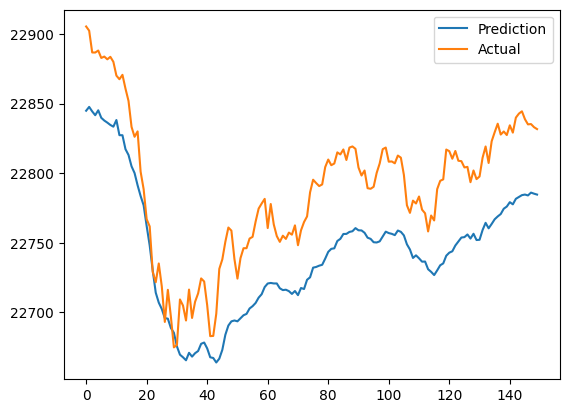

 mape: 0.00380368089902383,
wape: 0.9960754569196999,
mae: 90.9865052441675,
 mpe: -0.0037695547189990886,
 rmse: 117.0925830277096,
 corr: 0.9996458251820275,
r2_score:0.9863298520491675 minmax: 
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 24)                2976      
                                                                 
 dense_6 (Dense)             (None, 1)                 25        
                                                                 
Total params: 3,001
Trainable params: 3,001
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
3748/3748 [==============================] - ETA: 0s - loss: 1.5725e-04 - root_mean_squared_error: 0.0125

3748/3748 [==============================] - 259s 68ms/step - loss: 1.5725e-04 - root_mean_squared_error: 0.0125 - val_loss: 9.9764e-05 - val_root_mean_squared_error: 0.0100
Epoch 2/10
3748/3748 [==============================] - ETA: 0s - loss: 3.8317e-06 - root_mean_squared_error: 0.0020

3748/3748 [==============================] - 262s 70ms/step - loss: 3.8317e-06 - root_mean_squared_error: 0.0020 - val_loss: 3.6461e-05 - val_root_mean_squared_error: 0.0060
Epoch 3/10
3748/3748 [==============================] - 253s 68ms/step - loss: 2.6422e-06 - root_mean_squared_error: 0.0016 - val_loss: 4.5759e-05 - val_root_mean_squared_error: 0.0068
Epoch 4/10
3748/3748 [==============================] - ETA: 0s - loss: 1.9233e-06 - root_mean_squared_error: 0.0014

3748/3748 [==============================] - 263s 70ms/step - loss: 1.9233e-06 - root_mean_squared_error: 0.0014 - val_loss: 3.6636e-06 - val_root_mean_squared_error: 0.0019
Epoch 5/10
3747/3748 [============================>.] - ETA: 0s - loss: 1.3521e-06 - root_mean_squared_error: 0.0012

3748/3748 [==============================] - 258s 69ms/step - loss: 1.3521e-06 - root_mean_squared_error: 0.0012 - val_loss: 3.2648e-06 - val_root_mean_squared_error: 0.0018
Epoch 6/10
3747/3748 [============================>.] - ETA: 0s - loss: 1.1107e-06 - root_mean_squared_error: 0.0011

3748/3748 [==============================] - 256s 68ms/step - loss: 1.1107e-06 - root_mean_squared_error: 0.0011 - val_loss: 1.2335e-06 - val_root_mean_squared_error: 0.0011
Epoch 7/10
3748/3748 [==============================] - 251s 67ms/step - loss: 9.1938e-07 - root_mean_squared_error: 9.5884e-04 - val_loss: 5.0313e-06 - val_root_mean_squared_error: 0.0022
Epoch 8/10
3748/3748 [==============================] - ETA: 0s - loss: 8.0748e-07 - root_mean_squared_error: 8.9860e-04

3748/3748 [==============================] - 257s 68ms/step - loss: 8.0748e-07 - root_mean_squared_error: 8.9860e-04 - val_loss: 1.2296e-06 - val_root_mean_squared_error: 0.0011
Epoch 9/10
3748/3748 [==============================] - 256s 68ms/step - loss: 7.1930e-07 - root_mean_squared_error: 8.4812e-04 - val_loss: 6.2211e-06 - val_root_mean_squared_error: 0.0025
Epoch 10/10
3748/3748 [==============================] - ETA: 0s - loss: 6.5309e-07 - root_mean_squared_error: 8.0814e-04

1250/1250 [==============================] - 21s 16ms/step
       Test Predictions   Actuals
0          22911.884766  22905.32
1          22909.146484  22902.29
2          22896.777344  22886.67
3          22887.027344  22886.61
4          22893.759766  22888.05
...                 ...       ...
39965      22543.433594  22542.26
39966      22542.697266  22533.65
39967      22535.136719  22530.37
39968      22525.837891  22520.83
39969      22533.054688  22524.46

[39970 rows x 2 columns]


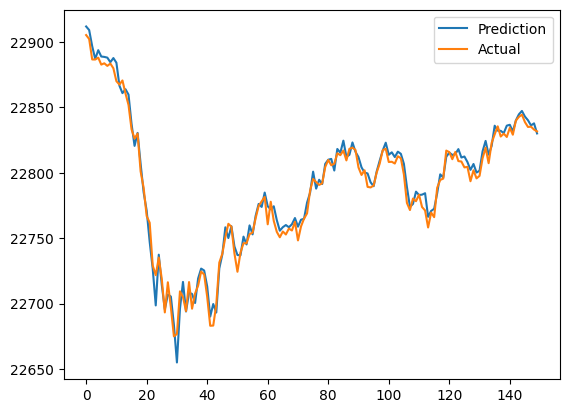

 mape: 0.0005703345751819487,
wape: 0.999418241700651,
mae: 13.487469361786962,
 mpe: -0.00021199426514617345,
 rmse: 18.11607772397061,
 corr: 0.9999628177591933,
r2_score:0.9996727777756856 minmax: 
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 24)                2976      
                                                                 
 dense_7 (Dense)             (None, 1)                 25        
                                                                 
Total params: 3,001
Trainable params: 3,001
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
3747/3748 [============================>.] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0387

3748/3748 [==============================] - 262s 69ms/step - loss: 0.0015 - root_mean_squared_error: 0.0387 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0485
Epoch 2/10
3747/3748 [============================>.] - ETA: 0s - loss: 1.2761e-05 - root_mean_squared_error: 0.0036

3748/3748 [==============================] - 262s 70ms/step - loss: 1.2761e-05 - root_mean_squared_error: 0.0036 - val_loss: 7.1745e-04 - val_root_mean_squared_error: 0.0268
Epoch 3/10
3748/3748 [==============================] - ETA: 0s - loss: 7.7256e-06 - root_mean_squared_error: 0.0028

3748/3748 [==============================] - 265s 71ms/step - loss: 7.7256e-06 - root_mean_squared_error: 0.0028 - val_loss: 1.5174e-04 - val_root_mean_squared_error: 0.0123
Epoch 4/10
3747/3748 [============================>.] - ETA: 0s - loss: 5.1348e-06 - root_mean_squared_error: 0.0023

3748/3748 [==============================] - 264s 70ms/step - loss: 5.1346e-06 - root_mean_squared_error: 0.0023 - val_loss: 3.3527e-05 - val_root_mean_squared_error: 0.0058
Epoch 5/10
3748/3748 [==============================] - ETA: 0s - loss: 3.7176e-06 - root_mean_squared_error: 0.0019

3748/3748 [==============================] - 265s 71ms/step - loss: 3.7176e-06 - root_mean_squared_error: 0.0019 - val_loss: 1.3001e-05 - val_root_mean_squared_error: 0.0036
Epoch 6/10
3748/3748 [==============================] - ETA: 0s - loss: 2.9031e-06 - root_mean_squared_error: 0.0017

3748/3748 [==============================] - 264s 70ms/step - loss: 2.9031e-06 - root_mean_squared_error: 0.0017 - val_loss: 4.6616e-06 - val_root_mean_squared_error: 0.0022
Epoch 7/10
3747/3748 [============================>.] - ETA: 0s - loss: 2.3856e-06 - root_mean_squared_error: 0.0015

3748/3748 [==============================] - 267s 71ms/step - loss: 2.3873e-06 - root_mean_squared_error: 0.0015 - val_loss: 4.5274e-06 - val_root_mean_squared_error: 0.0021
Epoch 8/10
3747/3748 [============================>.] - ETA: 0s - loss: 2.0744e-06 - root_mean_squared_error: 0.0014

3748/3748 [==============================] - 265s 71ms/step - loss: 2.0743e-06 - root_mean_squared_error: 0.0014 - val_loss: 3.0849e-06 - val_root_mean_squared_error: 0.0018
Epoch 9/10
3748/3748 [==============================] - 262s 70ms/step - loss: 1.8408e-06 - root_mean_squared_error: 0.0014 - val_loss: 4.2498e-06 - val_root_mean_squared_error: 0.0021
Epoch 10/10
1250/1250 [==============================] - 20s 16ms/step
       Test Predictions   Actuals
0          22909.214844  22905.32
1          22910.261719  22902.29
2          22905.966797  22886.67
3          22902.957031  22886.61
4          22904.550781  22888.05
...                 ...       ...
39965      22548.632812  22542.26
39966      22549.939453  22533.65
39967      22549.246094  22530.37
39968      22542.894531  22520.83
39969      22544.570312  22524.46

[39970 rows x 2 columns]


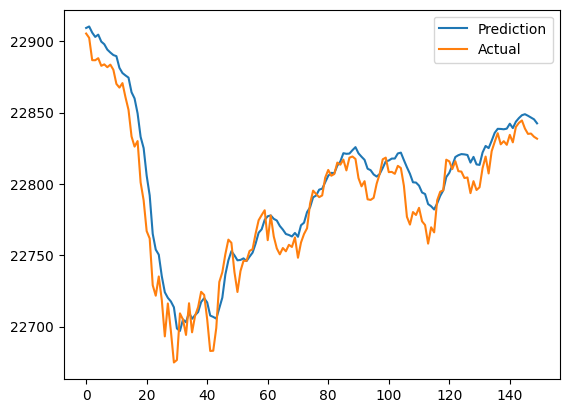

 mape: 0.0006960700998843099,
wape: 0.9993000386568173,
mae: 16.22788567206655,
 mpe: 0.00029020339699471157,
 rmse: 21.21500249801602,
 corr: 0.9998308454969814,
r2_score:0.9995512539731808 minmax: 
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 24)                2976      
                                                                 
 dense_8 (Dense)             (None, 1)                 25        
                                                                 
Total params: 3,001
Trainable params: 3,001
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
3748/3748 [==============================] - ETA: 0s - loss: 0.0286 - root_mean_squared_error: 0.1690

3748/3748 [==============================] - 271s 72ms/step - loss: 0.0286 - root_mean_squared_error: 0.1690 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0855
Epoch 2/10
3748/3748 [==============================] - ETA: 0s - loss: 1.3965e-04 - root_mean_squared_error: 0.0118

3748/3748 [==============================] - 268s 71ms/step - loss: 1.3965e-04 - root_mean_squared_error: 0.0118 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0340
Epoch 3/10
3748/3748 [==============================] - 264s 70ms/step - loss: 3.7273e-05 - root_mean_squared_error: 0.0061 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0435
Epoch 4/10
3748/3748 [==============================] - 264s 70ms/step - loss: 1.9227e-05 - root_mean_squared_error: 0.0044 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0369
Epoch 5/10
3748/3748 [==============================] - ETA: 0s - loss: 1.1374e-05 - root_mean_squared_error: 0.0034

3748/3748 [==============================] - 265s 71ms/step - loss: 1.1374e-05 - root_mean_squared_error: 0.0034 - val_loss: 7.7751e-04 - val_root_mean_squared_error: 0.0279
Epoch 6/10
3747/3748 [============================>.] - ETA: 0s - loss: 8.0932e-06 - root_mean_squared_error: 0.0028

3748/3748 [==============================] - 269s 72ms/step - loss: 8.0929e-06 - root_mean_squared_error: 0.0028 - val_loss: 4.2426e-04 - val_root_mean_squared_error: 0.0206
Epoch 7/10
3748/3748 [==============================] - ETA: 0s - loss: 6.3460e-06 - root_mean_squared_error: 0.0025

3748/3748 [==============================] - 266s 71ms/step - loss: 6.3460e-06 - root_mean_squared_error: 0.0025 - val_loss: 2.4086e-04 - val_root_mean_squared_error: 0.0155
Epoch 8/10
3748/3748 [==============================] - ETA: 0s - loss: 5.3792e-06 - root_mean_squared_error: 0.0023

3748/3748 [==============================] - 265s 71ms/step - loss: 5.3792e-06 - root_mean_squared_error: 0.0023 - val_loss: 1.3403e-04 - val_root_mean_squared_error: 0.0116
Epoch 9/10
3747/3748 [============================>.] - ETA: 0s - loss: 4.8324e-06 - root_mean_squared_error: 0.0022

3748/3748 [==============================] - 264s 70ms/step - loss: 4.8322e-06 - root_mean_squared_error: 0.0022 - val_loss: 7.5948e-05 - val_root_mean_squared_error: 0.0087
Epoch 10/10
3748/3748 [==============================] - ETA: 0s - loss: 4.4886e-06 - root_mean_squared_error: 0.0021

1250/1250 [==============================] - 22s 17ms/step
       Test Predictions   Actuals
0          22842.324219  22905.32
1          22843.025391  22902.29
2          22842.675781  22886.67
3          22840.277344  22886.61
4          22839.546875  22888.05
...                 ...       ...
39965      22492.929688  22542.26
39966      22495.093750  22533.65
39967      22493.738281  22530.37
39968      22494.091797  22520.83
39969      22494.392578  22524.46

[39970 rows x 2 columns]


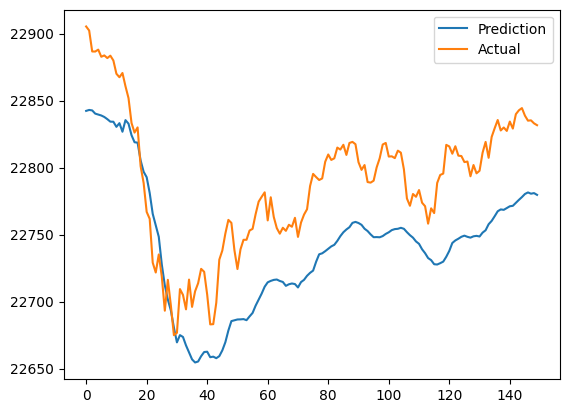

 mape: 0.005185339663081549,
wape: 0.994624339282611,
mae: 124.62917900143857,
 mpe: -0.005096633694498127,
 rmse: 170.12649943610197,
 corr: 0.9990511903008166,
r2_score:0.9711425219630159 minmax: 
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 28)                3920      
                                                                 
 dense_9 (Dense)             (None, 1)                 29        
                                                                 
Total params: 3,949
Trainable params: 3,949
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
3748/3748 [==============================] - ETA: 0s - loss: 1.1374e-04 - root_mean_squared_error: 0.0107

3748/3748 [==============================] - 276s 73ms/step - loss: 1.1374e-04 - root_mean_squared_error: 0.0107 - val_loss: 2.2164e-05 - val_root_mean_squared_error: 0.0047
Epoch 2/10
3748/3748 [==============================] - ETA: 0s - loss: 4.0750e-06 - root_mean_squared_error: 0.0020

3748/3748 [==============================] - 272s 73ms/step - loss: 4.0750e-06 - root_mean_squared_error: 0.0020 - val_loss: 2.8909e-06 - val_root_mean_squared_error: 0.0017
Epoch 3/10
3748/3748 [==============================] - 273s 73ms/step - loss: 2.9527e-06 - root_mean_squared_error: 0.0017 - val_loss: 2.9034e-05 - val_root_mean_squared_error: 0.0054
Epoch 4/10
3748/3748 [==============================] - 278s 74ms/step - loss: 2.0303e-06 - root_mean_squared_error: 0.0014 - val_loss: 3.4852e-06 - val_root_mean_squared_error: 0.0019
Epoch 5/10
3748/3748 [==============================] - 271s 72ms/step - loss: 1.6264e-06 - root_mean_squared_error: 0.0013 - val_loss: 2.1017e-05 - val_root_mean_squared_error: 0.0046
Epoch 6/10
3747/3748 [============================>.] - ETA: 0s - loss: 1.3884e-06 - root_mean_squared_error: 0.0012

3748/3748 [==============================] - 274s 73ms/step - loss: 1.3883e-06 - root_mean_squared_error: 0.0012 - val_loss: 1.6072e-06 - val_root_mean_squared_error: 0.0013
Epoch 7/10
3748/3748 [==============================] - 270s 72ms/step - loss: 1.1235e-06 - root_mean_squared_error: 0.0011 - val_loss: 4.5853e-06 - val_root_mean_squared_error: 0.0021
Epoch 8/10
3748/3748 [==============================] - ETA: 0s - loss: 9.6447e-07 - root_mean_squared_error: 9.8207e-04

3748/3748 [==============================] - 273s 73ms/step - loss: 9.6447e-07 - root_mean_squared_error: 9.8207e-04 - val_loss: 1.5072e-06 - val_root_mean_squared_error: 0.0012
Epoch 9/10
3748/3748 [==============================] - 269s 72ms/step - loss: 8.4022e-07 - root_mean_squared_error: 9.1664e-04 - val_loss: 4.9576e-06 - val_root_mean_squared_error: 0.0022
Epoch 10/10
3748/3748 [==============================] - ETA: 0s - loss: 7.5713e-07 - root_mean_squared_error: 8.7013e-04

1250/1250 [==============================] - 21s 16ms/step
       Test Predictions   Actuals
0          22897.976562  22905.32
1          22897.330078  22902.29
2          22885.406250  22886.67
3          22873.437500  22886.61
4          22881.712891  22888.05
...                 ...       ...
39965      22538.082031  22542.26
39966      22530.349609  22533.65
39967      22520.417969  22530.37
39968      22515.710938  22520.83
39969      22520.298828  22524.46

[39970 rows x 2 columns]


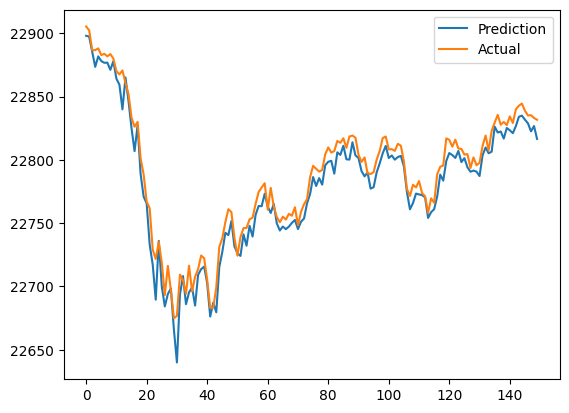

 mape: 0.0006236885176250402,
wape: 0.9993593134992697,
mae: 14.85365925811545,
 mpe: -0.0005994429603131128,
 rmse: 19.606685988669224,
 corr: 0.9999635280853432,
r2_score:0.9996167141126295 minmax: 
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 28)                3920      
                                                                 
 dense_10 (Dense)            (None, 1)                 29        
                                                                 
Total params: 3,949
Trainable params: 3,949
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
3748/3748 [==============================] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0333

3748/3748 [==============================] - 279s 74ms/step - loss: 0.0011 - root_mean_squared_error: 0.0333 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0382
Epoch 2/10
3747/3748 [============================>.] - ETA: 0s - loss: 7.8646e-06 - root_mean_squared_error: 0.0028

3748/3748 [==============================] - 273s 73ms/step - loss: 7.8643e-06 - root_mean_squared_error: 0.0028 - val_loss: 9.0641e-05 - val_root_mean_squared_error: 0.0095
Epoch 3/10
3748/3748 [==============================] - 271s 72ms/step - loss: 3.6788e-06 - root_mean_squared_error: 0.0019 - val_loss: 1.0520e-04 - val_root_mean_squared_error: 0.0103
Epoch 4/10
3748/3748 [==============================] - ETA: 0s - loss: 2.9282e-06 - root_mean_squared_error: 0.0017

3748/3748 [==============================] - 272s 73ms/step - loss: 2.9282e-06 - root_mean_squared_error: 0.0017 - val_loss: 6.7366e-05 - val_root_mean_squared_error: 0.0082
Epoch 5/10
3747/3748 [============================>.] - ETA: 0s - loss: 2.4719e-06 - root_mean_squared_error: 0.0016

3748/3748 [==============================] - 275s 73ms/step - loss: 2.4724e-06 - root_mean_squared_error: 0.0016 - val_loss: 5.4736e-05 - val_root_mean_squared_error: 0.0074
Epoch 6/10
 482/3748 [==>...........................] - ETA: 3:32 - loss: 2.0577e-06 - root_mean_squared_error: 0.0014

In [ ]:
stats = []
for lstm_neurons in range(16, 29, 4):
  for lr in [0.001, 0.0001, 0.00001]:
    build_compile_fit_model(lstm_neurons, lr,
                        f'model_{mins}_mins_4/', 10,
                        X_n_train, y_n_train, X_n_val, y_n_val)
    model_1_min_4 = load_model(f'model_{mins}_mins_4/')
    mape, wape, mae, mpe, rmse, corr, r2_sc = get_predictions(model_1_min_4, X_n_test, y_n_test, 'Test', unsmooth=True)
    stats.append([lstm_neurons, lr, mape, wape, mae, mpe, rmse, corr, r2_sc])

In [ ]:
mins = 1

X_n_train, y_n_train, X_n_val, y_n_val, X_n_test, y_n_test = build_data(
    parsed_klines, mins,
    df_start=0, df_size=80000,
    columns=[OPR, HPR, LPR, VOL, TN, TAKER],
    smoothing_window_size=2500
)

stats = []
for lstm_neurons in range(4, 33, 4):
  for lr in [0.001, 0.0001, 0.00001]:
    build_compile_fit_model(lstm_neurons, lr,
                        f'model_{mins}_mins_4/', 10,
                        X_n_train, y_n_train, X_n_val, y_n_val)
    model_1_min_4 = load_model(f'model_{mins}_mins_4/')
    predictions = model_1_min_4.predict(X_n_test).flatten()
    results = pd.DataFrame(data={'Test Predictions': predictions, 'Actuals':y_n_test})

    mape, mae, mpe, rmse, corr = output_stats(results['Test Predictions'][2551:6956], results['Actuals'][2551:6956])
    stats.append([lstm_neurons, lr, mape, mae, mpe, rmse, corr])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 20)                2160      
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,181
Trainable params: 2,181
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1874/1875 [============================>.] - ETA: 0s - loss: 8.9174e-04 - root_mean_squared_error: 0.0299

1875/1875 [==============================] - 97s 50ms/step - loss: 8.9137e-04 - root_mean_squared_error: 0.0299 - val_loss: 4.8278e-04 - val_root_mean_squared_error: 0.0220
Epoch 2/10
1875/1875 [==============================] - ETA: 0s - loss: 2.8318e-04 - root_mean_squared_error: 0.0168

1875/1875 [==============================] - 91s 49ms/step - loss: 2.8318e-04 - root_mean_squared_error: 0.0168 - val_loss: 3.7873e-04 - val_root_mean_squared_error: 0.0195
Epoch 3/10
1874/1875 [============================>.] - ETA: 0s - loss: 2.1441e-04 - root_mean_squared_error: 0.0146

1875/1875 [==============================] - 88s 47ms/step - loss: 2.1438e-04 - root_mean_squared_error: 0.0146 - val_loss: 3.1478e-04 - val_root_mean_squared_error: 0.0177
Epoch 4/10
1875/1875 [==============================] - ETA: 0s - loss: 1.8617e-04 - root_mean_squared_error: 0.0136

1875/1875 [==============================] - 89s 47ms/step - loss: 1.8617e-04 - root_mean_squared_error: 0.0136 - val_loss: 2.9539e-04 - val_root_mean_squared_error: 0.0172
Epoch 5/10
1874/1875 [============================>.] - ETA: 0s - loss: 1.7140e-04 - root_mean_squared_error: 0.0131

1875/1875 [==============================] - 91s 49ms/step - loss: 1.7136e-04 - root_mean_squared_error: 0.0131 - val_loss: 2.7146e-04 - val_root_mean_squared_error: 0.0165
Epoch 6/10
1875/1875 [==============================] - ETA: 0s - loss: 1.5572e-04 - root_mean_squared_error: 0.0125

1875/1875 [==============================] - 93s 49ms/step - loss: 1.5572e-04 - root_mean_squared_error: 0.0125 - val_loss: 2.4816e-04 - val_root_mean_squared_error: 0.0158
Epoch 7/10
1875/1875 [==============================] - ETA: 0s - loss: 1.4798e-04 - root_mean_squared_error: 0.0122

1875/1875 [==============================] - 94s 50ms/step - loss: 1.4798e-04 - root_mean_squared_error: 0.0122 - val_loss: 2.4388e-04 - val_root_mean_squared_error: 0.0156
Epoch 8/10
1875/1875 [==============================] - 86s 46ms/step - loss: 1.4263e-04 - root_mean_squared_error: 0.0119 - val_loss: 2.5258e-04 - val_root_mean_squared_error: 0.0159
Epoch 9/10
1875/1875 [==============================] - ETA: 0s - loss: 1.3878e-04 - root_mean_squared_error: 0.0118

1875/1875 [==============================] - 90s 48ms/step - loss: 1.3878e-04 - root_mean_squared_error: 0.0118 - val_loss: 2.3323e-04 - val_root_mean_squared_error: 0.0153
Epoch 10/10
313/313 [==============================] - 5s 15ms/step
 mape: 0.02061006419218548,
 mae: 0.005693129303014821,
 mpe: 0.00812944194436137,
 rmse: 0.009774135038917815,
 corr: 0.9988940509286269,
 minmax: 
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 20)                2160      
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,181
Trainable params: 2,181
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1875/1875 [==============================]

1875/1875 [==============================] - 94s 48ms/step - loss: 0.0594 - root_mean_squared_error: 0.2437 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0577
Epoch 2/10
1875/1875 [==============================] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0458

1875/1875 [==============================] - 92s 49ms/step - loss: 0.0021 - root_mean_squared_error: 0.0458 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0452
Epoch 3/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0374

1875/1875 [==============================] - 92s 49ms/step - loss: 0.0014 - root_mean_squared_error: 0.0374 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0368
Epoch 4/10
1874/1875 [============================>.] - ETA: 0s - loss: 9.6605e-04 - root_mean_squared_error: 0.0311

1875/1875 [==============================] - 90s 48ms/step - loss: 9.6606e-04 - root_mean_squared_error: 0.0311 - val_loss: 9.0885e-04 - val_root_mean_squared_error: 0.0301
Epoch 5/10
1875/1875 [==============================] - ETA: 0s - loss: 6.7428e-04 - root_mean_squared_error: 0.0260

1875/1875 [==============================] - 93s 49ms/step - loss: 6.7428e-04 - root_mean_squared_error: 0.0260 - val_loss: 6.8242e-04 - val_root_mean_squared_error: 0.0261
Epoch 6/10
1875/1875 [==============================] - ETA: 0s - loss: 4.7966e-04 - root_mean_squared_error: 0.0219

1875/1875 [==============================] - 89s 47ms/step - loss: 4.7966e-04 - root_mean_squared_error: 0.0219 - val_loss: 5.1636e-04 - val_root_mean_squared_error: 0.0227
Epoch 7/10
1875/1875 [==============================] - ETA: 0s - loss: 3.5159e-04 - root_mean_squared_error: 0.0188

1875/1875 [==============================] - 93s 50ms/step - loss: 3.5159e-04 - root_mean_squared_error: 0.0188 - val_loss: 4.1066e-04 - val_root_mean_squared_error: 0.0203
Epoch 8/10
1875/1875 [==============================] - ETA: 0s - loss: 2.7661e-04 - root_mean_squared_error: 0.0166

1875/1875 [==============================] - 90s 48ms/step - loss: 2.7661e-04 - root_mean_squared_error: 0.0166 - val_loss: 3.5532e-04 - val_root_mean_squared_error: 0.0188
Epoch 9/10
1875/1875 [==============================] - ETA: 0s - loss: 2.3564e-04 - root_mean_squared_error: 0.0154

1875/1875 [==============================] - 92s 49ms/step - loss: 2.3564e-04 - root_mean_squared_error: 0.0154 - val_loss: 3.2305e-04 - val_root_mean_squared_error: 0.0180
Epoch 10/10
1875/1875 [==============================] - ETA: 0s - loss: 2.1291e-04 - root_mean_squared_error: 0.0146

313/313 [==============================] - 5s 15ms/step
 mape: 0.03104288036324505,
 mae: 0.008736905660833131,
 mpe: 0.015123229987003526,
 rmse: 0.013357561271178747,
 corr: 0.9980212915171323,
 minmax: 
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 20)                2160      
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,181
Trainable params: 2,181
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.1009 - root_mean_squared_error: 0.3177

1875/1875 [==============================] - 97s 51ms/step - loss: 0.1009 - root_mean_squared_error: 0.3176 - val_loss: 0.0173 - val_root_mean_squared_error: 0.1315
Epoch 2/10
1875/1875 [==============================] - ETA: 0s - loss: 0.0060 - root_mean_squared_error: 0.0773

1875/1875 [==============================] - 89s 48ms/step - loss: 0.0060 - root_mean_squared_error: 0.0773 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0769
Epoch 3/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0481

1875/1875 [==============================] - 94s 50ms/step - loss: 0.0023 - root_mean_squared_error: 0.0481 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0452
Epoch 4/10
1875/1875 [==============================] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0378

1875/1875 [==============================] - 91s 48ms/step - loss: 0.0014 - root_mean_squared_error: 0.0378 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0389
Epoch 5/10
1875/1875 [==============================] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0355

1875/1875 [==============================] - 94s 50ms/step - loss: 0.0013 - root_mean_squared_error: 0.0355 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0368
Epoch 6/10
1875/1875 [==============================] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0334

1875/1875 [==============================] - 92s 49ms/step - loss: 0.0011 - root_mean_squared_error: 0.0334 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0347
Epoch 7/10
1875/1875 [==============================] - ETA: 0s - loss: 9.9338e-04 - root_mean_squared_error: 0.0315

1875/1875 [==============================] - 91s 48ms/step - loss: 9.9338e-04 - root_mean_squared_error: 0.0315 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0328
Epoch 8/10
1875/1875 [==============================] - ETA: 0s - loss: 8.8793e-04 - root_mean_squared_error: 0.0298

1875/1875 [==============================] - 94s 50ms/step - loss: 8.8793e-04 - root_mean_squared_error: 0.0298 - val_loss: 9.9292e-04 - val_root_mean_squared_error: 0.0315
Epoch 9/10
1875/1875 [==============================] - ETA: 0s - loss: 8.0082e-04 - root_mean_squared_error: 0.0283

1875/1875 [==============================] - 91s 49ms/step - loss: 8.0082e-04 - root_mean_squared_error: 0.0283 - val_loss: 8.9594e-04 - val_root_mean_squared_error: 0.0299
Epoch 10/10
1875/1875 [==============================] - ETA: 0s - loss: 7.2877e-04 - root_mean_squared_error: 0.0270

313/313 [==============================] - 6s 18ms/step
 mape: 0.06686813556403415,
 mae: 0.017122258335087074,
 mpe: 0.032278141160617994,
 rmse: 0.027031868320703638,
 corr: 0.9912356772265333,
 minmax: 
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 24)                2976      
                                                                 
 dense_4 (Dense)             (None, 1)                 25        
                                                                 
Total params: 3,001
Trainable params: 3,001
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0432

1875/1875 [==============================] - 95s 49ms/step - loss: 0.0019 - root_mean_squared_error: 0.0432 - val_loss: 4.2906e-04 - val_root_mean_squared_error: 0.0207
Epoch 2/10
1875/1875 [==============================] - ETA: 0s - loss: 2.5095e-04 - root_mean_squared_error: 0.0158

1875/1875 [==============================] - 95s 51ms/step - loss: 2.5095e-04 - root_mean_squared_error: 0.0158 - val_loss: 3.3068e-04 - val_root_mean_squared_error: 0.0182
Epoch 3/10
1874/1875 [============================>.] - ETA: 0s - loss: 1.8194e-04 - root_mean_squared_error: 0.0135

1875/1875 [==============================] - 92s 49ms/step - loss: 1.8187e-04 - root_mean_squared_error: 0.0135 - val_loss: 2.5872e-04 - val_root_mean_squared_error: 0.0161
Epoch 4/10
1875/1875 [==============================] - ETA: 0s - loss: 1.6362e-04 - root_mean_squared_error: 0.0128

1875/1875 [==============================] - 95s 50ms/step - loss: 1.6362e-04 - root_mean_squared_error: 0.0128 - val_loss: 2.5544e-04 - val_root_mean_squared_error: 0.0160
Epoch 5/10
1875/1875 [==============================] - 88s 47ms/step - loss: 1.5353e-04 - root_mean_squared_error: 0.0124 - val_loss: 2.6577e-04 - val_root_mean_squared_error: 0.0163
Epoch 6/10
1875/1875 [==============================] - 91s 48ms/step - loss: 1.4774e-04 - root_mean_squared_error: 0.0122 - val_loss: 2.9637e-04 - val_root_mean_squared_error: 0.0172
Epoch 7/10
1875/1875 [==============================] - 85s 46ms/step - loss: 1.4175e-04 - root_mean_squared_error: 0.0119 - val_loss: 3.2859e-04 - val_root_mean_squared_error: 0.0181
Epoch 8/10
1875/1875 [==============================] - ETA: 0s - loss: 1.4130e-04 - root_mean_squared_error: 0.0119

1875/1875 [==============================] - 95s 51ms/step - loss: 1.4130e-04 - root_mean_squared_error: 0.0119 - val_loss: 2.3562e-04 - val_root_mean_squared_error: 0.0153
Epoch 9/10
1875/1875 [==============================] - 86s 46ms/step - loss: 1.3758e-04 - root_mean_squared_error: 0.0117 - val_loss: 2.4363e-04 - val_root_mean_squared_error: 0.0156
Epoch 10/10
313/313 [==============================] - 7s 20ms/step
 mape: 0.020174637049176256,
 mae: 0.0054245768655445505,
 mpe: 0.004301241829295002,
 rmse: 0.00947170132514509,
 corr: 0.9989267793788438,
 minmax: 
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 24)                2976      
                                                                 
 dense_5 (Dense)             (None, 1)                 25        
                                                                 
Total 

1875/1875 [==============================] - 98s 50ms/step - loss: 0.0086 - root_mean_squared_error: 0.0928 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0383
Epoch 2/10
1875/1875 [==============================] - ETA: 0s - loss: 9.6306e-04 - root_mean_squared_error: 0.0310

1875/1875 [==============================] - 92s 49ms/step - loss: 9.6306e-04 - root_mean_squared_error: 0.0310 - val_loss: 8.8738e-04 - val_root_mean_squared_error: 0.0298
Epoch 3/10
1874/1875 [============================>.] - ETA: 0s - loss: 6.2095e-04 - root_mean_squared_error: 0.0249

1875/1875 [==============================] - 95s 51ms/step - loss: 6.2088e-04 - root_mean_squared_error: 0.0249 - val_loss: 6.2406e-04 - val_root_mean_squared_error: 0.0250
Epoch 4/10
1874/1875 [============================>.] - ETA: 0s - loss: 4.4690e-04 - root_mean_squared_error: 0.0211

1875/1875 [==============================] - 93s 50ms/step - loss: 4.4685e-04 - root_mean_squared_error: 0.0211 - val_loss: 4.8732e-04 - val_root_mean_squared_error: 0.0221
Epoch 5/10
1875/1875 [==============================] - ETA: 0s - loss: 3.4134e-04 - root_mean_squared_error: 0.0185

1875/1875 [==============================] - 96s 51ms/step - loss: 3.4134e-04 - root_mean_squared_error: 0.0185 - val_loss: 4.3223e-04 - val_root_mean_squared_error: 0.0208
Epoch 6/10
1874/1875 [============================>.] - ETA: 0s - loss: 2.7042e-04 - root_mean_squared_error: 0.0164

1875/1875 [==============================] - 94s 50ms/step - loss: 2.7038e-04 - root_mean_squared_error: 0.0164 - val_loss: 3.3861e-04 - val_root_mean_squared_error: 0.0184
Epoch 7/10
1874/1875 [============================>.] - ETA: 0s - loss: 2.3224e-04 - root_mean_squared_error: 0.0152

1875/1875 [==============================] - 95s 51ms/step - loss: 2.3218e-04 - root_mean_squared_error: 0.0152 - val_loss: 3.0901e-04 - val_root_mean_squared_error: 0.0176
Epoch 8/10
1875/1875 [==============================] - ETA: 0s - loss: 2.0667e-04 - root_mean_squared_error: 0.0144

1875/1875 [==============================] - 93s 50ms/step - loss: 2.0667e-04 - root_mean_squared_error: 0.0144 - val_loss: 2.8735e-04 - val_root_mean_squared_error: 0.0170
Epoch 9/10
1874/1875 [============================>.] - ETA: 0s - loss: 1.8908e-04 - root_mean_squared_error: 0.0138

1875/1875 [==============================] - 95s 51ms/step - loss: 1.8910e-04 - root_mean_squared_error: 0.0138 - val_loss: 2.7470e-04 - val_root_mean_squared_error: 0.0166
Epoch 10/10
1875/1875 [==============================] - ETA: 0s - loss: 1.7769e-04 - root_mean_squared_error: 0.0133

313/313 [==============================] - 6s 17ms/step
 mape: 0.026196767524846395,
 mae: 0.007434239129125623,
 mpe: 0.009537134474055294,
 rmse: 0.011805074427261943,
 corr: 0.9983985486424163,
 minmax: 
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 24)                2976      
                                                                 
 dense_6 (Dense)             (None, 1)                 25        
                                                                 
Total params: 3,001
Trainable params: 3,001
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1875/1875 [==============================] - ETA: 0s - loss: 0.1141 - root_mean_squared_error: 0.3379

1875/1875 [==============================] - 100s 52ms/step - loss: 0.1141 - root_mean_squared_error: 0.3379 - val_loss: 0.0200 - val_root_mean_squared_error: 0.1414
Epoch 2/10
1875/1875 [==============================] - ETA: 0s - loss: 0.0068 - root_mean_squared_error: 0.0827

1875/1875 [==============================] - 94s 50ms/step - loss: 0.0068 - root_mean_squared_error: 0.0827 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0847
Epoch 3/10
1875/1875 [==============================] - ETA: 0s - loss: 0.0024 - root_mean_squared_error: 0.0491

1875/1875 [==============================] - 94s 50ms/step - loss: 0.0024 - root_mean_squared_error: 0.0491 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0492
Epoch 4/10
1875/1875 [==============================] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0391

1875/1875 [==============================] - 96s 51ms/step - loss: 0.0015 - root_mean_squared_error: 0.0391 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0421
Epoch 5/10
1875/1875 [==============================] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0360

1875/1875 [==============================] - 96s 51ms/step - loss: 0.0013 - root_mean_squared_error: 0.0360 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0387
Epoch 6/10
1875/1875 [==============================] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0333

1875/1875 [==============================] - 99s 53ms/step - loss: 0.0011 - root_mean_squared_error: 0.0333 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0359
Epoch 7/10
1875/1875 [==============================] - ETA: 0s - loss: 9.5018e-04 - root_mean_squared_error: 0.0308

1875/1875 [==============================] - 95s 51ms/step - loss: 9.5018e-04 - root_mean_squared_error: 0.0308 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0338
Epoch 8/10
1874/1875 [============================>.] - ETA: 0s - loss: 8.2462e-04 - root_mean_squared_error: 0.0287

1875/1875 [==============================] - 98s 52ms/step - loss: 8.2434e-04 - root_mean_squared_error: 0.0287 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0318
Epoch 9/10
1875/1875 [==============================] - ETA: 0s - loss: 7.2567e-04 - root_mean_squared_error: 0.0269

1875/1875 [==============================] - 95s 51ms/step - loss: 7.2567e-04 - root_mean_squared_error: 0.0269 - val_loss: 9.1010e-04 - val_root_mean_squared_error: 0.0302
Epoch 10/10
1875/1875 [==============================] - ETA: 0s - loss: 6.5534e-04 - root_mean_squared_error: 0.0256

313/313 [==============================] - 6s 18ms/step
 mape: 0.05926202995484303,
 mae: 0.01562465600305384,
 mpe: 0.01934744239465865,
 rmse: 0.02400190478441289,
 corr: 0.9929662001413708,
 minmax: 
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 28)                3920      
                                                                 
 dense_7 (Dense)             (None, 1)                 29        
                                                                 
Total params: 3,949
Trainable params: 3,949
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1875/1875 [==============================] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0389

1875/1875 [==============================] - 101s 53ms/step - loss: 0.0015 - root_mean_squared_error: 0.0389 - val_loss: 5.3275e-04 - val_root_mean_squared_error: 0.0231
Epoch 2/10
1875/1875 [==============================] - ETA: 0s - loss: 2.8589e-04 - root_mean_squared_error: 0.0169

1875/1875 [==============================] - 103s 55ms/step - loss: 2.8589e-04 - root_mean_squared_error: 0.0169 - val_loss: 3.3508e-04 - val_root_mean_squared_error: 0.0183
Epoch 3/10
1874/1875 [============================>.] - ETA: 0s - loss: 2.0881e-04 - root_mean_squared_error: 0.0145

1875/1875 [==============================] - 100s 53ms/step - loss: 2.0887e-04 - root_mean_squared_error: 0.0145 - val_loss: 3.0215e-04 - val_root_mean_squared_error: 0.0174
Epoch 4/10
1874/1875 [============================>.] - ETA: 0s - loss: 1.8001e-04 - root_mean_squared_error: 0.0134

1875/1875 [==============================] - 100s 53ms/step - loss: 1.7999e-04 - root_mean_squared_error: 0.0134 - val_loss: 2.7981e-04 - val_root_mean_squared_error: 0.0167
Epoch 5/10
1874/1875 [============================>.] - ETA: 0s - loss: 1.6497e-04 - root_mean_squared_error: 0.0128

1875/1875 [==============================] - 99s 53ms/step - loss: 1.6493e-04 - root_mean_squared_error: 0.0128 - val_loss: 2.6295e-04 - val_root_mean_squared_error: 0.0162
Epoch 6/10
1875/1875 [==============================] - ETA: 0s - loss: 1.5645e-04 - root_mean_squared_error: 0.0125

1875/1875 [==============================] - 98s 52ms/step - loss: 1.5645e-04 - root_mean_squared_error: 0.0125 - val_loss: 2.5027e-04 - val_root_mean_squared_error: 0.0158
Epoch 7/10
1875/1875 [==============================] - ETA: 0s - loss: 1.4886e-04 - root_mean_squared_error: 0.0122

1875/1875 [==============================] - 101s 54ms/step - loss: 1.4886e-04 - root_mean_squared_error: 0.0122 - val_loss: 2.4164e-04 - val_root_mean_squared_error: 0.0155
Epoch 8/10
1874/1875 [============================>.] - ETA: 0s - loss: 1.4343e-04 - root_mean_squared_error: 0.0120

1875/1875 [==============================] - 97s 52ms/step - loss: 1.4338e-04 - root_mean_squared_error: 0.0120 - val_loss: 2.3538e-04 - val_root_mean_squared_error: 0.0153
Epoch 9/10
1875/1875 [==============================] - ETA: 0s - loss: 1.4104e-04 - root_mean_squared_error: 0.0119

1875/1875 [==============================] - 102s 54ms/step - loss: 1.4104e-04 - root_mean_squared_error: 0.0119 - val_loss: 2.3207e-04 - val_root_mean_squared_error: 0.0152
Epoch 10/10
313/313 [==============================] - 6s 16ms/step
 mape: 0.02077022474119133,
 mae: 0.005420998147484079,
 mpe: 0.006973361326306513,
 rmse: 0.00946675838942897,
 corr: 0.9989133751903836,
 minmax: 
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 28)                3920      
                                                                 
 dense_8 (Dense)             (None, 1)                 29        
                                                                 
Total params: 3,949
Trainable params: 3,949
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1874/1875 [============================>.

1875/1875 [==============================] - 101s 52ms/step - loss: 0.0180 - root_mean_squared_error: 0.1341 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0405
Epoch 2/10
1875/1875 [==============================] - ETA: 0s - loss: 0.0012 - root_mean_squared_error: 0.0348

1875/1875 [==============================] - 98s 52ms/step - loss: 0.0012 - root_mean_squared_error: 0.0348 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0324
Epoch 3/10
1874/1875 [============================>.] - ETA: 0s - loss: 7.6811e-04 - root_mean_squared_error: 0.0277

1875/1875 [==============================] - 100s 53ms/step - loss: 7.6794e-04 - root_mean_squared_error: 0.0277 - val_loss: 7.0655e-04 - val_root_mean_squared_error: 0.0266
Epoch 4/10
1875/1875 [==============================] - ETA: 0s - loss: 5.1257e-04 - root_mean_squared_error: 0.0226

1875/1875 [==============================] - 100s 53ms/step - loss: 5.1257e-04 - root_mean_squared_error: 0.0226 - val_loss: 5.2938e-04 - val_root_mean_squared_error: 0.0230
Epoch 5/10
1875/1875 [==============================] - ETA: 0s - loss: 3.6478e-04 - root_mean_squared_error: 0.0191

1875/1875 [==============================] - 99s 53ms/step - loss: 3.6478e-04 - root_mean_squared_error: 0.0191 - val_loss: 4.1032e-04 - val_root_mean_squared_error: 0.0203
Epoch 6/10
1874/1875 [============================>.] - ETA: 0s - loss: 2.9182e-04 - root_mean_squared_error: 0.0171

1875/1875 [==============================] - 100s 53ms/step - loss: 2.9169e-04 - root_mean_squared_error: 0.0171 - val_loss: 3.6366e-04 - val_root_mean_squared_error: 0.0191
Epoch 7/10
1875/1875 [==============================] - ETA: 0s - loss: 2.5380e-04 - root_mean_squared_error: 0.0159

1875/1875 [==============================] - 99s 53ms/step - loss: 2.5380e-04 - root_mean_squared_error: 0.0159 - val_loss: 3.4592e-04 - val_root_mean_squared_error: 0.0186
Epoch 8/10
1874/1875 [============================>.] - ETA: 0s - loss: 2.3189e-04 - root_mean_squared_error: 0.0152

1875/1875 [==============================] - 98s 52ms/step - loss: 2.3182e-04 - root_mean_squared_error: 0.0152 - val_loss: 3.2948e-04 - val_root_mean_squared_error: 0.0182
Epoch 9/10
1875/1875 [==============================] - ETA: 0s - loss: 2.1626e-04 - root_mean_squared_error: 0.0147

1875/1875 [==============================] - 102s 54ms/step - loss: 2.1626e-04 - root_mean_squared_error: 0.0147 - val_loss: 3.1459e-04 - val_root_mean_squared_error: 0.0177
Epoch 10/10
1875/1875 [==============================] - ETA: 0s - loss: 2.0610e-04 - root_mean_squared_error: 0.0144

313/313 [==============================] - 8s 17ms/step
 mape: 0.02979553498618047,
 mae: 0.008074065145310453,
 mpe: 0.010223276190597872,
 rmse: 0.012652770024054787,
 corr: 0.9980881671857673,
 minmax: 
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 28)                3920      
                                                                 
 dense_9 (Dense)             (None, 1)                 29        
                                                                 
Total params: 3,949
Trainable params: 3,949
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1875/1875 [==============================] - ETA: 0s - loss: 0.1002 - root_mean_squared_error: 0.3165

1875/1875 [==============================] - 105s 54ms/step - loss: 0.1002 - root_mean_squared_error: 0.3165 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0915
Epoch 2/10
1875/1875 [==============================] - ETA: 0s - loss: 0.0032 - root_mean_squared_error: 0.0570

1875/1875 [==============================] - 100s 53ms/step - loss: 0.0032 - root_mean_squared_error: 0.0570 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0537
Epoch 3/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0387

1875/1875 [==============================] - 101s 54ms/step - loss: 0.0015 - root_mean_squared_error: 0.0388 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0379
Epoch 4/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0339

1875/1875 [==============================] - 99s 53ms/step - loss: 0.0011 - root_mean_squared_error: 0.0339 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0356
Epoch 5/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.0010 - root_mean_squared_error: 0.0321

1875/1875 [==============================] - 99s 53ms/step - loss: 0.0010 - root_mean_squared_error: 0.0321 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0339
Epoch 6/10
1874/1875 [============================>.] - ETA: 0s - loss: 9.1602e-04 - root_mean_squared_error: 0.0303

1875/1875 [==============================] - 100s 53ms/step - loss: 9.1585e-04 - root_mean_squared_error: 0.0303 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0320
Epoch 7/10
1875/1875 [==============================] - ETA: 0s - loss: 8.1187e-04 - root_mean_squared_error: 0.0285

1875/1875 [==============================] - 102s 55ms/step - loss: 8.1187e-04 - root_mean_squared_error: 0.0285 - val_loss: 9.2772e-04 - val_root_mean_squared_error: 0.0305
Epoch 8/10
1875/1875 [==============================] - ETA: 0s - loss: 7.2941e-04 - root_mean_squared_error: 0.0270

1875/1875 [==============================] - 97s 52ms/step - loss: 7.2941e-04 - root_mean_squared_error: 0.0270 - val_loss: 8.4486e-04 - val_root_mean_squared_error: 0.0291
Epoch 9/10
1875/1875 [==============================] - ETA: 0s - loss: 6.6323e-04 - root_mean_squared_error: 0.0258

1875/1875 [==============================] - 100s 54ms/step - loss: 6.6323e-04 - root_mean_squared_error: 0.0258 - val_loss: 7.7861e-04 - val_root_mean_squared_error: 0.0279
Epoch 10/10
1875/1875 [==============================] - ETA: 0s - loss: 6.0972e-04 - root_mean_squared_error: 0.0247

313/313 [==============================] - 7s 19ms/step
 mape: 0.055937117880370944,
 mae: 0.014984990427195598,
 mpe: 0.015646149507215344,
 rmse: 0.023138421283364415,
 corr: 0.9934524152669438,
 minmax: 
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 32)                4992      
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.0033 - root_mean_squared_error: 0.0570

1875/1875 [==============================] - 105s 55ms/step - loss: 0.0032 - root_mean_squared_error: 0.0570 - val_loss: 5.5919e-04 - val_root_mean_squared_error: 0.0236
Epoch 2/10
1874/1875 [============================>.] - ETA: 0s - loss: 3.5866e-04 - root_mean_squared_error: 0.0189

1875/1875 [==============================] - 99s 53ms/step - loss: 3.5853e-04 - root_mean_squared_error: 0.0189 - val_loss: 4.0947e-04 - val_root_mean_squared_error: 0.0202
Epoch 3/10
1875/1875 [==============================] - ETA: 0s - loss: 2.3674e-04 - root_mean_squared_error: 0.0154

1875/1875 [==============================] - 106s 56ms/step - loss: 2.3674e-04 - root_mean_squared_error: 0.0154 - val_loss: 3.1874e-04 - val_root_mean_squared_error: 0.0179
Epoch 4/10
1874/1875 [============================>.] - ETA: 0s - loss: 1.8889e-04 - root_mean_squared_error: 0.0137

1875/1875 [==============================] - 101s 54ms/step - loss: 1.8887e-04 - root_mean_squared_error: 0.0137 - val_loss: 2.8823e-04 - val_root_mean_squared_error: 0.0170
Epoch 5/10
1875/1875 [==============================] - ETA: 0s - loss: 1.7129e-04 - root_mean_squared_error: 0.0131

1875/1875 [==============================] - 105s 56ms/step - loss: 1.7129e-04 - root_mean_squared_error: 0.0131 - val_loss: 2.6366e-04 - val_root_mean_squared_error: 0.0162
Epoch 6/10
1874/1875 [============================>.] - ETA: 0s - loss: 1.5601e-04 - root_mean_squared_error: 0.0125

1875/1875 [==============================] - 101s 54ms/step - loss: 1.5594e-04 - root_mean_squared_error: 0.0125 - val_loss: 2.5700e-04 - val_root_mean_squared_error: 0.0160
Epoch 7/10
1875/1875 [==============================] - ETA: 0s - loss: 1.4873e-04 - root_mean_squared_error: 0.0122

1875/1875 [==============================] - 103s 55ms/step - loss: 1.4873e-04 - root_mean_squared_error: 0.0122 - val_loss: 2.4060e-04 - val_root_mean_squared_error: 0.0155
Epoch 8/10
1874/1875 [============================>.] - ETA: 0s - loss: 1.4500e-04 - root_mean_squared_error: 0.0120

1875/1875 [==============================] - 102s 54ms/step - loss: 1.4494e-04 - root_mean_squared_error: 0.0120 - val_loss: 2.3697e-04 - val_root_mean_squared_error: 0.0154
Epoch 9/10
1874/1875 [============================>.] - ETA: 0s - loss: 1.4125e-04 - root_mean_squared_error: 0.0119

1875/1875 [==============================] - 99s 53ms/step - loss: 1.4121e-04 - root_mean_squared_error: 0.0119 - val_loss: 2.3281e-04 - val_root_mean_squared_error: 0.0153
Epoch 10/10
313/313 [==============================] - 8s 23ms/step
 mape: 0.020684767473113763,
 mae: 0.005424310473858305,
 mpe: 0.005794805355937644,
 rmse: 0.009549304585309594,
 corr: 0.998900557593128,
 minmax: 
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 32)                4992      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1875/1875 [=============================

1875/1875 [==============================] - 108s 56ms/step - loss: 0.0349 - root_mean_squared_error: 0.1867 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0438
Epoch 2/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0370

1875/1875 [==============================] - 100s 54ms/step - loss: 0.0014 - root_mean_squared_error: 0.0370 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0354
Epoch 3/10
1874/1875 [============================>.] - ETA: 0s - loss: 8.9277e-04 - root_mean_squared_error: 0.0299

1875/1875 [==============================] - 103s 55ms/step - loss: 8.9255e-04 - root_mean_squared_error: 0.0299 - val_loss: 8.2512e-04 - val_root_mean_squared_error: 0.0287
Epoch 4/10
1875/1875 [==============================] - ETA: 0s - loss: 5.8876e-04 - root_mean_squared_error: 0.0243

1875/1875 [==============================] - 104s 56ms/step - loss: 5.8876e-04 - root_mean_squared_error: 0.0243 - val_loss: 5.8943e-04 - val_root_mean_squared_error: 0.0243
Epoch 5/10
1875/1875 [==============================] - ETA: 0s - loss: 4.1490e-04 - root_mean_squared_error: 0.0204

1875/1875 [==============================] - 100s 53ms/step - loss: 4.1490e-04 - root_mean_squared_error: 0.0204 - val_loss: 4.7780e-04 - val_root_mean_squared_error: 0.0219
Epoch 6/10
1875/1875 [==============================] - ETA: 0s - loss: 3.1256e-04 - root_mean_squared_error: 0.0177

1875/1875 [==============================] - 104s 56ms/step - loss: 3.1256e-04 - root_mean_squared_error: 0.0177 - val_loss: 3.7367e-04 - val_root_mean_squared_error: 0.0193
Epoch 7/10
1874/1875 [============================>.] - ETA: 0s - loss: 2.5760e-04 - root_mean_squared_error: 0.0160

1875/1875 [==============================] - 101s 54ms/step - loss: 2.5749e-04 - root_mean_squared_error: 0.0160 - val_loss: 3.2822e-04 - val_root_mean_squared_error: 0.0181
Epoch 8/10
1875/1875 [==============================] - ETA: 0s - loss: 2.2474e-04 - root_mean_squared_error: 0.0150

1875/1875 [==============================] - 107s 57ms/step - loss: 2.2474e-04 - root_mean_squared_error: 0.0150 - val_loss: 3.1988e-04 - val_root_mean_squared_error: 0.0179
Epoch 9/10
1874/1875 [============================>.] - ETA: 0s - loss: 2.0403e-04 - root_mean_squared_error: 0.0143

1875/1875 [==============================] - 103s 55ms/step - loss: 2.0399e-04 - root_mean_squared_error: 0.0143 - val_loss: 2.9514e-04 - val_root_mean_squared_error: 0.0172
Epoch 10/10
1875/1875 [==============================] - ETA: 0s - loss: 1.8980e-04 - root_mean_squared_error: 0.0138

313/313 [==============================] - 6s 19ms/step
 mape: 0.026492069687306344,
 mae: 0.007464789506778702,
 mpe: 0.004543876666150669,
 rmse: 0.012008579471696451,
 corr: 0.9982478985310547,
 minmax: 
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 32)                4992      
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                                 
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.1233 - root_mean_squared_error: 0.3512

1875/1875 [==============================] - 103s 54ms/step - loss: 0.1233 - root_mean_squared_error: 0.3511 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0738
Epoch 2/10
1875/1875 [==============================] - ETA: 0s - loss: 0.0029 - root_mean_squared_error: 0.0536

1875/1875 [==============================] - 103s 55ms/step - loss: 0.0029 - root_mean_squared_error: 0.0536 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0522
Epoch 3/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.0020 - root_mean_squared_error: 0.0453

1875/1875 [==============================] - 101s 54ms/step - loss: 0.0020 - root_mean_squared_error: 0.0453 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0472
Epoch 4/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0422

1875/1875 [==============================] - 105s 56ms/step - loss: 0.0018 - root_mean_squared_error: 0.0422 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0434
Epoch 5/10
1875/1875 [==============================] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0387

1875/1875 [==============================] - 100s 53ms/step - loss: 0.0015 - root_mean_squared_error: 0.0387 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0397
Epoch 6/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.0012 - root_mean_squared_error: 0.0351

1875/1875 [==============================] - 104s 56ms/step - loss: 0.0012 - root_mean_squared_error: 0.0351 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0360
Epoch 7/10
1875/1875 [==============================] - ETA: 0s - loss: 0.0010 - root_mean_squared_error: 0.0322

1875/1875 [==============================] - 100s 53ms/step - loss: 0.0010 - root_mean_squared_error: 0.0322 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0333
Epoch 8/10
1875/1875 [==============================] - ETA: 0s - loss: 8.9869e-04 - root_mean_squared_error: 0.0300

1875/1875 [==============================] - 104s 55ms/step - loss: 8.9869e-04 - root_mean_squared_error: 0.0300 - val_loss: 9.7370e-04 - val_root_mean_squared_error: 0.0312
Epoch 9/10
1875/1875 [==============================] - ETA: 0s - loss: 8.0175e-04 - root_mean_squared_error: 0.0283

1875/1875 [==============================] - 102s 54ms/step - loss: 8.0175e-04 - root_mean_squared_error: 0.0283 - val_loss: 8.8261e-04 - val_root_mean_squared_error: 0.0297
Epoch 10/10
1874/1875 [============================>.] - ETA: 0s - loss: 7.2653e-04 - root_mean_squared_error: 0.0270

313/313 [==============================] - 8s 23ms/step
 mape: 0.06260309755052919,
 mae: 0.01666000292381356,
 mpe: 0.01602149539541119,
 rmse: 0.025587252315006595,
 corr: 0.9919918297130954,
 minmax: 


In [ ]:
stat = pd.DataFrame(stats, columns=['neurons', 'lr', 'mape', 'mae', 'mpe', 'rmse', 'corr'])
stat

,neurons,lr,mape,mae,mpe,rmse,corr
0,20,0.00100,0.020610,0.005693,0.008129,0.009774,0.998894
1,20,0.00010,0.031043,0.008737,0.015123,0.013358,0.998021
2,20,0.00001,0.066868,0.017122,0.032278,0.027032,0.991236
3,24,0.00100,0.020175,0.005425,0.004301,0.009472,0.998927
4,24,0.00010,0.026197,0.007434,0.009537,0.011805,0.998399
5,24,0.00001,0.059262,0.015625,0.019347,0.024002,0.992966
6,28,0.00100,0.020770,0.005421,0.006973,0.009467,0.998913
7,28,0.00010,0.029796,0.008074,0.010223,0.012653,0.998088
8,28,0.00001,0.055937,0.014985,0.015646,0.023138,0.993452
9,32,0.00100,0.020685,0.005424,0.005795,0.009549,0.998901


**The best is neurons = 24, lr = 0.001**

## Try to get better results

In [69]:
lstm_neurons, lr, mins = 24, 0.001, 1
X_n_train, y_n_train, X_n_val, y_n_val, X_n_test, y_n_test = build_data(parsed_klines, mins,
                                                                        df_start=430000,
                                                                        columns=[OPR, HPR, LPR, VOL, TN, TAKER],
                                                                        smoothing_window_size=200000)

WRONG DATA Empty DataFrame
Columns: [date, OPEN TIME, OPEN PRICE, HIGH PRICE, LOW PRICE, CLOSE PRICE, VOLUME, TRADES NUMBER, TAKER, Difference, Direction, Absolute Difference]
Index: []


In [72]:
build_compile_fit_model(lstm_neurons, lr,
                        f'model_{mins}_mins_8/', 20,
                        X_n_train, y_n_train, X_n_val, y_n_val)
model_1_min_8 = load_model(f'model_{mins}_mins_8/')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 24)                2976      
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 3,001
Trainable params: 3,001
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
3747/3748 [============================>.] - ETA: 0s - loss: 4.6829e-05 - root_mean_squared_error: 0.0068

3748/3748 [==============================] - 183s 48ms/step - loss: 4.6827e-05 - root_mean_squared_error: 0.0068 - val_loss: 2.0931e-05 - val_root_mean_squared_error: 0.0046
Epoch 2/20
3748/3748 [==============================] - ETA: 0s - loss: 2.9491e-06 - root_mean_squared_error: 0.0017

3748/3748 [==============================] - 170s 45ms/step - loss: 2.9491e-06 - root_mean_squared_error: 0.0017 - val_loss: 2.8238e-06 - val_root_mean_squared_error: 0.0017
Epoch 3/20
3748/3748 [==============================] - 179s 48ms/step - loss: 2.2263e-06 - root_mean_squared_error: 0.0015 - val_loss: 6.5311e-06 - val_root_mean_squared_error: 0.0026
Epoch 4/20
3748/3748 [==============================] - ETA: 0s - loss: 1.7916e-06 - root_mean_squared_error: 0.0013

3748/3748 [==============================] - 187s 50ms/step - loss: 1.7916e-06 - root_mean_squared_error: 0.0013 - val_loss: 2.6882e-06 - val_root_mean_squared_error: 0.0016
Epoch 5/20
3748/3748 [==============================] - 167s 44ms/step - loss: 1.4274e-06 - root_mean_squared_error: 0.0012 - val_loss: 3.5800e-06 - val_root_mean_squared_error: 0.0019
Epoch 6/20
3748/3748 [==============================] - ETA: 0s - loss: 1.1914e-06 - root_mean_squared_error: 0.0011

3748/3748 [==============================] - 181s 48ms/step - loss: 1.1914e-06 - root_mean_squared_error: 0.0011 - val_loss: 1.6150e-06 - val_root_mean_squared_error: 0.0013
Epoch 7/20
3748/3748 [==============================] - 175s 47ms/step - loss: 9.4660e-07 - root_mean_squared_error: 9.7293e-04 - val_loss: 4.9560e-06 - val_root_mean_squared_error: 0.0022
Epoch 8/20
3748/3748 [==============================] - ETA: 0s - loss: 9.0920e-07 - root_mean_squared_error: 9.5352e-04

3748/3748 [==============================] - 170s 45ms/step - loss: 9.0920e-07 - root_mean_squared_error: 9.5352e-04 - val_loss: 1.0097e-06 - val_root_mean_squared_error: 0.0010
Epoch 9/20
3748/3748 [==============================] - 165s 44ms/step - loss: 8.0187e-07 - root_mean_squared_error: 8.9547e-04 - val_loss: 1.3885e-06 - val_root_mean_squared_error: 0.0012
Epoch 10/20
3748/3748 [==============================] - 166s 44ms/step - loss: 7.3991e-07 - root_mean_squared_error: 8.6018e-04 - val_loss: 2.8592e-06 - val_root_mean_squared_error: 0.0017
Epoch 11/20
3748/3748 [==============================] - 174s 46ms/step - loss: 6.9959e-07 - root_mean_squared_error: 8.3641e-04 - val_loss: 1.1000e-06 - val_root_mean_squared_error: 0.0010
Epoch 12/20
3748/3748 [==============================] - 168s 45ms/step - loss: 6.3445e-07 - root_mean_squared_error: 7.9653e-04 - val_loss: 4.3636e-06 - val_root_mean_squared_error: 0.0021
Epoch 13/20
3748/3748 [==============================] - 166s 4

3748/3748 [==============================] - 190s 51ms/step - loss: 5.5382e-07 - root_mean_squared_error: 7.4419e-04 - val_loss: 6.6538e-07 - val_root_mean_squared_error: 8.1571e-04


3748/3748 [==============================] - 65s 17ms/step
        Train Predictions   Actuals
0                0.386377  0.385868
1                0.387529  0.387173
2                0.388638  0.387492
3                0.388902  0.388002
4                0.388731  0.387683
...                   ...       ...
119905           0.173890  0.173566
119906           0.174139  0.173539
119907           0.173879  0.173469
119908           0.173586  0.173366
119909           0.173841  0.173544

[119910 rows x 2 columns]


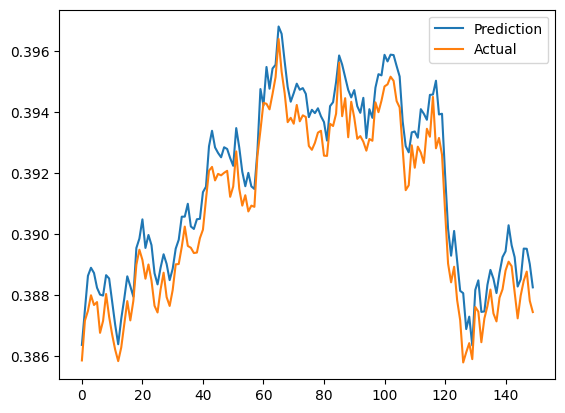

 mape: inf,
 mae: 0.0006290803490051908,
 mpe: inf,
 rmse: 0.0008672436033134947,
 corr: 0.9999919734613768,
 minmax: 
(inf, 0.0006290803490051908, inf, 0.0008672436033134947, 0.9999919734613768)


In [ ]:
get_predictions(model_1_min_8, X_n_train, y_n_train, 'Train')

1250/1250 [==============================] - 25s 20ms/step
       Val Predictions   Actuals
0             0.173927  0.173535
1             0.173661  0.173174
2             0.173733  0.173346
3             0.174029  0.173547
4             0.173987  0.173584
...                ...       ...
39965         0.759650  0.759111
39966         0.759746  0.760172
39967         0.761720  0.760526
39968         0.759161  0.758779
39969         0.760285  0.760174

[39970 rows x 2 columns]


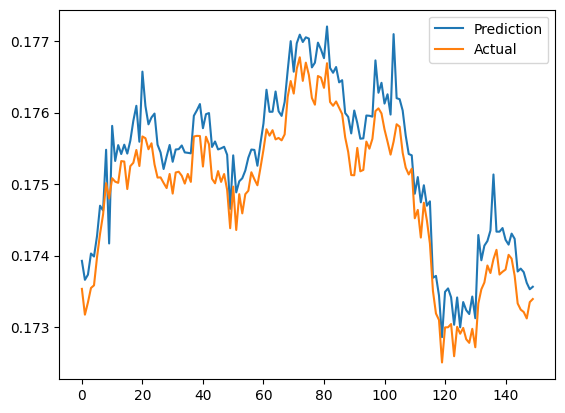

 mape: 0.001281398306726293,
 mae: 0.0007175611430736082,
 mpe: 0.000882013378968172,
 rmse: 0.0009898038856478637,
 corr: 0.9999894330414546,
 minmax: 
(0.001281398306726293, 0.0007175611430736082, 0.000882013378968172, 0.0009898038856478637, 0.9999894330414546)


In [ ]:
get_predictions(model_1_min_8, X_n_val, y_n_val, 'Val')

1250/1250 [==============================] - 25s 20ms/step
       Test Predictions   Actuals
0              0.760301  0.759664
1              0.760516  0.760115
2              0.760396  0.759803
3              0.759108  0.758197
4              0.757992  0.758191
...                 ...       ...
39965          0.723656  0.723299
39966          0.723382  0.722779
39967          0.722611  0.721894
39968          0.721721  0.721556
39969          0.721257  0.720575

[39970 rows x 2 columns]


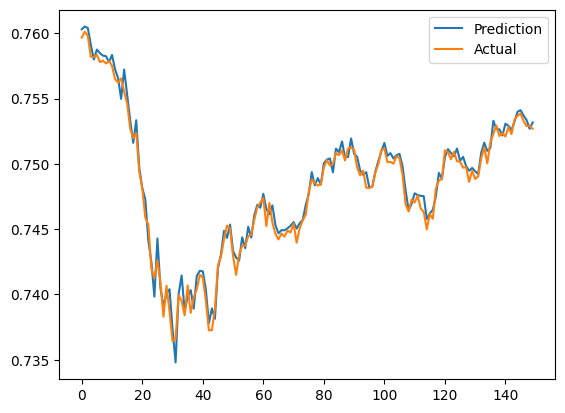

 mape: 0.0012237911024545294,
 mae: 0.0009897963248172161,
 mpe: -0.0001448735831386355,
 rmse: 0.0013291719423187832,
 corr: 0.9999667683106158,
 minmax: 
(0.0012237911024545294, 0.0009897963248172161, -0.0001448735831386355, 0.0013291719423187832, 0.9999667683106158)


In [ ]:
get_predictions(model_1_min_8, X_n_test, y_n_test, 'Test')

***Count unnormalized rmse***

1250/1250 [==============================] - 18s 14ms/step
       Test Predictions   Actuals
0          22907.244141  22905.32
1          22903.488281  22902.29
2          22891.216797  22886.67
3          22880.093750  22886.61
4          22886.246094  22888.05
...                 ...       ...
39965      22540.593750  22542.26
39966      22536.236328  22533.65
39967      22527.587891  22530.37
39968      22519.824219  22520.83
39969      22526.050781  22524.46

[39970 rows x 2 columns]


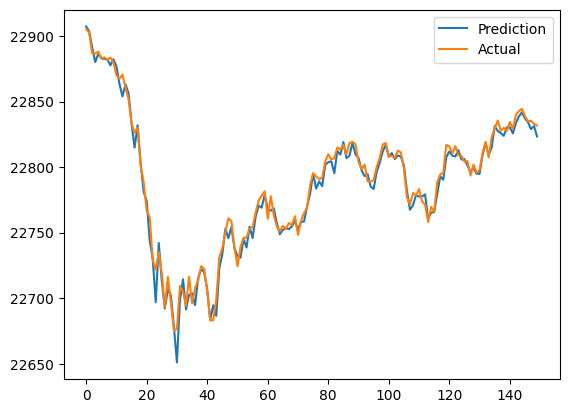

 mape: 0.0003902556610417196,
wape: 0.9995988716232969,
mae: 9.299749908134222,
 mpe: -0.0002788634622622548,
 rmse: 13.118457007137698,
 corr: 0.9999734486994216,
r2_score:0.9998284147489191 minmax: 


(0.0003902556610417196,
 0.9995988716232969,
 9.299749908134222,
 -0.0002788634622622548,
 13.118457007137698,
 0.9999734486994216,
 0.9998284147489191)

In [74]:
smooth_data(parsed_klines[OPR][430000:630000].copy().values.reshape(-1, 1), smoothing_window_size=200000)
get_predictions(model_1_min_8, X_n_test, y_n_test, 'Test', unsmooth=True)

### **Let's count how good model predicts trend direction**

In [ ]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score, f1_score

preds = model_1_min_8.predict(X_n_test).flatten()
pred_diff = np.diff(preds)
true_diff = np.diff(y_n_test)
pred_dir = (pred_diff > 0).astype(np.int32)
true_dir = (true_diff > 0).astype(np.int32)

recall = recall_score(true_dir, pred_dir)
precision = precision_score(true_dir, pred_dir)
f1 = f1_score(true_dir, pred_dir)

{'recall': recall, 'prec': precision, 'f1': f1}

1250/1250 [==============================] - 24s 19ms/step


{'recall': 0.7388713456249363,
 'prec': 0.730647192143037,
 'f1': 0.7347362556661349}

## Time to check predictions for five minutes and more

### 5 mins

In [ ]:
lstm_neurons, lr, mins = 24, 0.001, 5
X_n_train, y_n_train, X_n_val, y_n_val, X_n_test, y_n_test = build_data(parsed_klines, mins,
                                                                        df_start=0,
                                                                        columns=[OPR, HPR, LPR, VOL, TN, TAKER],
                                                                        smoothing_window_size=2500)
build_compile_fit_model(lstm_neurons, lr,
                        f'model_{mins}_mins_1/', 10,
                        X_n_train, y_n_train, X_n_val, y_n_val)
model_5_mins_1 = load_model(f'model_{mins}_mins_1/')

WRONG DATA Empty DataFrame
Columns: [date, OPEN TIME, OPEN PRICE, HIGH PRICE, LOW PRICE, CLOSE PRICE, VOLUME, TRADES NUMBER, TAKER]
Index: []
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 24)                2976      
                                                                 
 dense_23 (Dense)            (None, 1)                 25        
                                                                 
Total params: 3,001
Trainable params: 3,001
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
2382/2382 [==============================] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0355

2382/2382 [==============================] - 208s 86ms/step - loss: 0.0013 - root_mean_squared_error: 0.0355 - val_loss: 3.2539e-04 - val_root_mean_squared_error: 0.0180
Epoch 2/10
2382/2382 [==============================] - ETA: 0s - loss: 2.2622e-04 - root_mean_squared_error: 0.0150

2382/2382 [==============================] - 208s 87ms/step - loss: 2.2622e-04 - root_mean_squared_error: 0.0150 - val_loss: 2.1036e-04 - val_root_mean_squared_error: 0.0145
Epoch 3/10
2382/2382 [==============================] - 202s 85ms/step - loss: 1.7128e-04 - root_mean_squared_error: 0.0131 - val_loss: 2.2122e-04 - val_root_mean_squared_error: 0.0149
Epoch 4/10
2382/2382 [==============================] - ETA: 0s - loss: 1.5367e-04 - root_mean_squared_error: 0.0124

2382/2382 [==============================] - 198s 83ms/step - loss: 1.5367e-04 - root_mean_squared_error: 0.0124 - val_loss: 1.5940e-04 - val_root_mean_squared_error: 0.0126
Epoch 5/10
2382/2382 [==============================] - ETA: 0s - loss: 1.4424e-04 - root_mean_squared_error: 0.0120

2382/2382 [==============================] - 196s 82ms/step - loss: 1.4424e-04 - root_mean_squared_error: 0.0120 - val_loss: 1.4337e-04 - val_root_mean_squared_error: 0.0120
Epoch 6/10
2382/2382 [==============================] - ETA: 0s - loss: 1.3344e-04 - root_mean_squared_error: 0.0116

2382/2382 [==============================] - 202s 85ms/step - loss: 1.3344e-04 - root_mean_squared_error: 0.0116 - val_loss: 1.3022e-04 - val_root_mean_squared_error: 0.0114
Epoch 7/10
2382/2382 [==============================] - 185s 77ms/step - loss: 1.2624e-04 - root_mean_squared_error: 0.0112 - val_loss: 2.0155e-04 - val_root_mean_squared_error: 0.0142
Epoch 8/10
2382/2382 [==============================] - ETA: 0s - loss: 1.2349e-04 - root_mean_squared_error: 0.0111

2382/2382 [==============================] - 197s 83ms/step - loss: 1.2349e-04 - root_mean_squared_error: 0.0111 - val_loss: 1.1062e-04 - val_root_mean_squared_error: 0.0105
Epoch 9/10
2382/2382 [==============================] - 205s 86ms/step - loss: 1.2037e-04 - root_mean_squared_error: 0.0110 - val_loss: 1.2783e-04 - val_root_mean_squared_error: 0.0113
Epoch 10/10
2382/2382 [==============================] - 201s 85ms/step - loss: 1.2017e-04 - root_mean_squared_error: 0.0110 - val_loss: 1.7973e-04 - val_root_mean_squared_error: 0.0134


2382/2382 [==============================] - 46s 19ms/step
       Train Predictions   Actuals
0               0.814176  0.812446
1               0.823954  0.825727
2               0.828588  0.833451
3               0.832938  0.835563
4               0.838238  0.845686
...                  ...       ...
76210           0.411721  0.413805
76211           0.402810  0.405410
76212           0.392562  0.392937
76213           0.401808  0.410446
76214           0.400688  0.410466

[76215 rows x 2 columns]


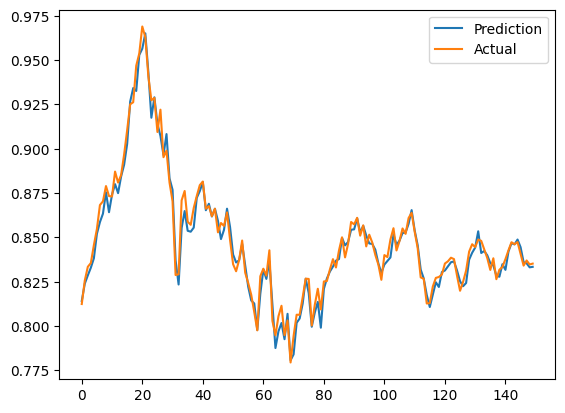

 mape: inf,
 mae: 0.0046484016727907865,
 mpe: nan,
 rmse: 0.010581172648711031,
 corr: 0.9991766165065155,
 minmax: 
(inf, 0.0046484016727907865, nan, 0.010581172648711031, 0.9991766165065155)


In [ ]:
get_predictions(model_5_mins_1, X_n_train, y_n_train, 'Train')

794/794 [==============================] - 15s 19ms/step
       Val Predictions   Actuals
0             0.406063  0.409730
1             0.395432  0.406916
2             0.414719  0.415452
3             0.418025  0.419068
4             0.409540  0.419140
...                ...       ...
25400         0.146638  0.146842
25401         0.149611  0.152755
25402         0.160308  0.163863
25403         0.158345  0.161590
25404         0.156878  0.156760

[25405 rows x 2 columns]


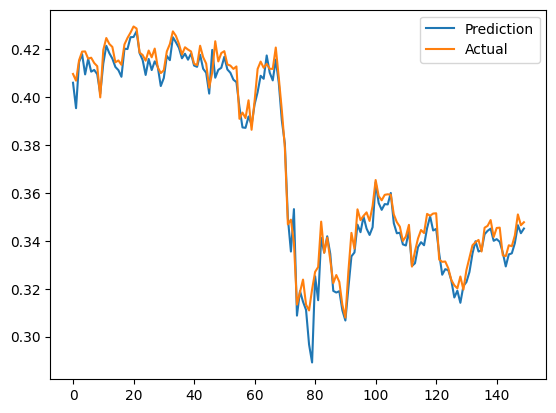

 mape: inf,
 mae: 0.005425220760260474,
 mpe: nan,
 rmse: 0.010517599450465013,
 corr: 0.9991174427585396,
 minmax: 
(inf, 0.005425220760260474, nan, 0.010517599450465013, 0.9991174427585396)


In [ ]:
get_predictions(model_5_mins_1, X_n_val, y_n_val, 'Val')

794/794 [==============================] - 15s 19ms/step
       Test Predictions   Actuals
0              0.165869  0.171036
1              0.159760  0.156539
2              0.151679  0.151319
3              0.157304  0.161370
4              0.164635  0.167761
...                 ...       ...
25400          0.094290  0.097727
25401          0.092233  0.084355
25402          0.096625  0.102654
25403          0.100091  0.099480
25404          0.098181  0.093038

[25405 rows x 2 columns]


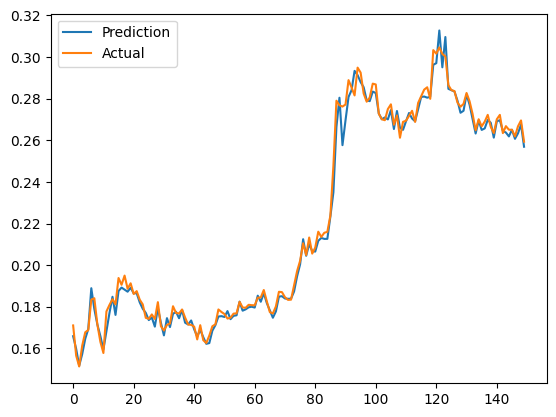

 mape: inf,
 mae: 0.0044892163043902394,
 mpe: nan,
 rmse: 0.012338621680063378,
 corr: 0.9990353697285823,
 minmax: 
(inf, 0.0044892163043902394, nan, 0.012338621680063378, 0.9990353697285823)


In [ ]:
get_predictions(model_5_mins_1, X_n_test, y_n_test, 'Test')

### 10 mins

In [ ]:
lstm_neurons, lr, mins = 24, 0.001, 10
X_n_train, y_n_train, X_n_val, y_n_val, X_n_test, y_n_test = build_data(parsed_klines, mins,
                                                                        df_start=0,
                                                                        columns=[OPR, HPR, LPR, VOL, TN, TAKER],
                                                                        smoothing_window_size=2500)
build_compile_fit_model(lstm_neurons, lr,
                        f'model_{mins}_mins_1/', 10,
                        X_n_train, y_n_train, X_n_val, y_n_val)
model_10_mins = load_model(f'model_{mins}_mins/')

WRONG DATA Empty DataFrame
Columns: [date, OPEN TIME, OPEN PRICE, HIGH PRICE, LOW PRICE, CLOSE PRICE, VOLUME, TRADES NUMBER, TAKER]
Index: []
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24)                2976      
                                                                 
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 3,001
Trainable params: 3,001
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1190/1190 [==============================] - ETA: 0s - loss: 6.0007e-04 - root_mean_squared_error: 0.0245

1190/1190 [==============================] - 99s 81ms/step - loss: 6.0007e-04 - root_mean_squared_error: 0.0245 - val_loss: 3.9610e-04 - val_root_mean_squared_error: 0.0199
Epoch 2/10
1190/1190 [==============================] - ETA: 0s - loss: 2.8851e-04 - root_mean_squared_error: 0.0170

1190/1190 [==============================] - 91s 76ms/step - loss: 2.8851e-04 - root_mean_squared_error: 0.0170 - val_loss: 1.9342e-04 - val_root_mean_squared_error: 0.0139
Epoch 3/10
1190/1190 [==============================] - ETA: 0s - loss: 2.2570e-04 - root_mean_squared_error: 0.0150

1190/1190 [==============================] - 97s 82ms/step - loss: 2.2570e-04 - root_mean_squared_error: 0.0150 - val_loss: 1.5892e-04 - val_root_mean_squared_error: 0.0126
Epoch 4/10
1190/1190 [==============================] - ETA: 0s - loss: 1.9565e-04 - root_mean_squared_error: 0.0140

1190/1190 [==============================] - 96s 81ms/step - loss: 1.9565e-04 - root_mean_squared_error: 0.0140 - val_loss: 1.4374e-04 - val_root_mean_squared_error: 0.0120
Epoch 5/10
1190/1190 [==============================] - ETA: 0s - loss: 1.7831e-04 - root_mean_squared_error: 0.0134

1190/1190 [==============================] - 94s 79ms/step - loss: 1.7831e-04 - root_mean_squared_error: 0.0134 - val_loss: 1.2219e-04 - val_root_mean_squared_error: 0.0111
Epoch 6/10
1190/1190 [==============================] - ETA: 0s - loss: 1.6837e-04 - root_mean_squared_error: 0.0130

1190/1190 [==============================] - 90s 76ms/step - loss: 1.6837e-04 - root_mean_squared_error: 0.0130 - val_loss: 1.1272e-04 - val_root_mean_squared_error: 0.0106
Epoch 7/10
1190/1190 [==============================] - ETA: 0s - loss: 1.6098e-04 - root_mean_squared_error: 0.0127

1190/1190 [==============================] - 93s 78ms/step - loss: 1.6098e-04 - root_mean_squared_error: 0.0127 - val_loss: 1.0603e-04 - val_root_mean_squared_error: 0.0103
Epoch 8/10
1190/1190 [==============================] - 89s 75ms/step - loss: 1.5777e-04 - root_mean_squared_error: 0.0126 - val_loss: 1.0808e-04 - val_root_mean_squared_error: 0.0104
Epoch 9/10
1190/1190 [==============================] - ETA: 0s - loss: 1.5342e-04 - root_mean_squared_error: 0.0124

1190/1190 [==============================] - 91s 77ms/step - loss: 1.5342e-04 - root_mean_squared_error: 0.0124 - val_loss: 9.4673e-05 - val_root_mean_squared_error: 0.0097
Epoch 10/10
1190/1190 [==============================] - 88s 74ms/step - loss: 1.4702e-04 - root_mean_squared_error: 0.0121 - val_loss: 9.4768e-05 - val_root_mean_squared_error: 0.0097


1190/1190 [==============================] - 20s 16ms/step
       Train Predictions   Actuals
0               0.905761  0.907310
1               0.901629  0.901438
2               0.893288  0.892372
3               0.899960  0.904750
4               0.908708  0.912939
...                  ...       ...
38057           0.420503  0.425806
38058           0.423026  0.421107
38059           0.416435  0.419266
38060           0.407185  0.398683
38061           0.396760  0.398983

[38062 rows x 2 columns]


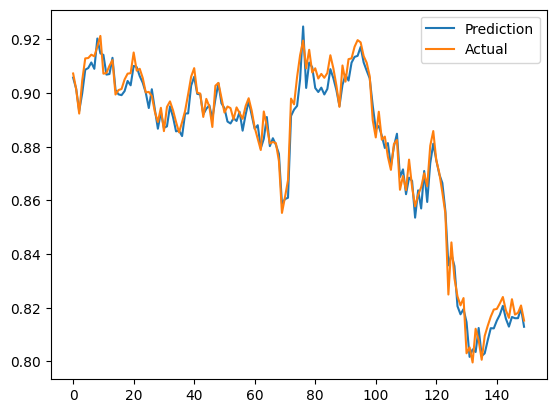

 mape: inf,
 mae: 0.005486437177239646,
 mpe: nan,
 rmse: 0.011890487221057523,
 corr: 0.9989513043673897,
 minmax: 
(inf, 0.005486437177239646, nan, 0.011890487221057523, 0.9989513043673897)


In [ ]:
get_predictions(model_10_mins, X_n_train, y_n_train, 'Train')

397/397 [==============================] - 7s 17ms/step
       Val Predictions   Actuals
0             0.401178  0.394158
1             0.405451  0.419235
2             0.418367  0.419725
3             0.423233  0.419313
4             0.419924  0.428079
...                ...       ...
12682         0.337878  0.337480
12683         0.338318  0.335438
12684         0.334018  0.333196
12685         0.328687  0.326069
12686         0.326099  0.327396

[12687 rows x 2 columns]


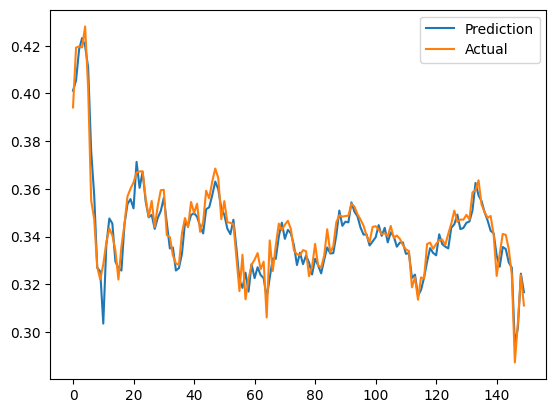

 mape: inf,
 mae: 0.005405677136452103,
 mpe: nan,
 rmse: 0.00973000102350817,
 corr: 0.9993345762594071,
 minmax: 
(inf, 0.005405677136452103, nan, 0.00973000102350817, 0.9993345762594071)


In [ ]:
get_predictions(model_10_mins, X_n_val, y_n_val, 'Val')

397/397 [==============================] - 6s 16ms/step
       Test Predictions   Actuals
0              0.326928  0.332209
1              0.324869  0.321096
2              0.325354  0.323847
3              0.327758  0.327977
4              0.327834  0.329334
...                 ...       ...
12684          0.114326  0.119186
12685          0.113520  0.105656
12686          0.102594  0.094277
12687          0.093931  0.099223
12688          0.099822  0.089570

[12689 rows x 2 columns]


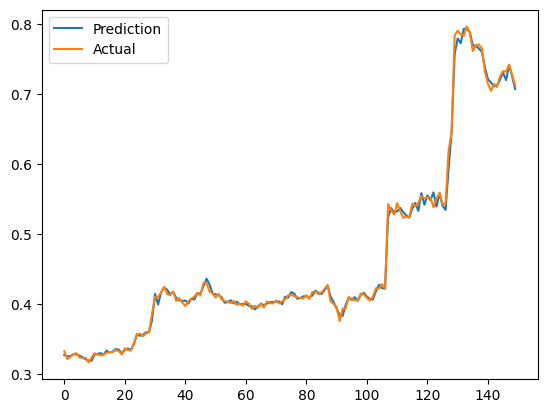

 mape: inf,
 mae: 0.005184883970628466,
 mpe: nan,
 rmse: 0.012402311710409416,
 corr: 0.9989692278741349,
 minmax: 
(inf, 0.005184883970628466, nan, 0.012402311710409416, 0.9989692278741349)


In [ ]:
get_predictions(model_10_mins, X_n_test, y_n_test, 'Test')

397/397 [==============================] - 6s 16ms/step


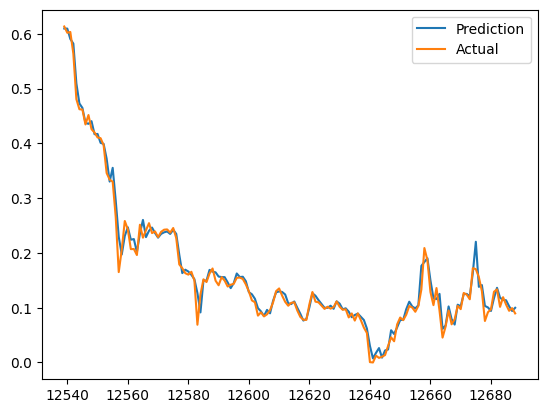

In [ ]:
name = 'Test'

predictions = model_10_mins.predict(X_n_test).flatten()
results = pd.DataFrame(data={f'{name} Predictions': predictions, 'Actuals':y_n_test})

plt.plot(results[f'{name} Predictions'][-150:], label='Prediction')
plt.plot(results['Actuals'][-150:], label='Actual')
plt.legend()
plt.show()

In [ ]:
results.loc[results['Actuals'] == 0, 'Actuals'] = results[results['Actuals'] == 0][f'{name} Predictions']
output_stats(results[f'{name} Predictions'], results['Actuals'])

 mape: 0.19491434956985626,
 mae: 0.005178999634596938,
 mpe: 0.1572550819616863,
 rmse: 0.012395812114371494,
 corr: 0.9989702078614068,
 minmax: 


(0.19491434956985626,
 0.005178999634596938,
 0.1572550819616863,
 0.012395812114371494,
 0.9989702078614068)

*As we see last data was predicted not even good, so let's try to divide data on batches*

In [ ]:
lstm_neurons, lr, mins = 24, 0.001, 10
X_n_train_b, y_n_train_b, X_n_val_b, y_n_val_b, X_n_test_b, y_n_test_b = build_data(
    parsed_klines, mins,
    df_start=0,
    columns=[OPR, HPR, LPR, VOL, TN, TAKER],
    smoothing_window_size=2500,
    batch=True
)

build_compile_fit_model(lstm_neurons, lr,
                        f'model_{mins}_mins_1/', 10,
                        X_n_train, y_n_train, X_n_val, y_n_val)
model_10_mins_batch = load_model(f'model_{mins}_mins_batch/')

WRONG DATA Empty DataFrame
Columns: [date, OPEN TIME, OPEN PRICE, HIGH PRICE, LOW PRICE, CLOSE PRICE, VOLUME, TRADES NUMBER, TAKER]
Index: []
(38063, 150, 6) (12688, 150, 6) (12687, 150, 6)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 24)                2976      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 3,001
Trainable params: 3,001
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1190/1190 [==============================] - ETA: 0s - loss: 0.0028 - root_mean_squared_error: 0.0529

1190/1190 [==============================] - 100s 82ms/step - loss: 0.0028 - root_mean_squared_error: 0.0529 - val_loss: 5.7339e-04 - val_root_mean_squared_error: 0.0239
Epoch 2/10
1190/1190 [==============================] - ETA: 0s - loss: 4.3248e-04 - root_mean_squared_error: 0.0208

1190/1190 [==============================] - 90s 76ms/step - loss: 4.3248e-04 - root_mean_squared_error: 0.0208 - val_loss: 3.4013e-04 - val_root_mean_squared_error: 0.0184
Epoch 3/10
1190/1190 [==============================] - ETA: 0s - loss: 3.2750e-04 - root_mean_squared_error: 0.0181

1190/1190 [==============================] - 95s 80ms/step - loss: 3.2750e-04 - root_mean_squared_error: 0.0181 - val_loss: 2.4362e-04 - val_root_mean_squared_error: 0.0156
Epoch 4/10
1190/1190 [==============================] - ETA: 0s - loss: 2.8109e-04 - root_mean_squared_error: 0.0168

1190/1190 [==============================] - 91s 77ms/step - loss: 2.8109e-04 - root_mean_squared_error: 0.0168 - val_loss: 1.5758e-04 - val_root_mean_squared_error: 0.0126
Epoch 5/10
1190/1190 [==============================] - ETA: 0s - loss: 2.5204e-04 - root_mean_squared_error: 0.0159

1190/1190 [==============================] - 91s 77ms/step - loss: 2.5204e-04 - root_mean_squared_error: 0.0159 - val_loss: 1.1619e-04 - val_root_mean_squared_error: 0.0108
Epoch 6/10
1190/1190 [==============================] - ETA: 0s - loss: 2.3666e-04 - root_mean_squared_error: 0.0154

1190/1190 [==============================] - 95s 80ms/step - loss: 2.3666e-04 - root_mean_squared_error: 0.0154 - val_loss: 8.9858e-05 - val_root_mean_squared_error: 0.0095
Epoch 7/10
1190/1190 [==============================] - ETA: 0s - loss: 2.3120e-04 - root_mean_squared_error: 0.0152

1190/1190 [==============================] - 98s 82ms/step - loss: 2.3120e-04 - root_mean_squared_error: 0.0152 - val_loss: 8.0843e-05 - val_root_mean_squared_error: 0.0090
Epoch 8/10
1190/1190 [==============================] - ETA: 0s - loss: 2.1879e-04 - root_mean_squared_error: 0.0148

1190/1190 [==============================] - 91s 77ms/step - loss: 2.1879e-04 - root_mean_squared_error: 0.0148 - val_loss: 7.8625e-05 - val_root_mean_squared_error: 0.0089
Epoch 9/10
1190/1190 [==============================] - ETA: 0s - loss: 2.1445e-04 - root_mean_squared_error: 0.0146

1190/1190 [==============================] - 94s 79ms/step - loss: 2.1445e-04 - root_mean_squared_error: 0.0146 - val_loss: 7.5155e-05 - val_root_mean_squared_error: 0.0087
Epoch 10/10
1190/1190 [==============================] - ETA: 0s - loss: 2.0853e-04 - root_mean_squared_error: 0.0144

1190/1190 [==============================] - 91s 77ms/step - loss: 2.0853e-04 - root_mean_squared_error: 0.0144 - val_loss: 6.8501e-05 - val_root_mean_squared_error: 0.0083


1190/1190 [==============================] - 21s 17ms/step
       Train Predictions   Actuals
0               0.906936  0.907310
1               0.895279  0.892372
2               0.909742  0.912939
3               0.909997  0.913076
4               0.911026  0.913711
...                  ...       ...
38058           0.112218  0.129141
38059           0.115374  0.101507
38060           0.110114  0.105656
38061           0.099457  0.094277
38062           0.096676  0.089570

[38063 rows x 2 columns]


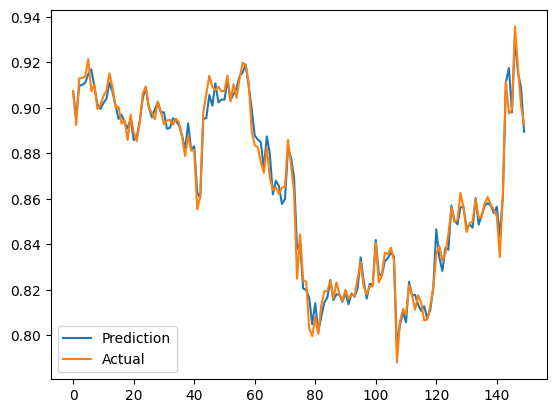

 mape: inf,
 mae: 0.005510526328642761,
 mpe: inf,
 rmse: 0.013776501941799189,
 corr: 0.9986239573126726,
 minmax: 
(inf, 0.005510526328642761, inf, 0.013776501941799189, 0.9986239573126726)


In [ ]:
get_predictions(model_10_mins_batch, X_n_train_b, y_n_train_b, 'Train')

397/397 [==============================] - 6s 15ms/step
       Val Predictions   Actuals
0             0.902946  0.901438
1             0.912368  0.914324
2             0.911303  0.907489
3             0.899225  0.901533
4             0.910127  0.908378
...                ...       ...
12683         0.073653  0.069637
12684         0.119173  0.123733
12685         0.137877  0.130233
12686         0.132676  0.133389
12687         0.090759  0.099223

[12688 rows x 2 columns]


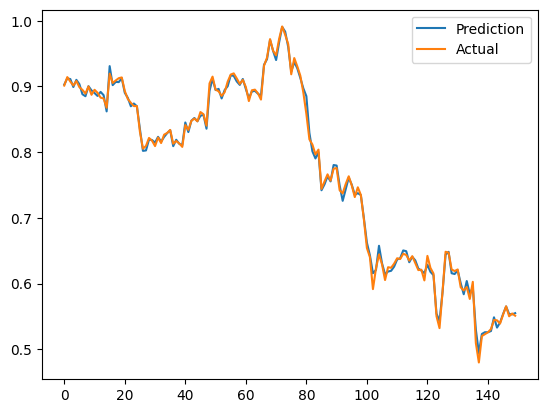

 mape: inf,
 mae: 0.005426278854896631,
 mpe: nan,
 rmse: 0.008276537080974092,
 corr: 0.9995054412971932,
 minmax: 
(inf, 0.005426278854896631, nan, 0.008276537080974092, 0.9995054412971932)


In [ ]:
get_predictions(model_10_mins_batch, X_n_val_b, y_n_val_b, 'Val')

397/397 [==============================] - 8s 19ms/step
       Test Predictions   Actuals
0              0.900946  0.904750
1              0.923928  0.917355
2              0.916702  0.912300
3              0.904995  0.907254
4              0.904325  0.905632
...                 ...       ...
12682          0.057503  0.045406
12683          0.099633  0.103375
12684          0.159807  0.172190
12685          0.094573  0.091738
12686          0.109982  0.119186

[12687 rows x 2 columns]


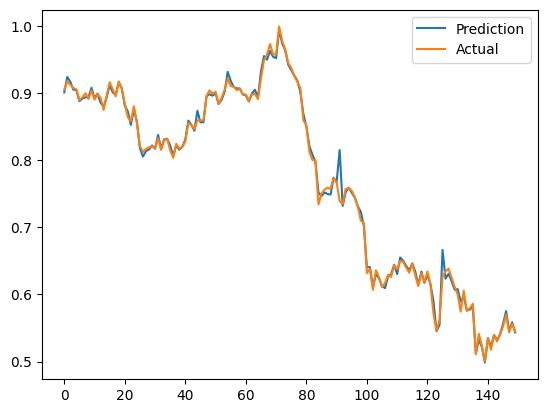

 mape: inf,
 mae: 0.005272376259182098,
 mpe: inf,
 rmse: 0.007638761087605029,
 corr: 0.9995793324811958,
 minmax: 
(inf, 0.005272376259182098, inf, 0.007638761087605029, 0.9995793324811958)


In [ ]:
get_predictions(model_10_mins_batch, X_n_test_b, y_n_test_b, 'Test')

Check for continous data from prev step

397/397 [==============================] - 8s 19ms/step


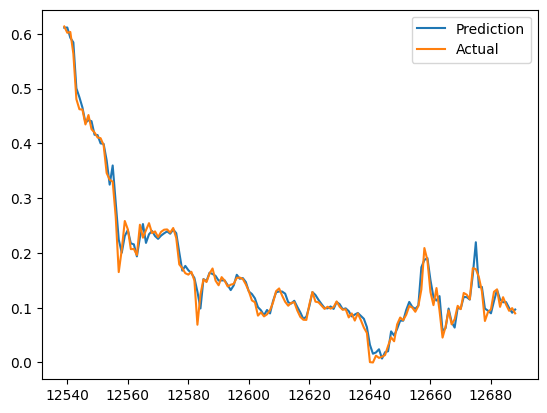

In [ ]:
name = 'Test'

predictions = model_10_mins_batch.predict(X_n_test).flatten()
results = pd.DataFrame(data={f'{name} Predictions': predictions, 'Actuals':y_n_test})

plt.plot(results[f'{name} Predictions'][-150:], label='Prediction')
plt.plot(results['Actuals'][-150:], label='Actual')
plt.legend()
plt.show()

In [ ]:
#results.loc[results['Actuals'] == 0, 'Actuals'] = results[results['Actuals'] == 0][f'{name} Predictions']
output_stats(results[f'{name} Predictions'], results['Actuals'])

 mape: inf,
 mae: 0.005140205460826832,
 mpe: inf,
 rmse: 0.012500338363502422,
 corr: 0.9989372702871383,
 minmax: 


(inf, 0.005140205460826832, inf, 0.012500338363502422, 0.9989372702871383)

And look at results on uncontinuous(batch) data from this step

397/397 [==============================] - 6s 15ms/step


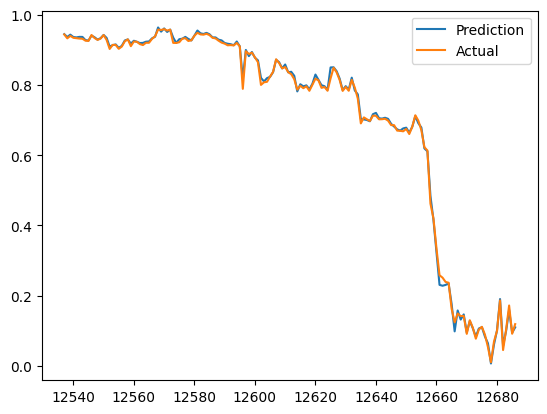

In [ ]:
name = 'Test'

predictions = model_10_mins_batch.predict(X_n_test_b).flatten()
results = pd.DataFrame(data={f'{name} Predictions': predictions, 'Actuals':y_n_test_b})

plt.plot(results[f'{name} Predictions'][-150:], label='Prediction')
plt.plot(results['Actuals'][-150:], label='Actual')
plt.legend()
plt.show()

In [ ]:
results.loc[results['Actuals'] == 0, 'Actuals'] = results[results['Actuals'] == 0][f'{name} Predictions']
output_stats(results[f'{name} Predictions'], results['Actuals'])

 mape: 0.02386723014647676,
 mae: 0.005267282000015178,
 mpe: 0.008364404765799865,
 rmse: 0.007628096423350403,
 corr: 0.9995804450183176,
 minmax: 


(0.02386723014647676,
 0.005267282000015178,
 0.008364404765799865,
 0.007628096423350403,
 0.9995804450183176)

The result of batch model looks pretty similar to unbatch model<br>
They have the same **corr** = 0.9989,<br> **rmse** = 0.01239, 0.01250 (respectively unb, b)<br> **mape** = 0.19, 0.2 (respectively unb, b)<br>
Worth to notice both models can be train more than for 10 epochs and probably will show better results

### 1-hour prediction

**Unbatch**

In [ ]:
lstm_neurons, lr, mins = 24, 0.001, 60
X_n_train, y_n_train, X_n_val, y_n_val, X_n_test, y_n_test = build_data(
    parsed_klines, mins,
    df_start=0,
    columns=[OPR, HPR, LPR, VOL, TN, TAKER],
    smoothing_window_size=2500,
    batch=False
)

build_compile_fit_model(lstm_neurons, lr,
                        f'model_{mins}_mins_1/', 10,
                        X_n_train, y_n_train, X_n_val, y_n_val)
model_60_mins = load_model(f'model_{mins}_mins/')

WRONG DATA Empty DataFrame
Columns: [date, OPEN TIME, OPEN PRICE, HIGH PRICE, LOW PRICE, CLOSE PRICE, VOLUME, TRADES NUMBER, TAKER]
Index: []
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 24)                2976      
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 3,001
Trainable params: 3,001
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
196/196 [==============================] - ETA: 0s - loss: 0.0106 - root_mean_squared_error: 0.1027

196/196 [==============================] - 36s 174ms/step - loss: 0.0106 - root_mean_squared_error: 0.1027 - val_loss: 7.2650e-04 - val_root_mean_squared_error: 0.0270
Epoch 2/10
196/196 [==============================] - 23s 117ms/step - loss: 7.8344e-04 - root_mean_squared_error: 0.0280 - val_loss: 8.6453e-04 - val_root_mean_squared_error: 0.0294
Epoch 3/10
196/196 [==============================] - ETA: 0s - loss: 6.3855e-04 - root_mean_squared_error: 0.0253

196/196 [==============================] - 24s 124ms/step - loss: 6.3855e-04 - root_mean_squared_error: 0.0253 - val_loss: 5.2032e-04 - val_root_mean_squared_error: 0.0228
Epoch 4/10
196/196 [==============================] - ETA: 0s - loss: 5.3762e-04 - root_mean_squared_error: 0.0232

196/196 [==============================] - 23s 119ms/step - loss: 5.3762e-04 - root_mean_squared_error: 0.0232 - val_loss: 4.5203e-04 - val_root_mean_squared_error: 0.0213
Epoch 5/10
196/196 [==============================] - ETA: 0s - loss: 4.6672e-04 - root_mean_squared_error: 0.0216

196/196 [==============================] - 19s 98ms/step - loss: 4.6672e-04 - root_mean_squared_error: 0.0216 - val_loss: 4.4884e-04 - val_root_mean_squared_error: 0.0212
Epoch 6/10
196/196 [==============================] - ETA: 0s - loss: 4.2374e-04 - root_mean_squared_error: 0.0206

196/196 [==============================] - 21s 106ms/step - loss: 4.2374e-04 - root_mean_squared_error: 0.0206 - val_loss: 3.7205e-04 - val_root_mean_squared_error: 0.0193
Epoch 7/10
196/196 [==============================] - ETA: 0s - loss: 3.8057e-04 - root_mean_squared_error: 0.0195

196/196 [==============================] - 21s 110ms/step - loss: 3.8057e-04 - root_mean_squared_error: 0.0195 - val_loss: 3.1520e-04 - val_root_mean_squared_error: 0.0178
Epoch 8/10
196/196 [==============================] - 15s 75ms/step - loss: 3.4823e-04 - root_mean_squared_error: 0.0187 - val_loss: 4.2581e-04 - val_root_mean_squared_error: 0.0206
Epoch 9/10
196/196 [==============================] - ETA: 0s - loss: 3.2071e-04 - root_mean_squared_error: 0.0179

196/196 [==============================] - 19s 99ms/step - loss: 3.2071e-04 - root_mean_squared_error: 0.0179 - val_loss: 2.6617e-04 - val_root_mean_squared_error: 0.0163
Epoch 10/10
196/196 [==============================] - 14s 74ms/step - loss: 3.0255e-04 - root_mean_squared_error: 0.0174 - val_loss: 3.6496e-04 - val_root_mean_squared_error: 0.0191


196/196 [==============================] - 5s 21ms/step
      Train Predictions   Actuals
0              0.730479  0.738492
1              0.741756  0.768513
2              0.755299  0.768444
3              0.758148  0.758163
4              0.757228  0.759418
...                 ...       ...
6263           0.228366  0.228118
6264           0.228015  0.226411
6265           0.226373  0.218111
6266           0.224892  0.225489
6267           0.227332  0.231747

[6268 rows x 2 columns]


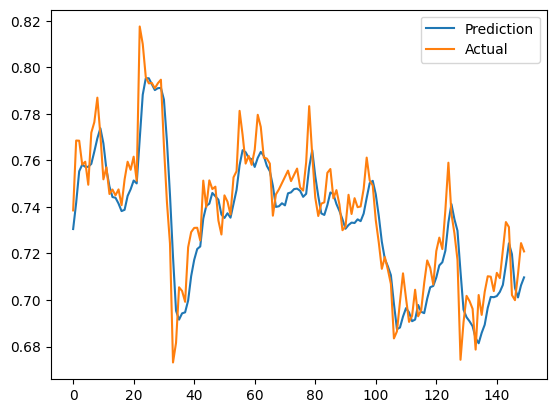

 mape: inf,
 mae: 0.01065786900603575,
 mpe: inf,
 rmse: 0.017963556000827708,
 corr: 0.9976690063303604,
 minmax: 
(inf, 0.01065786900603575, inf, 0.017963556000827708, 0.9976690063303604)


In [ ]:
get_predictions(model_60_mins, X_n_train, y_n_train, 'Train')

66/66 [==============================] - 1s 22ms/step
      Val Predictions   Actuals
0            0.231870  0.235358
1            0.237822  0.241549
2            0.250914  0.266593
3            0.260578  0.259526
4            0.262286  0.257580
...               ...       ...
2084         0.202576  0.204266
2085         0.208702  0.210318
2086         0.213919  0.208293
2087         0.238825  0.263591
2088         0.256071  0.260373

[2089 rows x 2 columns]


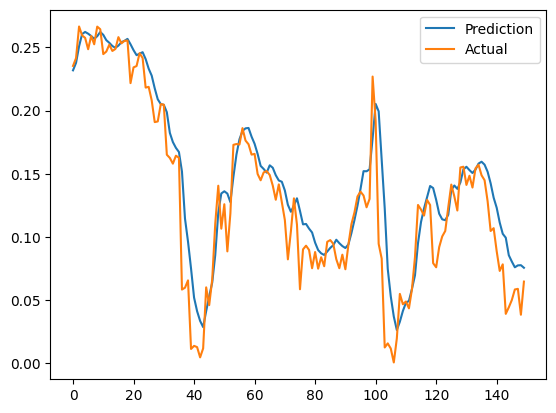

 mape: inf,
 mae: 0.00967159643165961,
 mpe: inf,
 rmse: 0.016314718833471135,
 corr: 0.9939789116316422,
 minmax: 
(inf, 0.00967159643165961, inf, 0.016314718833471135, 0.9939789116316422)


In [ ]:
get_predictions(model_60_mins, X_n_val, y_n_val, 'Val')

66/66 [==============================] - 1s 15ms/step
      Test Predictions   Actuals
0             0.263479  0.246527
1             0.262736  0.247081
2             0.257839  0.233771
3             0.250157  0.241861
4             0.247201  0.245156
...                ...       ...
2086          0.088175  0.103145
2087          0.099697  0.036153
2088          0.095739  0.070128
2089          0.111775  0.071990
2090          0.101947  0.056111

[2091 rows x 2 columns]


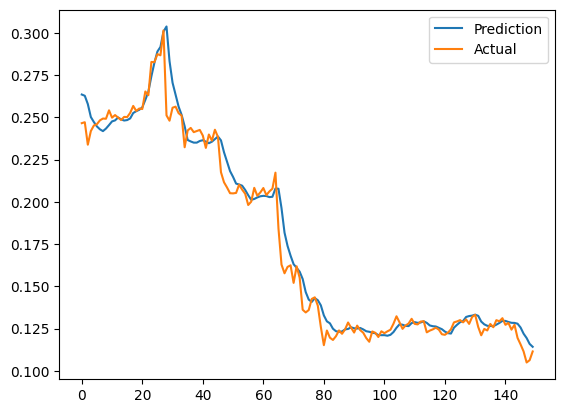

 mape: inf,
 mae: 0.009520576720161432,
 mpe: inf,
 rmse: 0.017242230339514053,
 corr: 0.9985723302884504,
 minmax: 
(inf, 0.009520576720161432, inf, 0.017242230339514053, 0.9985723302884504)


In [ ]:
get_predictions(model_60_mins, X_n_test, y_n_test, 'Test')

**Batch**

In [ ]:
lstm_neurons, lr, mins = 24, 0.001, 60
X_n_train_b, y_n_train_b, X_n_val_b, y_n_val_b, X_n_test_b, y_n_test_b = build_data(
    parsed_klines, mins,
    df_start=0,
    columns=[OPR, HPR, LPR, VOL, TN, TAKER],
    smoothing_window_size=2500,
    batch=True
)

build_compile_fit_model(lstm_neurons, lr,
                        f'model_{mins}_mins_1/', 10,
                        X_n_train, y_n_train, X_n_val, y_n_val)
model_60_mins_batch = load_model(f'model_{mins}_mins_batch/')

WRONG DATA Empty DataFrame
Columns: [date, OPEN TIME, OPEN PRICE, HIGH PRICE, LOW PRICE, CLOSE PRICE, VOLUME, TRADES NUMBER, TAKER]
Index: []
(6269, 150, 6) (2090, 150, 6) (2089, 150, 6)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 24)                2976      
                                                                 
 dense_2 (Dense)             (None, 1)                 25        
                                                                 
Total params: 3,001
Trainable params: 3,001
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
196/196 [==============================] - ETA: 0s - loss: 0.0111 - root_mean_squared_error: 0.1052

196/196 [==============================] - 25s 116ms/step - loss: 0.0111 - root_mean_squared_error: 0.1052 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0365
Epoch 2/10
196/196 [==============================] - ETA: 0s - loss: 0.0010 - root_mean_squared_error: 0.0320

196/196 [==============================] - 33s 169ms/step - loss: 0.0010 - root_mean_squared_error: 0.0320 - val_loss: 8.7722e-04 - val_root_mean_squared_error: 0.0296
Epoch 3/10
196/196 [==============================] - ETA: 0s - loss: 7.3090e-04 - root_mean_squared_error: 0.0270

196/196 [==============================] - 29s 151ms/step - loss: 7.3090e-04 - root_mean_squared_error: 0.0270 - val_loss: 6.6116e-04 - val_root_mean_squared_error: 0.0257
Epoch 4/10
196/196 [==============================] - 15s 74ms/step - loss: 5.8876e-04 - root_mean_squared_error: 0.0243 - val_loss: 7.5831e-04 - val_root_mean_squared_error: 0.0275
Epoch 5/10
196/196 [==============================] - ETA: 0s - loss: 5.1786e-04 - root_mean_squared_error: 0.0228

196/196 [==============================] - 23s 117ms/step - loss: 5.1786e-04 - root_mean_squared_error: 0.0228 - val_loss: 4.9774e-04 - val_root_mean_squared_error: 0.0223
Epoch 6/10
196/196 [==============================] - ETA: 0s - loss: 4.6317e-04 - root_mean_squared_error: 0.0215

196/196 [==============================] - 28s 145ms/step - loss: 4.6317e-04 - root_mean_squared_error: 0.0215 - val_loss: 4.4389e-04 - val_root_mean_squared_error: 0.0211
Epoch 7/10
196/196 [==============================] - ETA: 0s - loss: 4.1702e-04 - root_mean_squared_error: 0.0204

196/196 [==============================] - 25s 128ms/step - loss: 4.1702e-04 - root_mean_squared_error: 0.0204 - val_loss: 3.8092e-04 - val_root_mean_squared_error: 0.0195
Epoch 8/10
196/196 [==============================] - ETA: 0s - loss: 3.7987e-04 - root_mean_squared_error: 0.0195

196/196 [==============================] - 19s 95ms/step - loss: 3.7987e-04 - root_mean_squared_error: 0.0195 - val_loss: 3.1271e-04 - val_root_mean_squared_error: 0.0177
Epoch 9/10
196/196 [==============================] - ETA: 0s - loss: 3.5445e-04 - root_mean_squared_error: 0.0188

196/196 [==============================] - 20s 100ms/step - loss: 3.5445e-04 - root_mean_squared_error: 0.0188 - val_loss: 2.7800e-04 - val_root_mean_squared_error: 0.0167
Epoch 10/10
196/196 [==============================] - ETA: 0s - loss: 3.4130e-04 - root_mean_squared_error: 0.0185

196/196 [==============================] - 20s 102ms/step - loss: 3.4130e-04 - root_mean_squared_error: 0.0185 - val_loss: 2.7205e-04 - val_root_mean_squared_error: 0.0165


196/196 [==============================] - 4s 16ms/step
      Train Predictions   Actuals
0              0.738740  0.738492
1              0.760967  0.768444
2              0.765402  0.759418
3              0.765588  0.749513
4              0.771797  0.776414
...                 ...       ...
6264           0.034770  0.000000
6265           0.030707  0.056981
6266           0.050679  0.036153
6267           0.049451  0.070128
6268           0.063149  0.056111

[6269 rows x 2 columns]


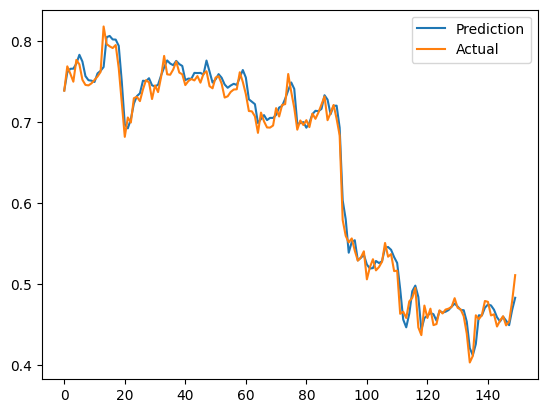

 mape: inf,
 mae: 0.01027350214908169,
 mpe: inf,
 rmse: 0.01803793941566035,
 corr: 0.9979849281048978,
 minmax: 
(inf, 0.01027350214908169, inf, 0.01803793941566035, 0.9979849281048978)


In [ ]:
get_predictions(model_60_mins_batch, X_n_train_b, y_n_train_b, 'Train')

66/66 [==============================] - 1s 22ms/step
      Val Predictions   Actuals
0            0.746809  0.768513
1            0.764153  0.771888
2            0.764171  0.757015
3            0.747940  0.740730
4            0.758839  0.751202
...               ...       ...
2085         0.187699  0.091205
2086         0.083394  0.089745
2087         0.062380  0.045999
2088         0.025673  0.025386
2089         0.065884  0.071990

[2090 rows x 2 columns]


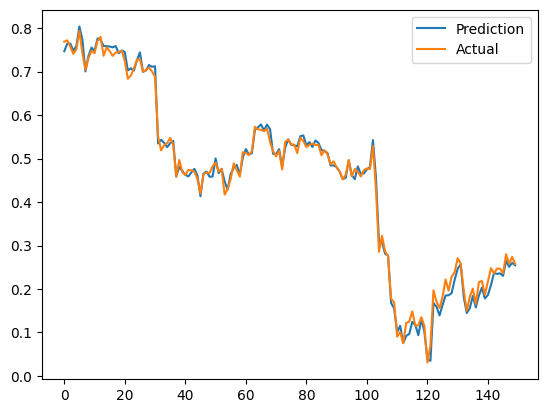

 mape: 0.04882207265733511,
 mae: 0.010265820926043197,
 mpe: 0.02491241444533218,
 rmse: 0.016493842174855392,
 corr: 0.9983381192683245,
 minmax: 
(0.04882207265733511, 0.010265820926043197, 0.02491241444533218, 0.016493842174855392, 0.9983381192683245)


In [ ]:
get_predictions(model_60_mins_batch, X_n_val_b, y_n_val_b, 'Val')

66/66 [==============================] - 1s 16ms/step
      Test Predictions   Actuals
0             0.257063  0.246527
1             0.257826  0.247081
2             0.255345  0.233771
3             0.251133  0.241861
4             0.250883  0.245156
...                ...       ...
2086          0.049974  0.103145
2087          0.050679  0.036153
2088          0.049451  0.070128
2089          0.065884  0.071990
2090          0.063149  0.056111

[2091 rows x 2 columns]


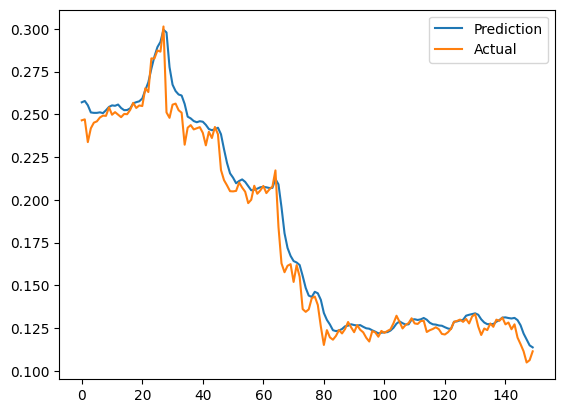

 mape: inf,
 mae: 0.010622366405044327,
 mpe: inf,
 rmse: 0.01698862043533049,
 corr: 0.9988383616767585,
 minmax: 
(inf, 0.010622366405044327, inf, 0.01698862043533049, 0.9988383616767585)


In [ ]:
get_predictions(model_60_mins_batch, X_n_test_b, y_n_test_b, 'Test')

### 1 day

In [75]:
lstm_neurons, lr, mins = 24, 0.001, 60*24
X_n_train, y_n_train, X_n_val, y_n_val, X_n_test, y_n_test = build_data(parsed_klines, mins,
                                                                        df_start=0,
                                                                        df_size=700000,
                                                                        columns=[OPR, HPR, LPR, VOL, TN, TAKER],
                                                                        smoothing_window_size=700000,
                                                                        window_size=10)

WRONG DATA Empty DataFrame
Columns: [date, OPEN TIME, OPEN PRICE, HIGH PRICE, LOW PRICE, CLOSE PRICE, VOLUME, TRADES NUMBER, TAKER, Difference, Direction, Absolute Difference]
Index: []


In [ ]:
build_compile_fit_model(lstm_neurons, lr,
                        f'model_{mins}_mins/', 10,
                        X_n_train, y_n_train, X_n_val, y_n_val)
model_day = load_model(f'model_{mins}_mins/')

WRONG DATA Empty DataFrame
Columns: [date, OPEN TIME, OPEN PRICE, HIGH PRICE, LOW PRICE, CLOSE PRICE, VOLUME, TRADES NUMBER, TAKER]
Index: []
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 24)                2976      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 3,001
Trainable params: 3,001
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
9/9 [==============================] - ETA: 0s - loss: 0.1640 - root_mean_squared_error: 0.4050 

9/9 [==============================] - 8s 591ms/step - loss: 0.1640 - root_mean_squared_error: 0.4050 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0353
Epoch 2/10
9/9 [==============================] - 0s 10ms/step - loss: 0.0387 - root_mean_squared_error: 0.1966 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1180
Epoch 3/10
9/9 [==============================] - 0s 12ms/step - loss: 0.0100 - root_mean_squared_error: 0.1002 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1101
Epoch 4/10
9/9 [==============================] - 0s 10ms/step - loss: 0.0084 - root_mean_squared_error: 0.0917 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0357
Epoch 5/10
9/9 [==============================] - 0s 12ms/step - loss: 0.0033 - root_mean_squared_error: 0.0575 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0374
Epoch 6/10
9/9 [==============================] - 0s 11ms/step - loss: 0.0036 - root_mean_squared_error: 0.0598 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0

In [ ]:
get_predictions(model_day, X_n_train, y_n_train, 'Train')

NameError: ignored

3/3 [==============================] - 0s 4ms/step
    Val Predictions   Actuals
0          0.100151  0.103388
1          0.100949  0.106788
2          0.098581  0.087945
3          0.097441  0.076203
4          0.095763  0.102938
..              ...       ...
81         0.068804  0.041024
82         0.069368  0.038307
83         0.067405  0.038277
84         0.066719  0.037070
85         0.068374  0.040592

[86 rows x 2 columns]


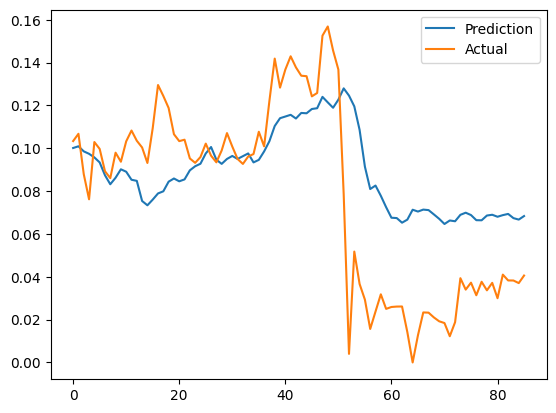

 mape: inf,
 mae: 0.02787285319641997,
 mpe: inf,
 rmse: 0.03526102480894412,
 corr: 0.7030763998656449,
 minmax: 
(inf, 0.02787285319641997, inf, 0.03526102480894412, 0.7030763998656449)


In [ ]:
get_predictions(model_day, X_n_val, y_n_val, 'Val')

3/3 [==============================] - 0s 6ms/step
    Test Predictions   Actuals
0           0.072883  0.056711
1           0.076035  0.057512
2           0.075711  0.044801
3           0.075739  0.024174
4           0.072607  0.028327
..               ...       ...
82          0.159035  0.189051
83          0.156854  0.188459
84          0.156635  0.182464
85          0.155361  0.168412
86          0.153547  0.130250

[87 rows x 2 columns]


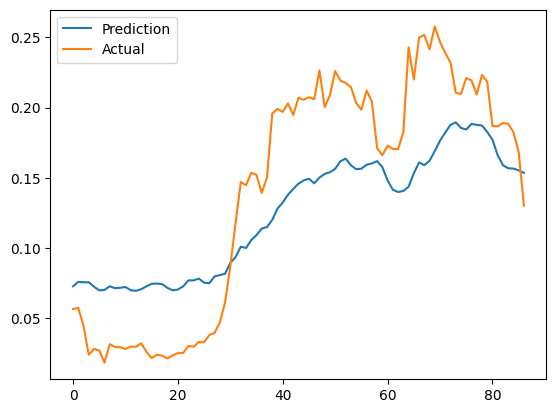

 mape: 0.6550348305969793,
 mae: 0.04448452690715548,
 mpe: 0.3616149870884644,
 rmse: 0.04844832462882074,
 corr: 0.9392733032035607,
 minmax: 
(0.6550348305969793, 0.04448452690715548, 0.3616149870884644, 0.04844832462882074, 0.9392733032035607)


In [ ]:
get_predictions(model_day, X_n_test, y_n_test, 'Test')

9/9 [==============================] - 1s 4ms/step
     Train Predictions   Actuals
0             0.894710  0.895786
1             0.863401  0.871899
2             0.869471  0.854439
3             0.804702  0.786743
4             0.768841  0.776256
..                 ...       ...
254           0.154999  0.124888
255           0.117757  0.126411
256           0.121759  0.111475
257           0.108490  0.114359
258           0.120450  0.123153

[259 rows x 2 columns]


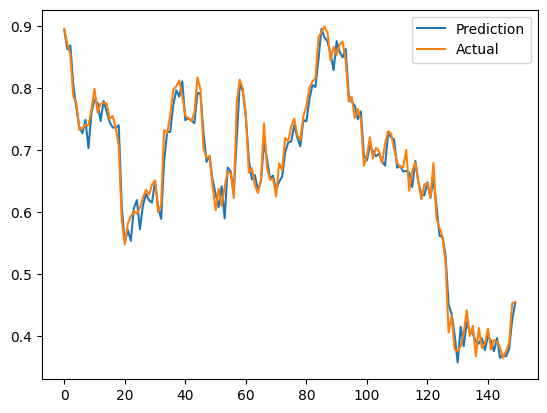

 mape: 0.03891766142704405,
 mae: 0.012751336010386234,
 mpe: -0.0035873668093061367,
 rmse: 0.016564143102504456,
 corr: 0.998149952800071,
r2_score: 0.9961142822360818,
 minmax: 
(0.03891766142704405, 0.012751336010386234, -0.0035873668093061367, 0.016564143102504456, 0.998149952800071, 0.9961142822360818)


In [ ]:
#Check on 1min model for 1 day pred
model_one_min = load_model(f'model_1_mins/')
get_predictions(model_one_min, X_n_train, y_n_train, 'Train')

3/3 [==============================] - 0s 5ms/step
    Test Predictions   Actuals
0           0.051345  0.056711
1           0.063638  0.057512
2           0.047614  0.044801
3           0.034069  0.024174
4           0.024115  0.028327
..               ...       ...
82          0.188968  0.189051
83          0.187947  0.188459
84          0.182166  0.182464
85          0.172820  0.168412
86          0.143043  0.130250

[87 rows x 2 columns]


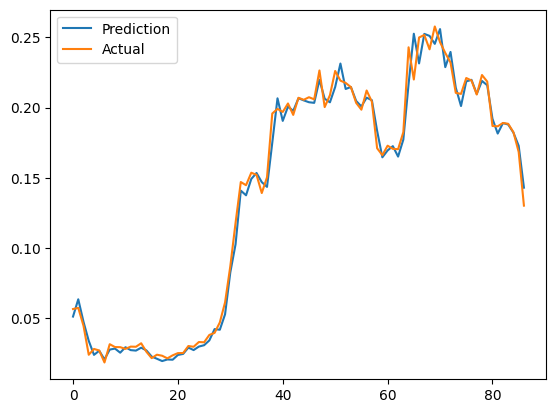

 mape: 0.05462213018589731,
 mae: 0.00523785409640624,
 mpe: -0.016974058962670787,
 rmse: 0.007623058874391266,
 corr: 0.9959268544203963,
r2_score: 0.9915797770132232,
 minmax: 
(0.05462213018589731, 0.00523785409640624, -0.016974058962670787, 0.007623058874391266, 0.9959268544203963, 0.9915797770132232)


In [ ]:
#Check on 1min model for 1 day pred
model_one_min = load_model(f'model_1_mins/')
get_predictions(model_one_min, X_n_test, y_n_test, 'Test')

***Count unnormalized rmse***

3/3 [==============================] - 0s 4ms/step
    Test Predictions       Actuals
0       17380.410156  17581.692509
1       17745.248047  17610.918825
2       17071.968750  17147.434463
3       16633.320312  16395.305248
4       16286.959961  16546.713941
..               ...           ...
82      22274.029297  22407.217358
83      22189.855469  22385.621610
84      21971.769531  22167.020385
85      21645.330078  21654.663072
86      20492.394531  20263.162857

[87 rows x 2 columns]


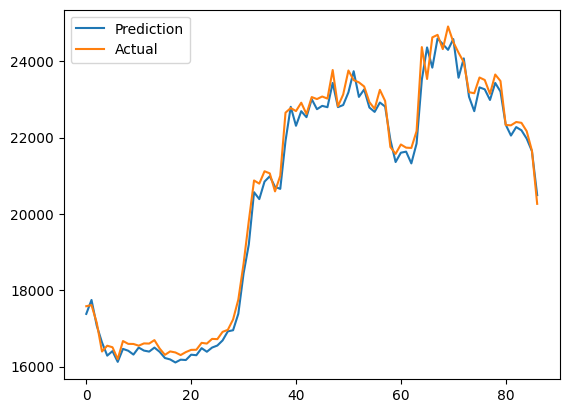

 mape: 0.011532135942598908,
wape: 0.98833039547701,
mae: 240.5665235168993,
 mpe: -0.009060530202373376,
 rmse: 300.90533334723744,
 corr: 0.9969825223558999,
r2_score:0.9901322271698292 minmax: 


(0.011532135942598908,
 0.98833039547701,
 240.5665235168993,
 -0.009060530202373376,
 300.90533334723744,
 0.9969825223558999,
 0.9901322271698292)

In [76]:
smooth_data(parsed_klines[OPR].copy().values.reshape(-1, 1), smoothing_window_size=700000)
get_predictions(model_1_min_8, X_n_test, y_n_test, 'Test', unsmooth=True)

In [ ]:
parsed_klines[OPR].max(), parsed_klines[OPR].min()

(51956.66, 15513.84)

## Predict price difference

What if instead of predicting price predicts its difference. Will it be better?

In [36]:
lstm_neurons, lr, mins = 24, 0.001, 1
X_n_train, y_n_train, X_n_val, y_n_val, X_n_test, y_n_test = build_data(parsed_klines, mins,
                                                                        df_start=430000,
                                                                        columns=[A_DIF, HPR, LPR, VOL, TN, TAKER],
                                                                        smoothing_window_size=200000)

WRONG DATA Empty DataFrame
Columns: [date, OPEN TIME, OPEN PRICE, HIGH PRICE, LOW PRICE, CLOSE PRICE, VOLUME, TRADES NUMBER, TAKER, Difference, Direction, Absolute Difference]
Index: []


In [37]:
build_compile_fit_model(lstm_neurons, lr,
                        f'model_{mins}_mins_dif/', 10,
                        X_n_train, y_n_train, X_n_val, y_n_val)
model_1_min_dif = load_model('model_1_mins_dif/')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 24)                2976      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 3,001
Trainable params: 3,001
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
3748/3748 [==============================] - ETA: 0s - loss: 9.2518e-05 - root_mean_squared_error: 0.0096

3748/3748 [==============================] - 183s 48ms/step - loss: 9.2518e-05 - root_mean_squared_error: 0.0096 - val_loss: 1.1673e-04 - val_root_mean_squared_error: 0.0108
Epoch 2/10
3748/3748 [==============================] - 214s 57ms/step - loss: 8.4102e-05 - root_mean_squared_error: 0.0092 - val_loss: 1.2126e-04 - val_root_mean_squared_error: 0.0110
Epoch 3/10
3747/3748 [============================>.] - ETA: 0s - loss: 8.2010e-05 - root_mean_squared_error: 0.0091

3748/3748 [==============================] - 182s 49ms/step - loss: 8.2008e-05 - root_mean_squared_error: 0.0091 - val_loss: 1.1376e-04 - val_root_mean_squared_error: 0.0107
Epoch 4/10
3748/3748 [==============================] - 168s 45ms/step - loss: 8.0046e-05 - root_mean_squared_error: 0.0089 - val_loss: 1.2724e-04 - val_root_mean_squared_error: 0.0113
Epoch 5/10
3748/3748 [==============================] - 178s 47ms/step - loss: 7.8052e-05 - root_mean_squared_error: 0.0088 - val_loss: 1.2184e-04 - val_root_mean_squared_error: 0.0110
Epoch 6/10
3747/3748 [============================>.] - ETA: 0s - loss: 7.8017e-05 - root_mean_squared_error: 0.0088

3748/3748 [==============================] - 201s 54ms/step - loss: 7.8016e-05 - root_mean_squared_error: 0.0088 - val_loss: 1.1249e-04 - val_root_mean_squared_error: 0.0106
Epoch 7/10
3748/3748 [==============================] - 193s 52ms/step - loss: 7.6730e-05 - root_mean_squared_error: 0.0088 - val_loss: 1.2248e-04 - val_root_mean_squared_error: 0.0111
Epoch 8/10
3748/3748 [==============================] - ETA: 0s - loss: 7.5623e-05 - root_mean_squared_error: 0.0087

3748/3748 [==============================] - 204s 55ms/step - loss: 7.5623e-05 - root_mean_squared_error: 0.0087 - val_loss: 1.1126e-04 - val_root_mean_squared_error: 0.0105
Epoch 9/10
3748/3748 [==============================] - 192s 51ms/step - loss: 7.5428e-05 - root_mean_squared_error: 0.0087 - val_loss: 1.1287e-04 - val_root_mean_squared_error: 0.0106
Epoch 10/10
3748/3748 [==============================] - ETA: 0s - loss: 7.4434e-05 - root_mean_squared_error: 0.0086

3748/3748 [==============================] - 180s 48ms/step - loss: 7.4434e-05 - root_mean_squared_error: 0.0086 - val_loss: 1.1048e-04 - val_root_mean_squared_error: 0.0105


1250/1250 [==============================] - 19s 15ms/step
       Test Predictions  Actuals
0              5.307798     4.39
1              4.252770     3.03
2              4.163627    15.62
3              6.273772     0.06
4              4.619171     1.44
...                 ...      ...
39965          5.226977     5.06
39966          4.867443     8.61
39967          7.410947     3.28
39968          7.301453     9.54
39969          5.833382     3.63

[39970 rows x 2 columns]


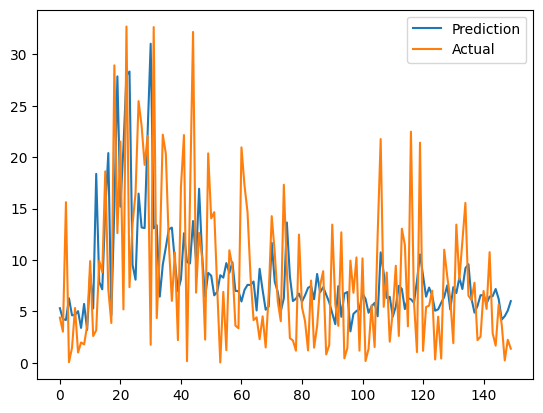

 mape: inf,
wape: 0.43772293164191356,
mae: 5.02685025849591,
 mpe: inf,
 rmse: 7.883592753718344,
 corr: 0.7063869085356027,
r2_score:0.49758936357614214 minmax: 


(inf,
 0.43772293164191356,
 5.02685025849591,
 inf,
 7.883592753718344,
 0.7063869085356027,
 0.49758936357614214)

In [ ]:
model_1_min_dif = load_model(f'model_{mins}_mins_dif/')
smooth_data(parsed_klines[A_DIF][430000:630000].copy().values.reshape(-1, 1), smoothing_window_size=200000)
get_predictions(model_1_min_dif, X_n_test, y_n_test, 'Test', unsmooth=True)

In [ ]:
lstm_neurons, lr, mins = 24, 0.001, 60*24
X_n_train, y_n_train, X_n_val, y_n_val, X_n_test, y_n_test = build_data(parsed_klines, mins,
                                                                        df_start=0, df_size=700000,
                                                                        columns=[A_DIF, HPR, LPR, VOL, TN, TAKER],
                                                                        smoothing_window_size=700000)

WRONG DATA Empty DataFrame
Columns: [date, OPEN TIME, OPEN PRICE, HIGH PRICE, LOW PRICE, CLOSE PRICE, VOLUME, TRADES NUMBER, TAKER, Difference, Direction, Absolute Difference]
Index: []


2/2 [==============================] - 0s 30ms/step
    Test Predictions  Actuals
0         249.036392   504.89
1         325.329071   910.80
2         914.423706  1077.09
3         819.004272  1029.40
4         998.943359    84.68
5         281.058258   307.81
6         561.475403    46.20
7         431.878540   460.33
8         627.892395   403.99
9         338.674011  1607.87
10        813.622253    88.39
11        758.145630    60.13
12        475.917389   200.42
13        538.915222   283.96
14        528.972046   442.75
15        688.084106    61.25
16        451.110504    54.82
17        454.647278    41.07
18         92.159538   724.39
19        498.501343   920.96
20        691.466370   297.25
21        498.985504   585.34
22        690.559570   264.80
23        819.656494    17.62
24        558.382935   109.44
25        150.287506   392.03
26        328.115356   175.91
27        455.080109   491.97
28        630.694275   296.43
29        568.379578  1159.10
30        977.8324

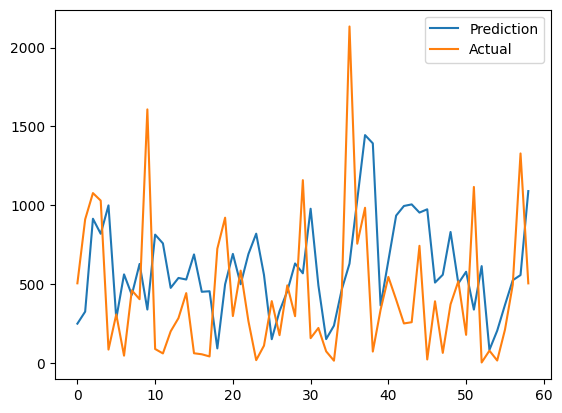

 mape: 7.981020262406013,
wape: 0.024029510708637236,
mae: 426.38116026797536,
 mpe: 7.73925131456328,
 rmse: 544.6891544272476,
 corr: 0.01872300179860881,
r2_score:-0.5967523591173058 minmax: 


(7.981020262406013,
 0.024029510708637236,
 426.38116026797536,
 7.73925131456328,
 544.6891544272476,
 0.01872300179860881,
 -0.5967523591173058)

In [ ]:
model_1_min_dif = load_model(f'model_1_mins_dif/')
smooth_data(agg_to_freq_data(parsed_klines.copy(), mins)[A_DIF].values.reshape(-1, 1), smoothing_window_size=700000)
get_predictions(model_1_min_dif, X_n_test, y_n_test, 'Test', unsmooth=True)

# Results

RMSE for price diff = **7.883**/544.689 *1min/1day*<br>
RMSE for price pred = 13.118/**300.905** *1min/1day* <br>
This means that price difference prediction model works **better for one minute** but significantly **worse for one day**

Now find rmse of actual data to understand how good is the result

In [78]:
parsed_klines

,date,OPEN TIME,OPEN PRICE,HIGH PRICE,LOW PRICE,CLOSE PRICE,VOLUME,TRADES NUMBER,TAKER,Difference,Direction,Absolute Difference
0,2021-12-24 05:01:00,1640322060000,50931.91,50931.97,50876.70,50880.00,25.65137,1185.0,9.06440,-19.50,0,19.50
1,2021-12-24 05:02:00,1640322120000,50876.73,50880.00,50837.71,50837.71,16.19787,1201.0,6.86989,-55.18,0,55.18
2,2021-12-24 05:03:00,1640322180000,50840.81,50919.27,50837.71,50909.47,22.53036,1215.0,13.97411,-35.92,0,35.92
3,2021-12-24 05:04:00,1640322240000,50909.47,50931.95,50869.08,50880.26,14.09173,788.0,4.37506,68.66,1,68.66
4,2021-12-24 05:05:00,1640322300000,50885.58,50895.13,50850.00,50852.82,12.18793,945.0,3.02775,-23.89,0,23.89
...,...,...,...,...,...,...,...,...,...,...,...,...
635867,2023-03-10 18:48:00,1678474080000,19924.80,19931.91,19909.00,19911.25,262.09242,6421.0,120.41953,-3.99,0,3.99
635868,2023-03-10 18:49:00,1678474140000,19912.20,19912.96,19886.76,19892.08,272.13501,6677.0,133.42091,-12.60,0,12.60
635869,2023-03-10 18:50:00,1678474200000,19892.61,19904.63,19885.80,19895.61,279.22393,6247.0,136.15247,-19.59,0,19.59
635870,2023-03-10 18:51:00,1678474260000,19896.19,19896.23,19871.03,19871.03,264.10529,6622.0,126.31206,3.58,1,3.58


In [85]:
output_stats(parsed_klines.loc[590001:630000, CPR].values, parsed_klines.loc[590000:629999, CPR].values)

 mape: 0.0003822306354120428,
wape: 0.9996145838044741,
mae: 8.935390250000015,
 mpe: -2.0838473688582146e-07,
 rmse: 14.260514005199827,
 corr: 0.9998985515847593,
r2_score:0.9997971022018036 minmax: 


(0.0003822306354120428,
 0.9996145838044741,
 8.935390250000015,
 -2.0838473688582146e-07,
 14.260514005199827,
 0.9998985515847593,
 0.9997971022018036)

In [86]:
day_klines = agg_to_freq_data(parsed_klines.copy(), 60*24)
day_klines

,date,OPEN TIME,OPEN PRICE,HIGH PRICE,LOW PRICE,CLOSE PRICE,VOLUME,TRADES NUMBER,TAKER,Difference,Direction,Absolute Difference
0,2021-12-24,1640322060000,50931.91,51810.00,50384.43,50820.00,23274.25072,839518.0,11277.88384,-179.35,0,179.35
1,2021-12-25,1640390400000,50819.99,51156.23,50142.32,50399.66,19135.51613,766979.0,9928.30266,-372.19,0,372.19
2,2021-12-26,1640476800000,50399.67,51280.00,49412.00,50775.49,22569.88914,797133.0,11285.69707,389.80,1,389.80
3,2021-12-27,1640563200000,50775.48,52088.00,50449.00,50701.44,28792.21566,1009411.0,14436.09322,-114.13,0,114.13
4,2021-12-28,1640649600000,50701.44,50704.05,47313.01,47543.74,45853.33924,1345774.0,21743.17013,-3108.73,0,3108.73
...,...,...,...,...,...,...,...,...,...,...,...,...
437,2023-03-06,1678060800000,22430.24,22602.19,22258.00,22410.00,203751.82957,6471278.0,102110.26304,-15.29,0,15.29
438,2023-03-07,1678147200000,22409.41,22557.91,21927.00,22197.96,292519.80912,7813394.0,145498.64219,-211.15,0,211.15
439,2023-03-08,1678233600000,22198.56,22287.00,21580.00,21705.44,301460.57272,8018963.0,150008.02488,-495.91,0,495.91
440,2023-03-09,1678320000000,21704.37,21834.99,20042.72,20362.22,443658.28584,10076702.0,217900.59621,-1328.54,0,1328.54


In [88]:
output_stats(day_klines.loc[383:441, CPR].values, day_klines.loc[382:440, CPR].values)

 mape: 0.019930409441873947,
wape: 0.9804777372751751,
mae: 439.6513559322033,
 mpe: 0.0025964103246912374,
 rmse: 615.839624009368,
 corr: 0.9126654586512831,
r2_score:0.8320180203516448 minmax: 


(0.019930409441873947,
 0.9804777372751751,
 439.6513559322033,
 0.0025964103246912374,
 615.839624009368,
 0.9126654586512831,
 0.8320180203516448)

As we can see the rmse results of models **2 times less** than rmse of actual data

# END

# P.S.

## **CHECK Standard Average results**

In [ ]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(len(train_data)):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

In [ ]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = parsed_klines.loc[pred_idx,'date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00029


In [ ]:
from sklearn.metrics import accuracy_score

preds = np.array(std_avg_predictions)

preds = ((preds[1:] - train_data[100:-1]) > 0).astype(np.int32)
true = ((train_data[101:] - train_data[100:-1]) > 0).astype(np.int32)

accuracy_score(true, preds)

0.41345864410180944

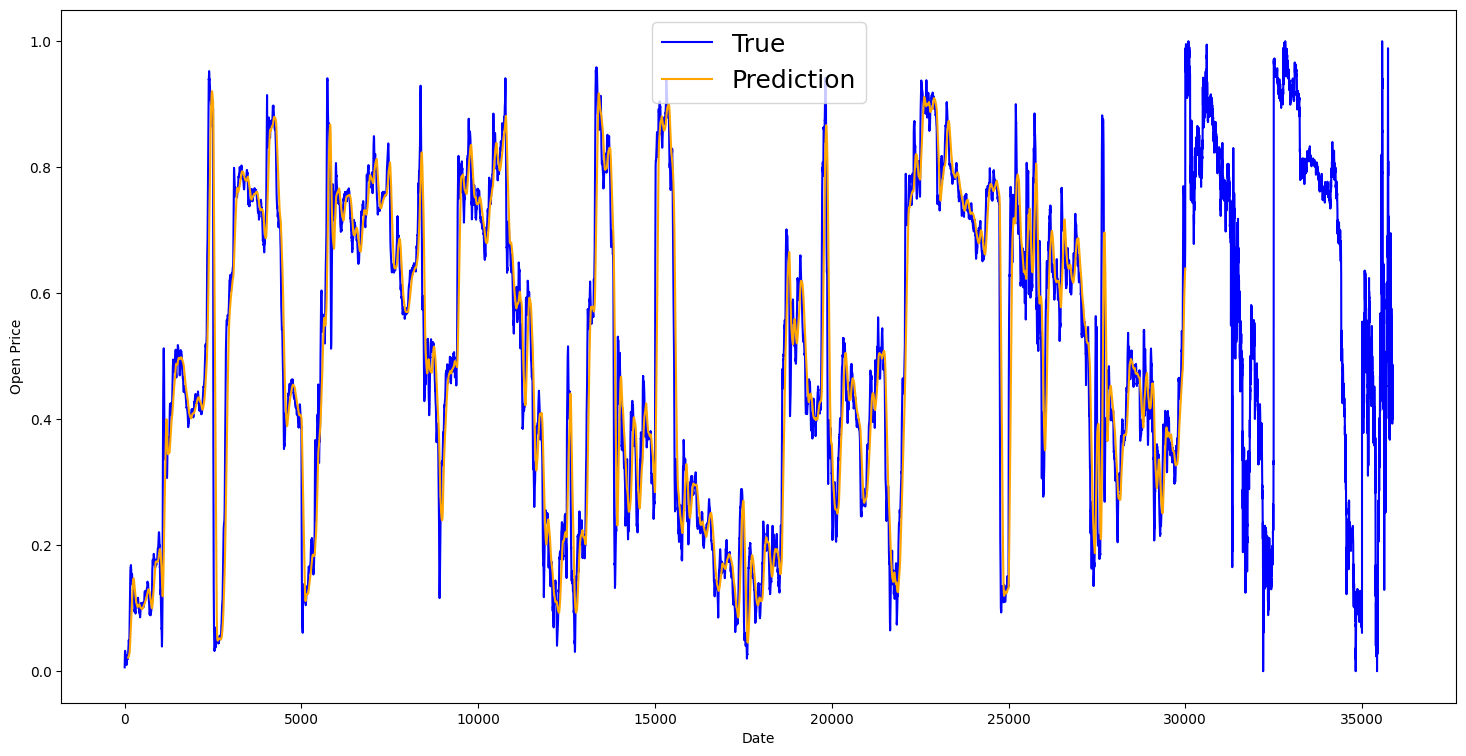

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(range(all_mid_data.size),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend(fontsize=18)
plt.show()

## **CHECK EWM RESLUTS**

In [ ]:
window_size = 5
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00000


In [ ]:
preds.shape

(30000,)

In [ ]:
from sklearn.metrics import accuracy_score

preds = np.array(run_avg_predictions)

preds = ((preds[1:] - train_data[:-1]) > 0).astype(np.int32)
true = ((train_data[1:] - train_data[:-1]) > 0).astype(np.int32)

accuracy_score(true, preds)

0.17737257908596954

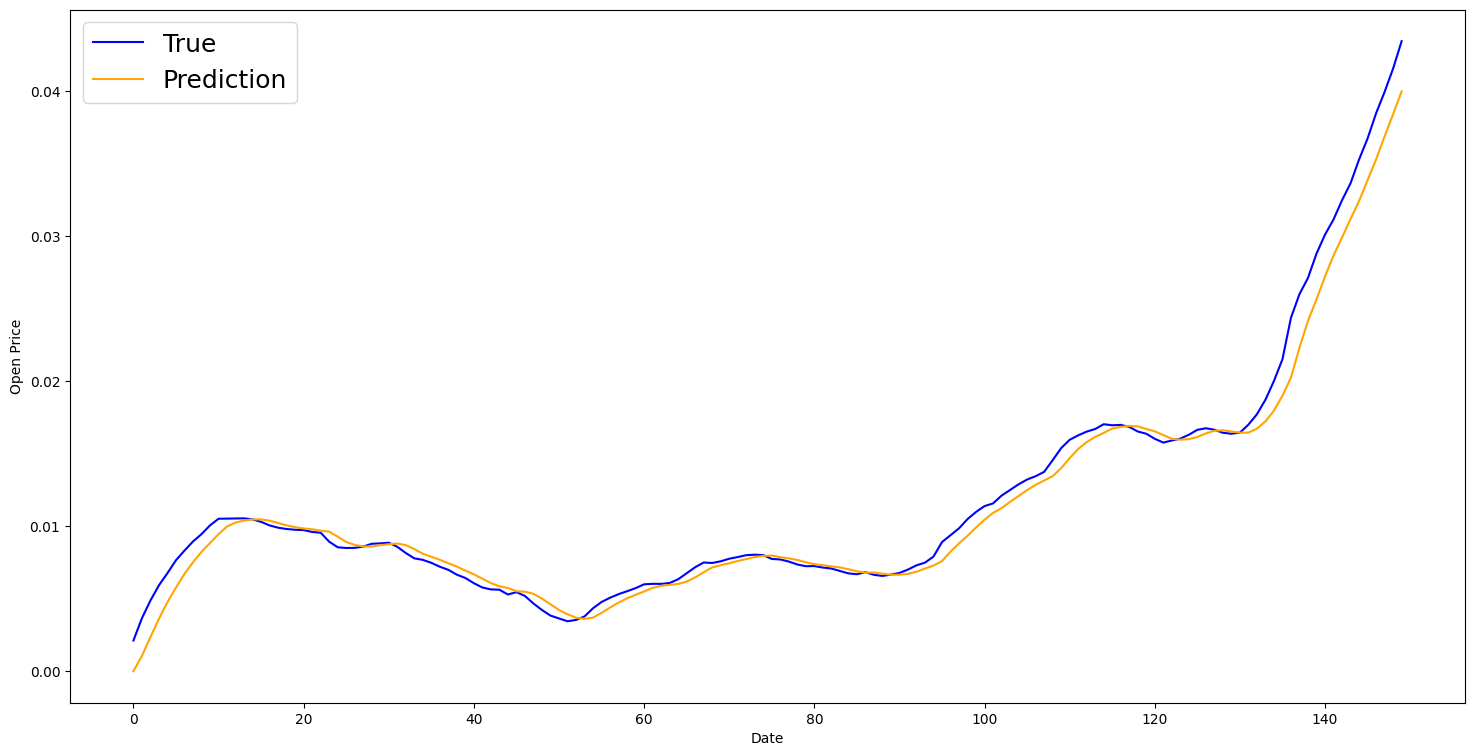

In [ ]:
plt.figure(figsize = (18,9))
#plt.plot(range(all_mid_data.size),all_mid_data,color='b',label='True')
#plt.plot(range(0,N),run_avg_predictions,color='orange',label='Prediction')
plt.plot(range(150),all_mid_data[:150],color='b',label='True')
plt.plot(range(150),run_avg_predictions[:150],color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.legend(fontsize=18)
plt.show()

In [ ]:
type(all_mid_data)

numpy.ndarray

In [ ]:
output_stats(run_avg_predictions, all_mid_data[442:])

 mape: 0.047350270401714877,
 mae: 0.011128666875433029,
 mpe: -0.0016558547618539074,
 rmse: 0.021444414302128963,
 corr: 0.9968004495281865,
r2_score: 0.9935792972335925,
 minmax: 


(0.047350270401714877,
 0.011128666875433029,
 -0.0016558547618539074,
 0.021444414302128963,
 0.9968004495281865,
 0.9935792972335925)

## ARIMA compare

In [ ]:
WINDOW_SIZE = 150
df_n_mins = parsed_klines[635572:].copy()
df_n_mins = agg_to_freq_data(df_n_mins, mins)
df_n_mins.index = pd.to_datetime(df_n_mins['date'], format='%d.%m.%Y %H:%M:%S')

df_n_mins = df_n_mins[[OPR, HPR, LPR, VOL, TN, TAKER]]
df_n_mins = get_and_smooth(df_n_mins, smoothing_window_size=2500)
X_arima, y_arima = df_to_X_y_n_feat(df_n_mins, WINDOW_SIZE)

X_arima.shape, y_arima.shape

((151, 150, 6), (151, 6))

In [ ]:
y_arima = y_arima[:, 0]

5/5 [==============================] - 0s 19ms/step
     ARIMA Test Predictions   Actuals
0                  0.680043  0.691131
1                  0.704946  0.688183
2                  0.674073  0.680434
3                  0.655737  0.656996
4                  0.674213  0.690868
..                      ...       ...
146                0.475132  0.478291
147                0.471306  0.459903
148                0.437045  0.431313
149                0.440819  0.436538
150                0.414121  0.401132

[151 rows x 2 columns]


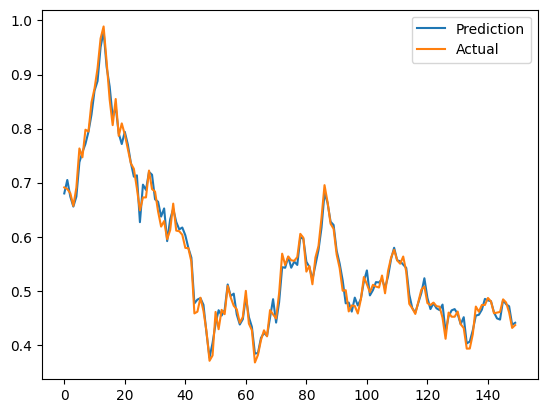

 mape: 0.02017126174458853,
 mae: 0.010967167156615262,
 mpe: 0.0040130864073652855,
 rmse: 0.013554008034387487,
 corr: 0.9949487902796887,
 minmax: 
(0.02017126174458853, 0.010967167156615262, 0.0040130864073652855, 0.013554008034387487, 0.9949487902796887)


In [ ]:
get_predictions(model_1_min_7, X_arima, y_arima, 'ARIMA Test', drop_nulls=True)